# Data Cleaning

In [317]:
# Base imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
# File imports
import gr_config
import signin_config
# NLP imports
import nltk
from nltk.corpus import gutenberg, stopwords
from nltk.collocations import *
from nltk import FreqDist
from nltk import word_tokenize
import string
import re
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *

In [2]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)


## Clean data 

- look for nan values, empty descriptions, clean types (str -> int), (organize pictures)
    ratings, number of ratings, pages (str -> int)


Merging with other dataframe -->

In [541]:
df = pd.read_csv('goodread_data2_reb1.csv')
df1 = df1 = pd.read_csv('cleaned_gr_data_quan2.csv')
df_genres = pd.concat([df,df1], sort=True)
df_parent = pd.concat([df,df1], sort=True)

In [547]:
df_genres.drop(['Unnamed: 0','format'], axis=1, inplace=True) # drop format and random first column
df_genres.pages = df_genres.pages.apply(lambda x: float(str(x).split(' ')[0]))
df_genres.genre = df_genres.genre.apply(lambda x: x.replace('{','').replace('}',''))
df_genres.genre = df_genres.genre.apply(lambda x: x.replace("'",''))
df_genres['genre'] = df_genres['genre'].map(lambda x: x.lower().split(','))

## NLP cleaning

Filtering, Stemming, Lemming and TF-IDF to produce an nlp-friendly dataset named 'nlp'

Functions to clean:

In [539]:
def lemmatize_stemming(text):
    '''
    Return lemmatized text
    '''
    word = WordNetLemmatizer().lemmatize(text, pos='v')
    return stemmer.stem(word)

def preprocess(text, stopwords_list):
    '''
    Returns text that is not longer than 3 chars or stop words (as defined by stopwords_list and gensim library) 
    '''
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3 and token not in stopwords_list:
            result.append(lemmatize_stemming(token))
    return result

# new stopwords_list and regex pattern
pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
stopwords_list = stopwords.words('english')
stopwords_list += list(string.punctuation)
stopwords_list += ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
stopwords_list += ['book', 'author', 'novel', 'year', 'come', 'stories','story','thing','alex', 'stephanie', 
                   'bestseller']

In [545]:
nlp = df_genres[['description']]
nlp['describe_raw'] = nlp.description.apply(lambda info: nltk.regexp_tokenize(info, pattern));
nlp['raw_token'] = nlp.describe_raw.apply(lambda x: [word.lower() for word in x]);
nlp['token_list'] = nlp.raw_token.apply(lambda x : [word for word in x if word not in stopwords_list]);
nlp['freq_dist'] = nlp.describe_raw.apply(lambda x: FreqDist(x));
nlp['freq_dist_top'] = nlp.freq_dist.apply(lambda x: x.most_common(20));

# apply tfidf to vectorize
tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df=0, stop_words='english')
nlp['tfidf'] = tf.fit_transform(nlp['description'])

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

# TF-IDF Content-Based Recommendation System

In [223]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from scipy import stats

In [565]:
def item(id, ds):
    return ds.loc[ds['id'] == id]['titles'].tolist()[0].split(' - ')[0]

# Just reads the results out of the dictionary.
def recommend(item_id, num, results, ds):
    item_id = ds.iloc[item_id]['id']
    print("Recommending " + str(num) + " products similar to " + item(item_id, ds) + "...")
    print("-------")
    recs = results[item_id][:num]
    for rec in recs:
        print (rec[1])
        print("Recommended: " + item(rec[1], ds) + " (score:" + str(rec[0]) + ")")


## Based on Description
Cosine Similarities:


In [574]:
ds = df_genres.copy(deep=False)

#getting stuck at 3998 for some reason
tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(ds['description'])

cosine_similarities = linear_kernel(tfidf_matrix, tfidf_matrix)

results = {}

for idx, row in ds.iterrows():
    similar_indices = cosine_similarities[idx].argsort()[:-100:-1] # not sure why this is here
    similar_items = [(cosine_similarities[idx][i], ds['id'][i]) for i in similar_indices]

    results[row['id']] = similar_items[1:]
    
print('done!')

def item(id):
    return ds.loc[ds['id'] == id]['description'].tolist()[0].split(' - ')[0]

# Just reads the results out of the dictionary.
def recommend(item_id, num):
    print("Recommending " + str(num) + " products similar to " + item(item_id) + "...")
    print("-------")
    recs = results[item_id][:num]
    for rec in recs:
        print("Recommended: " + item(rec[1]) + " (score:" + str(rec[0]) + ")")


KeyError: 3998

In [ ]:
recommend(item_id=11, num=5)

## Iteration 3: Genre, description and author

In [468]:
# !pip install rake-nltk
from rake_nltk import Rake

In [580]:
keys_df = pd.read_csv('keywords.csv')
df_genres['Key_words'] = keys_df['Key_words']

In [593]:
df_genres

,authors,description,genre,id,num_ratings,pages,ratings,titles,Key_words,key_words
0,Suzanne Collins,My name is Katniss Everdeen Why am I not dead ...,"[young adult, fantasy, fiction, dystopia, ...",7260188,"2,113,434 ratings",390.000,4.030,"Mockingjay (The Hunger Games, #3)",,
1,Laura Hillenbrand,In her longawaited new book Laura Hillenbrand ...,"[biography, world war ii, nonfiction, war, ...",8664353,"681,617 ratings",473.000,4.380,"Unbroken: A World War II Story of Survival, Re...",,
2,Cassandra Clare,In a time when Shadowhunters are barely winnin...,"[young adult, steampunk, romance, fantasy, ...",7171637,"602,348 ratings",481.000,4.330,"Clockwork Angel (The Infernal Devices, #1)",,
3,Emma Donoghue,To fiveyearoldJack Room is the world Told in ...,"[contemporary, adult, adult fiction, fiction]",31685789,"656,885 ratings",321.000,4.050,Room,,
4,Ally Condie,In the Society officials decide Who you love W...,"[romance, young adult, science fiction, dys...",7735333,"608,820 ratings",369.000,3.670,"Matched (Matched, #1)",,
5,Rebecca Skloot,Her name was Henrietta Lacks but scientists kn...,"[biography, science, health, medicine, non...",6493208,"523,298 ratings",370.000,4.060,The Immortal Life of Henrietta Lacks,,
6,Rick Riordan,Jason has a problem He doesn’t remember anythi...,"[fantasy, young adult, mythology]",7736182,"563,126 ratings",557.000,4.350,"The Lost Hero (The Heroes of Olympus, #1)",,
7,Stephanie Perkins,Anna is looking forward to her senior year in ...,"[young adult, romance, contemporary, womens...",6936382,"342,057 ratings",372.000,4.020,Anna and the French Kiss (Anna and the French ...,,
8,James Dashner,Solving the Maze was supposed to be the end ...,"[apocalyptic, young adult, mystery, post ap...",7631105,"406,020 ratings",362.000,3.920,"The Scorch Trials (The Maze Runner, #2)",,
9,Lauren Oliver,For popular high school senior Samantha Kingst...,"[young adult, teen, contemporary, fantasy, ...",6482837,"278,236 ratings",470.000,3.910,Before I Fall,,


In [506]:
# putting the genres in a list of words
df['authors'] = df['authors'].map(lambda x: x.lower().replace(' ',''))
df['genre'] = df.genre.apply(lambda x: [gen.replace(' ','') for gen in x])

In [589]:
import string
for c in string.punctuation:
    df_genres.description = df_genres.description.apply(lambda x: x.replace(c,""))
for s in string.digits:
    df_genres.description = df_genres.description.apply(lambda x: x.replace(s,""))
    df_genres.description = df_genres.description.apply(lambda x: x.replace('”',''))
    df_genres.description = df_genres.description.apply(lambda x: x.replace('“',''))

In [597]:
df_genres['key_words'] = ""
for index, row in df_genres.iterrows():
    plot = row['description']
    
    # instantiating Rake, by default is uses english stopwords from NLTK
    # and discard all puntuation characters
    r = Rake()
    # extracting the words by passing the text
    r.extract_keywords_from_text(plot)
    # getting the dictionary with key words and their scores
    key_words_dict_scores = r.get_word_degrees()

    # assigning the key words to the new column
    df_genres['key_words'].iloc[index] = list(key_words_dict_scores.keys())

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a6e82fbf8>, {'dead': 5, 'revolution': 4, 'design': 1, 'future': 1, 'katniss': 11, 'everdeen': 6, 'course': 1, 'home': 1, 'girl': 4, 'new': 2, 'leaders': 2, 'captured': 1, 'seems': 1, 'distrust': 1, 'district': 4, 'capitol': 5, 'everyone': 2, 'rebels': 4, 'part': 1, 'come': 1, 'hand': 1, 'overthrow': 1, 'countless': 2, 'lives': 2, 'feelings': 1, 'accept': 2, 'responsibility': 2, 'unfolding': 1, 'rescued': 1, 'really': 3, 'carefully': 4, 'laid': 4, 'plansexcept': 4, 'pawn': 1, 'panem': 1, 'fire': 1, 'survived': 3, 'even': 3, 'though': 3, 'change': 1, 'safe': 2, 'peeta': 2, 'success': 1, 'rebellion': 2, 'hinges': 2, 'must': 5, 'put': 3, 'aside': 3, 'anger': 1, 'name': 1, 'haunting': 3, 'quarter': 3, 'quell': 3, 'arena': 1, 'escaped': 3, 'katnisss': 5, 'family': 3, 'exist': 1, 'shadows': 1, 'become': 2, 'cruel': 1, 'personal': 2, 'cost': 2, 'without': 3, 'knowing': 3, 'destroyed': 2, 'gale': 2, 'mockingjayno'

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b09f66840>, {'light': 2, 'wishes': 2, 'senior': 2, 'year': 3, 'city': 1, 'looking': 2, 'forward': 2, 'boarding': 2, 'school': 2, 'serious': 2, 'girlfriend': 2, 'longawaited': 3, 'french': 3, 'kiss': 3, 'crush': 1, 'less': 1, 'thrilled': 1, 'meets': 8, 'étienne': 16, 'st': 8, 'clair': 8, 'smart': 8, 'charming': 8, 'beautiful': 8, 'anna': 1, 'becoming': 1, 'allincluding': 1, 'atlanta': 1, 'verge': 1, 'way': 1, 'great': 2, 'job': 2, 'coming': 2, 'true': 2, 'romantic': 3, 'nearmisses': 3, 'end': 3, 'loyal': 3, 'best': 3, 'friend': 3, 'parisuntil': 1, 'shipped': 1})
defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b09f66158>, {'variables': 1, 'help': 1, 'begun': 1, 'odds': 1, 'gladers': 5, '’': 5, 'destruction': 4, '—': 6, 'world': 1, 'others': 1, 'escape': 1, 'either': 2, 'make': 2, 'maze': 5, 'would': 4, 'mean': 4, 'freedom': 4, 'determined': 1, 'tested': 2, 'loyalties': 2, '

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a63607268>, {'mythical': 3, 'faery': 7, 'king': 3, 'six': 1, 'guessed': 1, 'never': 5, 'quite': 3, 'fit': 3, 'dead': 1, 'might': 3, 'rather': 3, 'see': 3, 'far': 3, 'shell': 3, 'go': 3, 'school': 1, 'dark': 4, 'stranger': 4, 'begins': 4, 'watching': 4, 'home': 1, 'let': 1, 'always': 3, 'felt': 3, 'slightly': 3, 'stop': 1, 'eyes': 1, 'prankster': 6, 'best': 6, 'friend': 6, 'becomes': 6, 'strangely': 6, 'protective': 6, 'everything': 3, 'shes': 3, 'known': 3, 'daughter': 1, 'cares': 1, 'meghans': 4, 'life': 4, 'ever': 4, 'since': 4, 'mysterious': 2, 'evil': 2, 'young': 2, 'prince': 2, 'father': 2, 'disappeared': 2, 'deadly': 2, 'war': 2, 'change': 1, 'creature': 4, 'dare': 4, 'face': 4, 'imagined': 2, 'something': 2, 'truth': 1, 'save': 2, 'someone': 2, 'could': 2, 'find': 2, 'love': 2, 'icy': 2, 'heart': 2, 'meghan': 5, 'senses': 2, 'afar': 1, 'learn': 1, 'touch': 1, 'chase': 2, 'pawn': 1, 'secret': 3, 'de

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a6d993ea0>, {'bianca': 13, 'friends': 1, 'turns': 1, 'guy': 1, 'desperate': 1, 'suddenly': 3, 'realizes': 3, 'goes': 3, 'horribly': 3, 'awry': 3, 'smart': 1, 'falling': 1, 'ends': 1, 'also': 2, 'way': 2, 'face': 1, 'manslut': 1, 'life': 1, 'eager': 1, 'fall': 1, 'kissing': 3, 'wesley': 9, 'worse': 3, 'pretty': 2, 'screwed': 2, 'slimy': 5, 'school': 5, 'hottie': 5, 'rush': 5, 'cynical': 1, 'anyone': 1, 'home': 2, 'right': 2, 'absolute': 2, 'horror': 2, 'nicknames': 1, 'fact': 3, 'hates': 3, 'great': 1, 'throws': 4, 'bad': 2, 'listener': 2, 'coke': 1, 'charms': 1, 'things': 1, 'likes': 1, 'hated': 1, 'closeted': 3, 'enemieswithbenefits': 3, 'relationship': 3, 'loyal': 1, 'escape': 3, 'duff': 1, '’': 1, 'long': 2, 'shot': 2, 'prettiest': 1, 'think': 1, 'thought': 1, 'seventeenyearold': 3, 'piper': 3, 'distraction': 1})
defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a5f61484

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a636261e0>, {'place': 1, 'wake': 1, 'embrace': 1, 'expectations': 1, 'wholehearted': 3, 'livinga': 3, 'way': 3, 'research': 1, 'night': 3, 'thinking': 4, 'yes': 4, 'images': 1, 'belonging': 3, 'shares': 2, 'enough': 1, 'people': 2, 'think': 3, 'worthy': 1, 'sometimes': 2, 'afraid': 2, 'cultivate': 1, 'world': 1, 'led': 1, 'new': 5, 'york': 5, 'times': 5, 'bestselling': 5, 'author': 5, 'bed': 1, 'imperfections': 1, 'cant': 2, 'keep': 2, 'face': 1, 'lead': 4, 'perfect': 7, 'lives': 4, 'wed': 4, 'go': 1, 'matter': 1, 'inspiring': 2, 'book': 2, 'barrage': 1, 'day': 1, 'engaging': 1, 'morning': 1, 'gifts': 1, 'society': 1, 'much': 1, 'living': 1, 'recognize': 1, 'longer': 3, 'feel': 3, 'inadequate': 3, 'powerful': 1, 'media': 3, 'telling': 3, 'us': 6, 'fail': 1, 'decade': 1, 'truth': 1, 'could': 1, 'look': 2, 'give': 1, 'worthinessin': 1, 'love': 1, 'vulnerable': 1, 'air': 1, 'isnt': 5, 'everyone': 5, 'else': 

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a63626730>, {'hes': 15, 'always': 5, 'showing': 3, 'another': 2, 'indication': 2, 'special': 2, 'focus': 2, 'jacobs': 8, 'small': 5, 'hometown': 3, 'telling': 1, 'cops': 1, 'local': 3, 'police': 5, 'suddenly': 3, 'terrible': 5, 'murder': 8, 'law': 5, 'enforcement': 5, 'comes': 5, 'one': 4, 'subject': 4, 'forensic': 4, 'analysis': 4, 'rocked': 1, 'teen': 1, 'directly': 1, 'scanner': 2, 'brilliant': 1, 'usually': 3, 'right': 3, 'son': 3, 'cant': 3, 'look': 4, 'others': 2, 'though': 2, 'well': 1, 'room': 2, 'clues': 2, 'fit': 1, 'nothing': 1, 'jacob': 9, 'commit': 3, 'reading': 3, 'social': 3, 'cues': 3, 'expressing': 1, 'crime': 2, 'scenes': 2, 'want': 1, 'aspergers': 6, 'syndrome': 4, 'hopeless': 4, 'normal': 1, 'mean': 5, 'guilty': 5, 'hunt': 7, 'brother': 2, 'theo': 2, 'family': 5, 'soulsearing': 3, 'question': 3, 'looms': 3, 'mother': 3, 'emma': 3, 'misunderstanding': 1, 'many': 2, 'ways': 2, 'lot': 3, 

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a6e82fe18>, {'characters': 3, 'familiar': 1, 'brothers': 3, 'death': 3, 'sparks': 3, 'loss': 1, 'mrs': 7, 'ali': 7, 'soon': 4, 'find': 4, 'generations': 4, 'honor': 4, 'duty': 4, 'decorum': 4, 'contemporary': 2, 'fiction': 2, 'first': 2, 'page': 2, 'travel': 1, 'one': 4, 'tea': 1, 'village': 8, 'drawn': 3, 'together': 3, 'englishmen': 1, 'face': 1, 'relationship': 2, 'survive': 2, 'rolling': 4, 'hills': 4, 'thatched': 4, 'cottages': 4, 'quiet': 3, 'life': 3, 'valuing': 3, 'lived': 1, 'culture': 1, 'major': 11, 'leads': 2, 'cast': 1, 'permanent': 2, 'foreigner': 2, 'heart': 1, 'tradition': 1, 'quintessential': 2, 'local': 2, 'small': 2, 'something': 1, 'properly': 3, 'brewed': 3, 'cup': 3, 'unlikely': 2, 'hero': 2, 'respective': 2, 'spouses': 2, 'friendship': 4, 'blossoming': 2, 'edgecombe': 3, 'st': 3, 'mary': 3, 'indelible': 2, 'shared': 2, 'love': 2, 'members': 1, 'family': 2, 'among': 2, 'proper': 2, '

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a6e8672f0>, {'taunted': 1, 'wolf': 2, 'within': 2, 'would': 1, 'lose': 1, 'end': 13, 'draws': 12, 'near': 12, 'pattern': 1, 'creatures': 2, 'beyond': 2, 'blight': 1, 'shadow': 1, 'many': 2, 'threads': 2, 'prison': 1, 'dice': 1, 'unseen': 2, 'foe': 2, 'hoped': 1, 'pieces': 1, 'eelfinnhave': 2, 'confused': 2, '’': 28, 'unraveling': 1, 'lives': 1, 'memory': 2, 'stuffed': 2, 'slowly': 2, 'pulling': 2, 'crumbling': 1, 'bits': 1, 'wayat': 4, 'long': 7, 'lastto': 4, 'master': 4, 'dance': 1, 'armies': 1, 'secrets': 1, 'men': 2, 'penultimate': 2, 'novel': 2, 'difficult': 2, 'challenge': 2, 'stone': 3, 'gatewaysthe': 3, 'aelfinn': 3, 'tel': 5, 'aran': 5, 'rhiod': 5, 'forever': 5, 'meanwhile': 5, 'matrim': 5, 'cauthon': 5, 'prepares': 5, 'coming': 1, 'neck': 1, 'last': 4, 'confrontation': 2, 'brings': 2, 'dramatic': 2, 'three': 2, 'based': 2, 'prevail': 1, 'ghenjei': 2, 'awaits': 2, 'friend': 3, 'lost': 3, 'past': 2

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b0d73dae8>, {'always': 1, 'dealing': 1, 'without': 1, 'greg': 7, 'suddenly': 3, 'finds': 3, 'awkward': 2, 'changes': 2, 'ugly': 2, 'truth': 2, 'heffley': 2, 'pressures': 1, 'face': 1, 'make': 2, 'come': 1, 'getting': 6, 'older': 6, '—': 3, 'grow': 1, 'best': 3, 'friend': 3, 'rowley': 3, 'side': 1, 'cracked': 1, 'really': 3, 'hurry': 1, '’': 1, 'even': 1, 'boygirl': 4, 'parties': 4, 'increased': 4, 'responsibilities': 4})
defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b0d6352f0>, {'hawking': 7, 'complete': 2, 'theory': 11, 'universe': 10, 'evidence': 2, 'laws': 6, 'finely': 2, 'tuned': 2, 'grand': 5, 'design': 5, 'unified': 2, 'mtheory': 1, 'according': 1, 'provoke': 3, '—': 15, 'like': 5, 'history': 9, 'conventional': 2, 'concept': 2, 'many': 2, 'universes': 2, 'nearly': 1, 'motion': 2, 'brilliance': 1, 'fact': 1, 'decade': 1, 'idea': 3, 'calls': 2, 'cherished': 3, 'beli

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a6e82f048>, {'worth': 1, 'brotherhood': 1, 'john': 7, 'matthew': 2, 'symphath': 2, 'assassin': 2, 'true': 5, 'history': 2, 'allow': 1, 'fallen': 3, 'brother': 3, 'darius': 3, 'darkness': 1, 'order': 1, 'need': 1, 'already': 4, 'lost': 4, 'one': 7, 'lover': 4, 'vampire': 3, 'nature': 3, 'unknown': 3, 'vicious': 5, 'personal': 5, 'vendetta': 5, 'takes': 5, 'attraction': 1, 'face': 3, 'evil': 3, 'incarnate': 3, 'xhex': 3, 'soul': 2, 'mates': 2, 'identity': 3, 'indeed': 3, 'come': 1, 'heart': 1, 'inevitable': 1, 'male': 1, 'found': 4, 'living': 4, 'among': 4, 'humans': 4, 'returned': 1, 'madness': 1, 'long': 5, 'steeled': 2, 'different': 4, 'destiny': 5, 'fate': 3, 'intervenes': 3, 'however': 3, 'call': 1, 'could': 3, 'guess': 3, 'fall': 2, 'prey': 2, 'twisted': 2, 'life': 2, 'war': 1, 'love': 3, 'like': 3, 'taken': 1, 'two': 2, 'discover': 2, 'way': 3, 'since': 3, 'around': 1})
defaultdict(<function Rake._bu

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b0d635158>, {'strange': 2, 'talent': 2, 'grappling': 1, 'serial': 2, 'killer': 3, 'quest': 1, 'mostly': 1, 'murderer': 2, '—': 6, 'dead': 9, 'birds': 2, 'imprints': 1, 'leave': 3, 'behind': 3, 'unnerved': 1, 'prey': 1, 'world': 1, 'never': 2, 'considered': 2, 'led': 1, 'cat': 2, 'left': 2, 'felt': 1, 'stop': 1, 'fierce': 2, 'protectiveness': 2, 'closer': 3, 'might': 1, 'new': 2, 'feelings': 2, 'violet': 9, 'ambrose': 2, 'disturbed': 1, 'echoes': 1, 'best': 4, 'friend': 4, 'since': 6, 'childhood': 4, 'sense': 4, 'bodies': 4, 'attach': 1, 'daily': 1, 'much': 1, 'getting': 2, 'realizes': 1, 'gift': 1, 'discovering': 1, 'becoming': 1, 'sixteenyearold': 1, 'least': 1, 'murdered': 2, 'small': 2, 'town': 2, 'despite': 1, 'friendly': 1, 'person': 1, 'little': 2, 'girl': 2, 'shes': 3, 'falling': 3, 'intensely': 3, 'hope': 1, 'power': 1, 'confused': 1, 'find': 1, 'terrorizing': 1, 'love': 2, 'morbid': 3, 'secret': 

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b0d61dd90>, {'life': 3, 'although': 2, 'hunters': 1, 'dangerous': 4, 'enemy': 4, 'mythical': 4, 'powers': 4, 'mortal': 9, 'world': 2, 'avoid': 1, 'story': 1, 'expectations': 1, 'ancient': 2, 'divide': 2, 'longs': 1, 'make': 1, 'left': 1, 'flee': 1, 'breathtaking': 3, 'romance': 3, 'ignite': 3, 'gorgeous': 2, 'elusive': 2, 'stirs': 1, 'draki': 3, 'human': 6, 'forever': 3, 'shell': 3, 'prevent': 1, 'hunt': 1, 'adapt': 1, 'kind': 1, 'new': 2, 'surroundings': 2, 'stranger': 4, 'jacinda': 13, 'knows': 9, 'wills': 5, 'dark': 5, 'secret': 7, 'hidden': 7, 'truth': 7, 'enemies': 7, 'doomed': 7, 'love': 10, 'marked': 7, 'costs': 1, 'anything': 1, 'whose': 7, 'crosses': 3, 'choices': 1, 'bright': 2, 'light': 2, 'irresistibly': 2, 'drawn': 2, 'girl': 1, 'every': 2, 'move': 2, 'shift': 1, 'freedom': 1, 'special': 1, 'early': 4, 'age': 4, 'ability': 2, 'dragons': 4, 'greatest': 4, 'defense': 4, 'nearly': 2, 'pays': 2, 

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b0d63c950>, {'decaying': 4, 'castle': 6, 'edie': 8, 'begins': 4, 'haunted': 1, 'someone': 1, 'storytelling': 1, 'moldering': 3, 'old': 6, 'house': 3, 'milderhurst': 3, 'mother': 3, 'waiting': 1, 'memory': 1, '‘': 1, 'happened': 1, 'long': 6, 'time': 2, 'rich': 2, 'power': 2, 'billeted': 2, 'years': 2, 'wwii': 1, 'reminds': 2, 'us': 2, 'youngest': 3, 'sister': 3, 'juniper': 3, 'great': 1, 'elder': 3, 'blythe': 6, 'sisters': 3, 'morton': 1, 'truth': 1, 'spinsters': 3, 'live': 3, 'expected': 1, 'love': 1, 'inside': 1, 'lives': 2, 'looking': 2, 'enthralls': 2, 'readers': 2, '’': 6, 'find': 1, 'journey': 1, 'since': 1, 'learn': 1, 'twins': 1, 'fiance': 2, 'jilted': 2, 'third': 1, 'spent': 1, 'atmospheric': 6, 'story': 6, 'featuring': 6, 'unforgettable': 6, 'characters': 6, 'beset': 6, 'past': 1, 'stones': 1, 'circumstance': 1, 'burchill': 3, 'finds': 3, 'secrets': 2, 'hidden': 2, 'lost': 4, 'letter': 4, 'arriv

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a562eba60>, {'shocking': 2, 'revelations': 2, 'high': 6, 'profile': 6, 'city': 6, 'centre': 6, 'nightclubs': 6, 'scott': 9, 'realizations': 1, 'angela': 6, 'make': 4, 'ends': 4, 'meet': 4, 'working': 4, 'longer': 2, 'know': 2, 'small': 4, 'time': 4, 'drug': 9, 'dealer': 4, 'string': 1, 'mark': 2, 'fallon': 2, 'present': 2, 'combine': 2, 'smallscale': 5, 'dealing': 5, 'operation': 5, 'dejected': 4, 'year': 8, 'old': 8, 'struggling': 4, 'cannabis': 1, 'past': 2, 'leading': 2, 'career': 2, 'criminal': 2, 'supplementing': 1, 'months': 1, 'apocalyptic': 2, 'climax': 2, 'father': 1, 'brother': 1, 'overworked': 3, 'detective': 3, 'investigating': 3, 'attractive': 4, 'raised': 4, 'attacks': 1, 'chilling': 3, 'tale': 3, 'spanning': 3, 'spate': 1, 'trust': 1, 'lives': 1, 'supplies': 2, 'income': 1})
defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b09f66a60>, {'walks': 2, 'among': 2

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b0ac82620>, {'centuries': 1, 'final': 7, 'artifacts': 7, 'kendra': 4, 'seth': 4, 'intercept': 1, 'globe': 1, 'world': 1, 'sphinx': 3, '—': 6, 'leader': 3, 'keys': 1, 'exotic': 3, 'preserves': 3, 'across': 3, 'dawn': 2, 'race': 2, 'open': 1, 'great': 4, 'demon': 6, 'prison': 8, 'zzyxx': 4, 'needed': 3, 'never': 1, 'society': 1, 'usurp': 2, 'control': 3, 'strange': 1, 'risks': 1, 'legendary': 2, 'secrets': 2, 'revealed': 2, 'opened': 1, 'darkness': 2, 'collide': 2, 'evil': 1, 'tide': 1, 'evening': 3, 'star': 3, 'explosive': 4, 'series': 4, 'finale': 4, 'allegiances': 4, 'certain': 1, 'light': 1, 'knights': 1, 'stakes': 1, 'desperate': 3, 'climactic': 3, 'battle': 3, 'confirmed': 1, 'forces': 1, 'effort': 1, 'plotting': 1, 'higher': 1, 'deadly': 1})
defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b0aefee18>, {'father': 2, '’': 15, 'place': 1, 'life': 5, 'food': 3, 'becomes':

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b075072f0>, {'place': 1, 'also': 1, 'ghost': 2, 'dancing': 2, 'mullaby': 10, 'riddles': 2, 'surrounding': 2, 'form': 1, 'offers': 1, 'lovable': 2, 'misfits': 2, 'hurt': 1, 'hummingbird': 5, 'cake': 5, 'really': 6, 'bring': 5, 'back': 7, 'sweet': 2, 'tooth': 2, 'feel': 4, 'emily': 9, 'benedict': 4, 'came': 4, 'magic': 1, 'mood': 5, 'unexplained': 5, 'lights': 5, 'skip': 5, 'across': 5, 'hope': 4, 'north': 4, 'carolina': 7, 'hoping': 4, 'latest': 12, 'enchanting': 12, 'novel': 12, 'new': 12, 'york': 12, 'times': 12, 'bestselling': 12, 'author': 12, 'sarah': 12, 'addison': 12, 'allen': 12, 'invites': 12, '’': 12, 'past': 1, 'moment': 3, 'enters': 3, 'mysteries': 1, 'fears': 2, 'might': 2, 'answers': 1, 'dulcie': 3, 'shelby': 3, 'leave': 3, 'never': 10, 'knewa': 7, 'reclusive': 7, 'reallife': 7, 'gentle': 7, 'giantshe': 7, 'realizes': 7, 'hometown': 1, 'lost': 7, 'forever': 5, 'flour': 5, 'eggs': 5, 'milk': 5

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b09f66bf8>, {'zombie': 2, 'hunter': 2, 'expects': 1, 'turn': 2, 'fifteen': 2, 'half': 4, 'benny': 11, 'doesnt': 4, 'want': 4, 'zombieinfested': 3, 'postapocalyptic': 3, 'america': 3, 'means': 1, 'boring': 4, 'older': 4, 'brother': 4, 'tom': 4, 'cash': 1, 'rations': 2, 'cut': 2, 'job': 5, 'gets': 1, 'get': 1, 'imura': 7, 'lives': 7, 'every': 7, 'teenager': 7, 'must': 7, 'find': 7, 'vocation': 1, 'choice': 1, 'time': 1, 'teach': 1, 'apprentice': 1, 'tedious': 4, 'whacking': 4, 'zoms': 4, 'human': 1})
defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a5f6148c8>, {'worth': 1, 'ship': 5, 'better': 2, 'life': 4, 'beautiful': 1, 'grounded': 3, 'oil': 3, 'tankers': 3, 'light': 3, 'crew': 3, 'scavenging': 3, 'parts': 2, 'nailer': 6, 'discovers': 1, 'lone': 2, 'survivor': 2, 'recent': 4, 'hurricane': 4, 'faces': 4, 'broken': 1, 'rescue': 1, 'teenage': 3, 'boy': 3, 'works': 3, 'could'

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b0d73d6a8>, {'sudan': 3, 'refugees': 2, 'contact': 1, 'long': 2, 'walk': 6, 'fetching': 2, 'water': 4, 'families': 1, 'home': 1, 'cover': 1, 'makes': 3, 'two': 10, 'trips': 3, 'pond': 4, 'every': 7, 'day': 3, 'begins': 2, 'loneliness': 1, 'survivor': 1, 'nya': 4, '’': 6, 'killer': 2, 'lions': 2, 'search': 1, 'astonishing': 1, 'girl': 3, 'stay': 4, 'enduring': 4, 'hardship': 4, 'intersect': 1, 'moving': 2, 'way': 2, 'african': 2, 'continent': 2, 'safe': 2, 'place': 2, 'attack': 1, 'alternating': 2, 'sections': 2, 'boy': 5, 'stories': 3, 'told': 3, 'armed': 2, 'rebels': 2, 'lost': 2, 'boys': 2, 'crocodiles': 2, 'salva': 6, 'becomes': 4, 'one': 4, 'foot': 1, 'story': 2, 'goes': 2, 'hours': 4})
defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b07506950>, {'night': 1, 'immortal': 1, 'powerful': 3, 'mysterious': 3, 'vampire': 3, 'family': 2, '’': 2, 'spade': 3, 'earth': 1, 'cent

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b07503048>, {'hit': 3, 'tv': 3, 'show': 3, 'heightened': 2, 'senses': 2, 'solve': 1, 'must': 2, 'combine': 2, 'stay': 4, 'alive': 4, 'long': 4, 'enough': 4, 'pack': 1, 'acclaimed': 5, 'forensic': 5, 'anthropologist': 5, 'temperance': 5, 'brennan': 8, 'exposed': 1, 'canine': 2, 'parvovirus': 2, 'group': 2, 'rescues': 2, 'suddenly': 2, 'become': 2, 'killers': 3, 'scent': 3, 'fortunately': 3, 'virals': 1, 'medical': 2, 'testing': 2, 'friends': 4, 'theyre': 2, 'teenage': 2, 'sciphiles': 2, 'bones': 2, 'novels': 2, 'ragtag': 2, 'band': 2, 'leader': 1, 'secluded': 2, 'island': 4, 'catch': 1, 'changes': 1, 'south': 2, 'carolina': 2, 'dog': 2, 'caged': 2, 'live': 1, 'discover': 2, 'hot': 1, 'scientific': 2, 'curiosity': 2, 'lives': 2, 'forever': 2, 'newfound': 3, 'physical': 3, 'gifts': 3, 'nearby': 2, 'coast': 1, 'experimental': 2, 'strain': 2, 'animalquick': 2, 'reflexes': 2, 'tory': 3, 'niece': 3, 'coldcase': 

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b0a6a4400>, {'doubts': 1, 'man': 4, 'laurels': 4, 'quicksilver': 4, 'moods': 4, 'get': 4, 'best': 4, 'friends': 4, 'parker': 4, 'emma': 4, 'convinced': 1, 'turn': 1, 'clients': 2, 'seem': 2, 'angry': 5, 'hot': 5, 'alltogether': 5, 'mindblowing': 5, 'kiss': 5, 'vows': 4, 'wedding': 8, 'planning': 4, 'company': 4, 'thinks': 1, 'baker': 4, 'laurel': 5, 'mcbane': 4, 'herleading': 1, 'still': 1, 'others': 1, 'heror': 1, 'surrounded': 1, 'protective': 1, 'quiet': 1, 'lowkey': 1, 'reach': 3, 'plus': 3, 'del': 6, 'passion': 1, 'mind': 1, 'megacrush': 3, 'since': 3, 'childhood': 3, 'infatuations': 3, 'last': 3, 'longer': 3, 'appreciate': 1, 'better': 1, '—': 3, 'shell': 3, 'mac': 1, 'romance': 2, 'working': 2, 'ivy': 3, 'league': 3, 'lawyer': 3, 'luxuries': 1, 'moment': 1, 'line': 1, 'shes': 1, 'strong': 3, 'intelligent': 3, 'ever': 2, 'cross': 2, 'forever': 1, 'like': 5, 'parkers': 5, 'older': 5, 'brother': 5, 'd

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b0a68a158>, {'tending': 1, 'written': 1, 'drawn': 1, 'tailored': 3, 'knit': 3, 'suits': 3, 'lots': 1, 'painful': 2, 'glare': 2, 'national': 2, 'spotlight': 2, 'press': 2, 'conference': 2, 'fly': 7, 'away': 7, 'home': 7, 'fiftyseven': 1, 'older': 3, 'sister': 3, 'diana': 3, 'hilarity': 4, 'forced': 1, 'one': 3, 'another': 2, 'emergency': 3, 'room': 3, 'physician': 3, 'unforgettable': 2, 'story': 2, 'hippiechick': 3, 'wardrobe': 3, 'replaced': 3, 'wild': 4, 'curls': 4, 'wide': 4, 'hips': 4, 'opinions': 4, 'decades': 4, 'later': 4, 'sylvie': 9, 'staying': 4, 'twenty': 4, 'pounds': 4, 'thinner': 4, 'twenties': 1, 'life': 1, 'mother': 1, 'husband': 3, 'ers': 3, 'exam': 3, 'rooms': 3, 'twentyfour': 1, 'find': 3, 'refuge': 2, 'law': 2, 'school': 2, 'irresistible': 2, 'blend': 2, 'distance': 3, 'finally': 3, 'learn': 3, 'control': 5, 'still': 5, 'trouble': 5, 'always': 5, 'seems': 5, 'finds': 1, 'ideal': 5, 'poli

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b08bec400>, {'invasion': 1, 'second': 3, 'entails': 3, 'one': 3, 'old': 2, 'west': 8, 'greatest': 5, 'chief': 5, 'whose': 3, 'guerrilla': 3, 'wars': 3, 'skillful': 1, 'come': 1, 'far': 3, 'texas': 9, 'frontier': 4, 'considered': 1, 'fact': 1, 'rolled': 2, 'backward': 2, 'new': 9, 'american': 13, 'nation': 5, 'gwynne': 11, '’': 8, 'wounded': 2, 'knee': 2, 'sioux': 1, 'backdrop': 3, 'presents': 3, 'white': 8, 'squaw': 2, 'arrows': 1, 'pioneer': 5, 'woman': 5, 'cynthia': 8, 'ann': 8, 'parker': 8, 'age': 5, 'six': 5, 'full': 5, 'comanche': 16, 'braves': 5, 'tragic': 2, 'capture': 2, 'opened': 3, 'french': 3, 'expansion': 3, 'westward': 3, 'effect': 2, 'holding': 2, 'war': 3, 'refused': 1, 'halted': 1, 'warrior': 1, 'eastern': 3, 'united': 6, 'states': 6, 'legend': 1, 'history': 2, 'familiar': 1, 'compelling': 2, 'drama': 2, 'weapon': 4, 'specifically': 4, 'designed': 4, 'advent': 1, 'became': 9, 'indians': 2,

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b08bea510>, {'catacombs': 1, 'loss': 1, 'mark': 1, 'andi': 11, 'must': 3, 'accompany': 3, 'midnight': 2, 'journey': 2, 'destroying': 1, 'paris': 12, 'alexandrine': 13, '’': 13, 'journal': 2, 'tragic': 2, 'role': 2, 'finds': 4, 'brooklyn': 6, 'heights': 3, 'words': 4, 'transcend': 3, 'paper': 3, 'moved': 1, 'mother': 1, 'stage': 2, 'prestigious': 3, 'private': 3, 'school': 3, 'angry': 3, 'alpers': 3, 'two': 21, 'centuries': 12, 'ago': 3, 'doomed': 2, 'prince': 2, 'escape': 9, 'girls': 9, 'apart': 9, 'one': 9, 'never': 9, 'knowing': 9, 'expelled': 1, 'grief': 1, 'heartbroken': 1, 'able': 1, 'winter': 6, 'break': 6, 'paradis': 6, 'lived': 6, 'dreamed': 1, 'father': 3, 'leaving': 2, 'cope': 1, 'want': 2, '—': 5, 'past': 5, 'becomes': 5, 'suddenly': 5, 'terrifyingly': 5, 'present': 5, 'france': 2, 'cast': 2, 'comfort': 1, 'making': 1, 'edge': 1, 'diary': 1, 'younger': 4, 'brother': 4, 'truman': 4, 'rage': 4, '

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b0af6eae8>, {'explosive': 2, 'race': 2, 'raised': 1, 'unspeakable': 2, 'cruelty': 2, 'convinced': 1, 'sixty': 3, 'years': 3, 'converge': 3, 'love': 4, 'survival': 2, 'two': 12, 'boys': 2, 'former': 7, 'nazi': 9, 'ss': 7, 'officer': 7, 'named': 7, 'otto': 7, 'piatek': 9, 'redemption': 1, 'zamosc': 2, 'although': 2, 'triumph': 1, 'denounced': 1, 'wartorn': 2, 'poland': 2, 'ultimately': 1, 'makes': 1, 'wealthy': 2, 'philanthropist': 2, 'butcher': 1, 'young': 2, 'betray': 1, 'respected': 3, 'civic': 3, 'leader': 3, 'child': 1, 'accused': 3, 'right': 3, 'man': 2, 'solomons': 1, 'charges': 1, 'justice': 6, 'solomon': 8, 'persuades': 6, 'attorney': 10, 'catherine': 10, 'lockhart': 10, 'occupation': 2, 'moving': 1, 'brothers': 1, 'close': 1, 'bring': 2, 'rosenzweig': 5, 'ronald': 5, 'h': 5, 'balsons': 5, 'compelling': 5, 'tale': 9, 'accuser': 1, 'endure': 1, 'abandoned': 1, 'opposite': 2, 'sides': 2, 'attending':

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b0af6e6a8>, {'place': 1, 'faerie': 5, 'dana': 27, 'finds': 3, 'earth': 1, 'runs': 2, 'away': 2, 'intersect': 2, 'turns': 1, 'grasp': 5, 'hathaway': 5, 'doesnt': 5, 'know': 5, 'ordinary': 4, 'teenage': 4, 'girl': 4, 'shes': 11, 'ethan': 1, 'ever': 7, 'newfound': 2, 'friends': 2, 'enough': 1, 'avalon': 5, 'everything': 4, 'goes': 4, 'wrong': 4, 'technology': 1, 'two': 5, 'worlds': 6, 'isnt': 6, 'sure': 5, 'travel': 1, 'mention': 1, 'world': 9, 'trusted': 1, 'shell': 10, 'fit': 3, 'kill': 1, 'alcoholic': 3, 'mom': 3, 'shows': 3, 'couldnt': 1, 'moment': 4, 'sets': 4, 'foot': 4, 'tangled': 1, 'wanted': 3, 'want': 2, 'something': 2, 'decides': 3, 'fae': 11, 'politics': 4, 'someones': 4, 'trying': 4, 'captivating': 3, 'magical': 3, 'everyone': 2, 'seems': 2, 'faeriewalker': 1, 'person': 1, 'cutthroat': 2, 'game': 2, 'big': 2, 'trouble': 2, 'human': 2, 'hot': 7, 'guy': 7, 'figures': 7, 'never': 7, 'bring': 2, 'ma

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b09f66ea0>, {'seventeenyearold': 5, 'alice': 7, 'bonhams': 5, 'life': 5, 'feels': 5, 'barely': 2, 'breathe': 2, 'falling': 1, 'fondness': 1, 'meets': 3, 'shes': 12, 'drawn': 2, 'problems': 2, 'jack': 4, 'eyes': 2, 'pierce': 2, 'finds': 2, 'different': 4, 'guys': 4, 'isnt': 4, 'even': 8, 'new': 10, 'wave': 10, 'hits': 10, 'aside': 10, 'jacks': 10, 'unlike': 10, 'anyone': 10, 'ever': 10, 'met': 10, 'two': 1, 'brother': 2, 'peter': 3, 'love': 1, 'hes': 4, 'around': 4, 'though': 4, 'control': 1, 'pink': 3, 'chuck': 3, 'taylors': 3, 'caught': 1, 'cant': 2, 'stand': 2, 'worst': 1, 'vampires': 1, 'blood': 1, 'sight': 1})
defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b09f66a60>, {'stole': 1, 'holds': 1, 'man': 1, 'soon': 3, 'becomes': 3, 'clear': 3, 'protect': 1, 'knows': 1, 'truth': 2, 'behind': 2, 'stumbles': 3, 'upon': 3, 'something': 6, 'demons': 1, 'save': 1, 'sharing': 1,

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a7004c0d0>, {'worlds': 4, 'digital': 4, 'confines': 4, 'puzzles': 7, 'survive': 2, 'hell': 2, 'virtual': 3, 'utopia': 3, 'known': 3, 'confront': 1, 'hes': 6, 'jacked': 2, 'desperate': 1, 'unlock': 1, 'kill': 1, 'escape': 1, 'players': 2, 'willing': 2, 'life': 1, 'pop': 2, 'culture': 2, 'hidden': 3, 'within': 3, 'time': 7, 'teenage': 7, 'wade': 10, 'watts': 7, 'really': 7, 'feels': 7, 'alive': 7, 'whoever': 1, 'beset': 1, 'year': 2, 'reality': 2, 'ultimate': 2, 'prize': 2, 'finds': 1, 'decades': 2, 'past': 2, 'fortune': 1, 'stumbles': 3, 'upon': 3, 'promise': 3, 'massive': 3, 'power': 3, 'oasis': 3, 'wades': 5, 'devoted': 3, 'studying': 1, 'first': 2, 'clue': 2, 'ugly': 2, 'place': 2, 'race': 1, 'going': 2, 'creators': 2, 'obsession': 2, 'take': 1, 'based': 1, 'real': 4, 'world': 4, 'always': 4, 'win': 2, '—': 2})
defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a5270f6a8>,

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b0dbeca60>, {'great': 7, 'best': 4, 'friend': 4, 'someone': 4, 'friends': 1, 'night': 1, 'pages': 1, 'continental': 3, 'united': 3, 'states': 3, 'say': 4, 'one': 7, 'last': 4, 'thing': 4, 'without': 1, 'playwright': 1, 'finally': 1, 'girl': 4, 'next': 4, 'door': 4, '—': 4, 'mindy': 14, 'invites': 3, 'readers': 3, 'immigrant': 2, 'professionals': 2, 'makes': 4, 'prescription': 1, 'hollywood': 1, 'coworkers': 1, 'aware': 1, 'kaling': 8, 'swear': 1, 'life': 1, 'famous': 1, 'perfect': 2, 'amount': 2, 'acts': 2, 'accordingly': 2, 'come': 1, 'lived': 3, 'many': 3, 'lives': 3, 'starting': 2, 'fights': 2, 'fill': 1, 'know': 1, 'court': 1, 'everyone': 2, 'hanging': 2, 'timid': 3, 'chubster': 3, 'afraid': 3, 'comedy': 2, 'writer': 2, 'obedient': 2, 'child': 2, 'never': 3, 'get': 3, 'convicted': 3, 'shut': 1, 'actress': 2, 'prone': 2, 'india': 1, 'middle': 1, 'information': 1, 'romance': 2, 'friendship': 2, 'much': 

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b070147b8>, {'leads': 1, 'hero': 3, 'told': 2, 'make': 1, 'speak': 1, 'uncover': 1, 'nobility': 3, 'forces': 3, 'kvothe': 17, 'felurian': 3, 'quickly': 3, 'becomes': 5, 'entangled': 3, 'expelled': 1, 'gentle': 2, 'man': 5, 'trebon': 1, 'minstrels': 2, 'weep': 2, 'allowed': 1, 'university': 1, 'answers': 2, 'attempting': 3, 'wild': 1, 'wise': 11, 'mans': 8, 'fear': 13, 'courtly': 2, 'society': 2, 'legend': 1, 'kings': 5, 'road': 2, 'seek': 1, 'group': 1, 'men': 3, 'story': 2, 'unequaled': 2, 'tread': 2, 'paths': 2, 'learns': 1, 'view': 2, '—': 2, 'truth': 1, 'mysterious': 2, 'amyr': 2, 'sanity': 1, 'anger': 1, 'town': 1, 'moon': 1, 'stolen': 3, 'princesses': 3, 'back': 3, 'rival': 2, 'arcanist': 2, 'may': 1, 'politics': 1, 'point': 1, 'moonlight': 1, 'assassination': 3, 'attempt': 4, 'comes': 3, 'storm': 1, 'night': 1, 'powerful': 6, 'member': 2, 'mystery': 1, 'left': 1, 'fortune': 4, 'abroad': 4, 'adrift'

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b09f66c80>, {'late': 5, 'awardwinning': 5, 'writer': 5, 'siobhan': 5, 'dowd': 5, 'weaves': 1, 'twice': 6, 'carnegie': 6, 'medalwinning': 6, 'patrick': 10, 'ness': 10, 'conor': 7, 'love': 2, 'loss': 2, 'visitor': 1, 'ancient': 2, 'elemental': 2, 'extraordinary': 1, 'wakes': 2, 'theres': 2, 'dont': 3, 'quite': 3, 'seem': 3, 'mother': 6, 'first': 6, 'fell': 6, 'ill': 6, 'ever': 11, 'since': 11, 'mischief': 2, 'healing': 2, 'final': 2, 'idea': 2, 'treatments': 1, 'window': 1, 'force': 1, 'nature': 1, 'hope': 1, 'truth': 4, 'takes': 5, 'started': 1, 'dream': 5, 'every': 5, 'night': 5, 'different': 2, 'tonight': 3, 'wants': 1, 'courage': 1, 'survive': 1, 'dangerous': 2, 'thing': 2, 'bestselling': 2, 'novel': 2, 'working': 1, 'heartbreaking': 2, 'tale': 2})
defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b0701f1e0>, {'night': 1, 'deal': 1, 'mercy': 1, 'demolish': 1, 'battles': 1

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b0701f048>, {'group': 1, 'night': 1, 'avoid': 1, 'moroi': 11, 'queen': 4, 'lissa': 4, 'dragomir': 8, 'future': 1, 'punished': 1, 'vampires': 3, 'got': 2, 'jills': 2, 'guardian': 2, 'safe': 1, 'alchemists': 1, 'unfolds': 1, 'forbidden': 3, 'romance': 3, 'lurk': 3, 'one': 3, 'sympathizing': 1, 'question': 1, 'bed': 1, 'wasnt': 2, 'free': 2, 'unlikeliest': 1, 'alchemist': 2, 'sister': 1, 'deep': 2, 'trouble': 2, 'thinks': 3, 'shes': 4, 'still': 3, 'complicated': 2, 'alliance': 2, 'far': 4, 'worse': 4, 'jill': 8, 'accused': 1, 'school': 5, 'grounds': 2, 'roommate': 1, 'court': 4, 'believe': 4, 'outside': 1, 'drama': 1, 'yet': 3, 'sydneys': 3, 'blood': 3, 'must': 3, 'send': 3, 'last': 7, 'encounter': 3, 'sydney': 11, 'allegiences': 1, 'dhampir': 3, 'rose': 3, 'hathaway': 3, 'middle': 1, 'protector': 2, 'posing': 2, 'amberwood': 2, 'prep': 2, 'magic': 1, 'protect': 3, 'vampire': 3, 'secrets': 3, 'worlds': 1, 'l

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b09f66d08>, {'twin': 3, 'sisters': 3, 'shadow': 3, 'outfit': 1, 'gifted': 3, 'inventor': 3, 'steps': 3, 'alternate': 3, 'cove': 3, 'edition': 3, 'fun': 1, 'must': 3, 'finally': 3, 'reconcile': 3, 'back': 1, 'feelings': 1, 'pretty': 2, 'perfect': 2, 'outrageous': 2, 'sparkly': 2, 'better': 1, 'budding': 3, 'costume': 3, 'designer': 3, 'life': 4, 'right': 2, 'lolas': 2, 'isbn': 3, 'lola': 3, 'nolan': 3, 'lifetime': 1, 'everything': 1, 'cricket': 3, 'boy': 3, 'next': 3, 'door': 3, 'bell': 3, 'twins': 3, 'calliope': 3, 'hot': 3, 'rocker': 3, 'boyfriend': 3, 'neighborhood': 1, 'return': 2})
defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a5f6148c8>, {'full': 2, 'color': 2, 'companion': 1, 'film': 2, 'illustrated': 2})
defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b09f66400>, {'others': 3, 'best': 5, 'hope': 5, 'someone': 1, 'together': 2, 'a

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b0757a840>, {'place': 1, 'grave': 9, 'another': 9, 'maddeningly': 9, 'present': 9, 'tony': 9, 'webster': 9, 'thought': 15, 'hed': 12, 'left': 9, 'sophistication': 1, 'retirement': 1, 'height': 1, 'fallen': 1, 'obliges': 1, 'variety': 1, 'presented': 1, 'intense': 3, 'novel': 4, 'follows': 3, 'bestselling': 3, 'arthur': 3, 'george': 3, 'continued': 1, 'estimation': 1, 'never': 3, 'much': 3, 'world': 1, 'julian': 3, 'barness': 3, 'oeuvre': 3, 'life': 1, 'amicable': 2, 'divorce': 2, 'single': 2, 'sitting': 2, 'understood': 3, 'mysterious': 2, 'legacy': 2, 'brilliant': 3, 'new': 3, 'chapter': 3, 'nothing': 1, 'built': 1, 'began': 1, 'contends': 1, 'career': 1, 'stunning': 2, 'psychological': 2, 'begs': 1, 'recently': 2, 'pulse': 2, 'read': 1, 'nature': 1, 'extraordinary': 2, 'books': 2, 'acclaimed': 2, 'writer': 2, 'along': 1, 'ending': 3, 'middleaged': 2, 'man': 2, 'frightened': 1, 'vengeance': 2, 'one': 2, 

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b0d9d3bf8>, {'friends': 1, 'next': 2, 'year': 2, 'cant': 2, 'escape': 2, 'ever': 1, 'alive': 1, 'form': 1, 'deep': 2, 'recession': 2, 'highly': 3, 'charged': 3, 'erotic': 3, 'triangle': 1, 'devastating': 2, 'wit': 2, 'leonards': 4, 'seemingly': 4, 'inexhaustible': 4, 'energy': 4, 'reads': 2, 'like': 6, 'nineteenth': 3, 'century': 8, 'dead': 3, 'affection': 1, 'divorce': 1, 'updike': 1, 'listening': 1, 'george': 3, 'eliot': 3, 'purveyors': 3, 'marquis': 3, 'de': 3, 'sade': 3, 'semiotics': 2, 'seminar': 2, 'lost': 5, 'portland': 5, 'boy': 5, 'suddenly': 5, 'turns': 5, 'lives': 1, 'madeleine': 17, 'understand': 1, 'destined': 1, 'cape': 2, 'cod': 2, 'great': 3, 'love': 4, 'stories': 3, 'mate': 1, 'mitchell': 8, 'traveling': 3, 'around': 3, 'intimate': 2, 'journal': 2, 'country': 1, 'college': 12, 'hill': 2, 'lies': 1, 'novel': 5, 'idea': 1, 'members': 1, 'plunging': 2, 'moods': 2, 'early': 1, 'became': 2, 'l

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a4fb080d0>, {'enters': 1, 'keeps': 1, 'ride': 1, 'water': 4, 'horses': 4, 'long': 4, 'enough': 4, 'make': 1, 'buried': 2, 'deep': 2, 'riders': 8, 'live': 4, 'others': 4, 'die': 4, 'never': 2, 'meant': 2, 'competition': 2, '—': 2, 'see': 1, 'start': 1, 'much': 1, 'given': 1, 'scorpio': 6, 'races': 6, 'puck': 2, 'connolly': 2, 'attempt': 4, 'age': 4, 'nineteen': 4, 'sean': 4, 'kendrick': 4, 'happen': 1, 'way': 2, 'prepared': 2, 'going': 1, 'first': 3, 'girl': 3, 'ever': 3, 'different': 1, 'fate': 1, 'happens': 1, 'one': 2, 'else': 2, 'finish': 2, 'line': 2, 'fears': 1, '’': 1, 'every': 2, 'november': 2, 'chance': 1, 'returning': 2, 'champion': 2, 'words': 1, 'young': 2, 'man': 2, 'keep': 2, 'hold': 2})
defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b0d9f7378>, {'us': 11, 'nine': 2, 'six': 7, 'beyond': 2, 'anything': 2, 'soon': 2, 'well': 2, 'still': 5, 'believe': 2, 'could

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b0d9d9620>, {'thrilling': 3, 'chase': 3, 'ends': 3, 'remarkable': 4, 'figures': 4, 'vivid': 4, 'detail': 4, 'devised': 1, 'americas': 5, 'civil': 5, 'war': 5, 'finally': 5, 'comes': 5, 'bloody': 2, 'saga': 2, 'furious': 3, 'manhunt': 3, 'ensues': 3, 'fulfill': 3, 'lincolns': 11, 'dream': 3, 'impenitent': 6, 'racist': 6, '—': 22, 'murders': 6, 'abraham': 16, 'lincoln': 12, 'clues': 2, 'leading': 2, 'smart': 1, 'string': 1, 'first': 6, 'work': 2, 'series': 1, 'former': 7, 'confederates': 3, 'allowed': 3, 'booth': 13, 'federal': 3, 'forces': 3, 'track': 3, 'healing': 1, 'oreilly': 8, 'factor': 4, 'recounts': 4, 'one': 9, 'appeased': 1, 'us': 7, 'government': 7, 'riveting': 3, 'historical': 3, 'narrative': 3, 'heartstopping': 3, 'events': 3, 'surrounding': 3, 'history': 4, 'reads': 2, 'like': 2, 'increasingly': 8, 'harrowing': 8, 'battles': 8, 'president': 8, 'generous': 8, 'terms': 8, 'midst': 1, 'fords': 2,

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b0f2c72f0>, {'hallucinations': 1, 'fates': 2, 'insist': 2, 'getting': 3, 'harder': 3, 'nightmares': 3, 'lucas': 4, 'delos': 2, 'enough': 1, 'sheets': 2, 'damaged': 2, 'hide': 1, 'sheltered': 1, 'drawing': 1, 'trying': 5, 'entire': 4, 'sixteen': 4, 'years': 4, 'apart': 1, 'knowing': 3, 'theyre': 3, 'destined': 3, 'secrets': 1, 'blood': 1, 'play': 1, 'tear': 1, 'myths': 1, 'realizes': 1, 'defy': 5, 'repeating': 3, 'throughout': 3, 'history': 3, 'leading': 2, 'roles': 2, 'way': 1, 'dust': 1, 'destiny': 4, 'helen': 13, 'hamilton': 4, 'island': 1, 'waking': 3, 'parched': 3, 'tragedy': 1, 'desperate': 3, 'desert': 3, 'journey': 3, 'nantucket': 1, 'easy': 2, 'task': 2, 'different': 1, 'dirt': 1, 'first': 4, 'crosses': 4, 'paths': 4, 'find': 1, 'unlocks': 2, 'even': 4, 'demigod': 4, 'powers': 4, 'might': 4, 'ancestry': 1, 'spent': 1, 'together': 2, 'three': 4, 'women': 4, 'weeping': 4, 'tears': 4, 'forces': 1, 's

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a6d993d08>, {'future': 1, 'would': 1, 'ever': 9, 'gotten': 2, 'true': 2, 'love': 2, 'forced': 1, 'question': 1, 'decide': 1, 'make': 2, 'belly': 9, 'go': 1, 'jeremiah': 3, 'worst': 2, 'mistake': 2, 'relationship': 3, 'hasnt': 3, 'exactly': 3, 'happily': 2, 'conrad': 7, 'heart': 2, 'forever': 2, 'boy': 1, 'college': 2, '—': 2, 'hoped': 1, 'makes': 2, 'time': 1, 'really': 1, 'inseparable': 5, 'since': 11, 'even': 5, 'attending': 5, 'thought': 1, 'two': 6, 'years': 6, 'told': 6})
defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a4fb08048>, {'must': 1, 'people': 4, 'living': 4, 'anywhere': 4, 'else': 4, 'youll': 2, 'get': 2, 'discussed': 6, 'like': 10, 'going': 10, 'outside': 10, 'never': 6, 'mention': 6, 'life': 5, 'requires': 5, 'rules': 10, 'strict': 5, 'might': 4, 'lived': 8, 'underground': 4, 'theyve': 4, 'wi': 1, 'thousands': 1, 'things': 1, 'legends': 1, 'long': 1})
def

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b0f29c598>, {'half': 10, 'human': 5, 'fey': 9, 'slip': 5, 'dead': 1, 'knight': 1, 'realm': 5, 'quest': 1, 'weakness': 1, 'tests': 1, 'mortals': 1, 'changes': 2, 'everything': 2, 'make': 1, 'ultimate': 2, 'sacrifice': 2, 'irrevocably': 1, 'mab': 2, 'queen': 5, 'earn': 1, 'vow': 1, 'way': 5, 'ash': 19, 'learns': 4, 'something': 4, 'girl': 4, '…': 2, 'winter': 4, 'life': 2, 'meghan': 4, 'fools': 1, 'barricades': 2, 'binding': 2, 'horrible': 3, 'death': 3, 'killing': 3, 'must': 6, 'face': 2, 'iron': 9, 'ruler': 3, 'many': 2, 'stories': 2, 'died': 1, 'see': 1, 'gentler': 2, 'feelings': 2, 'challenges': 1, 'archrival': 5, 'summer': 7, 'court': 7, 'prankster': 5, 'puck': 5, 'unseelie': 2, 'ashallayn': 4, '’': 4, 'darkmyr': 4, 'tallyn': 4, 'mortal': 2, 'body': 2, 'end': 1, 'meghans': 2, 'side': 2, 'bond': 1, 'bound': 1, 'stand': 1, 'soul': 1, 'darkest': 2, 'beliefs': 2, 'truth': 1, 'fall': 2, 'began': 2, 'name': 

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b0d73dae8>, {'sixth': 8, 'order': 12, 'like': 3, 'vaelin': 16, '’': 7, 'understand': 1, 'realm': 9, 'destined': 1, 'future': 1, 'dangerous': 2, 'life': 2, 'bounds': 1, 'hardened': 1, 'world': 1, 'trained': 1, 'alter': 1, 'wields': 3, 'unified': 4, 'memory': 1, 'mother': 1, 'iron': 2, 'gate': 2, 'dropped': 1, 'justice': 1, 'child': 1, 'come': 1, 'sword': 1, 'motives': 1, 'one': 3, 'truth': 3, 'overpowers': 3, 'battle': 3, 'lord': 2, 'deprived': 1, 'comprehend': 1, 'brothers': 1, 'rage': 1, 'father': 3, 'cherishes': 1, 'devoted': 1, 'rest': 4, 'al': 8, 'sorna': 8, 'foundling': 2, 'knows': 2, 'left': 2, 'doorstep': 1, 'faith': 1, 'enemies': 1, 'king': 3, 'janus': 3, 'ruler': 3, 'austere': 2, 'celibate': 2, 'learn': 1, 'smites': 1, 'ten': 1, 'birthright': 1, 'confound': 1, 'family': 1, 'warrior': 1, 'yet': 1, 'save': 1})
defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b0d73d9

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b0ba38620>, {'also': 1, 'talisman': 1, 'make': 3, 'life': 5, 'impossible': 3, 'fairyland': 9, 'september': 10, 'help': 1, 'enchanted': 2, 'woods': 2, 'wonderland': 1, 'beautiful': 1, 'bookloving': 2, 'wyvern': 2, 'kitchen': 2, 'window': 2, 'unpredictable': 1, 'unforgettable': 1, 'much': 2, 'older': 2, 'needed': 1, 'omaha': 1, 'sensation': 1, 'form': 1, 'exquisite': 2, 'illustrations': 2, 'readers': 1, 'mother': 2, 'went': 4, 'adventure': 2, 'implying': 2, 'green': 5, 'wind': 3, 'taking': 3, 'retrieve': 1, 'marquess': 5, 'author': 3, 'first': 3, 'posted': 3, 'inhabitants': 1, 'online': 1, 'reading': 3, 'experience': 3, 'unto': 3, 'ordinary': 2, 'jacket': 2, 'new': 7, 'already': 5, 'making': 5, 'friends': 5, 'including': 5, 'golden': 2, 'compass': 2, 'gentleman': 1, 'wants': 2, 'father': 2, 'soul': 1, 'created': 1, 'used': 1, 'mysterious': 4, 'boy': 4, 'named': 4, 'saturday': 4, 'acclaimed': 6, 'artist': 6,

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a598d9730>, {'man': 1, 'little': 2, 'strange': 2, 'night': 5, 'dreams': 5, 'hes': 12, 'hot': 5, 'sexy': 5, 'drawn': 1, 'cant': 2, 'turn': 2, 'hawks': 11, 'alpha': 3, 'attitude': 3, 'full': 2, 'force': 2, 'away': 4, 'hawk': 5, 'delgado': 4, 'knows': 4, 'one': 3, 'bed': 1, 'facing': 1, 'blossomed': 1, 'dose': 1, 'right': 4, 'time': 6, 'gwendolyn': 4, 'kidd': 4, 'connecting': 1, 'year': 1, 'passion': 1, 'problem': 1, 'sure': 6, 'anyone': 2, 'yet': 2, 'anymore': 2, 'demons': 4, 'denvers': 8, 'lethal': 8, 'underground': 8, 'scene': 8, 'protective': 8, 'nature': 8, 'comes': 8, 'daylight': 2, 'shes': 8, 'relationships': 1, 'skittish': 1, 'halflong': 4, 'pleasure': 4, 'fest': 4, 'started': 1, 'nonamesexchanged': 2, 'met': 1, 'keep': 1, 'appears': 1, 'gwen': 3, 'gets': 2, 'could': 6, 'ever': 6, 'imagine': 6, 'gorgeous': 6, 'headstrong': 6})
defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b0e9856a8>, {'seatmate': 3, 'never': 3, 'returned': 3, 'help': 1, 'snoring': 1, 'stephanie': 21, '’': 17, 'missing': 5, 'photograph': 6, '—': 7, 'plum': 10, 'plane': 1, 'fbi': 8, 'sketch': 13, 'artist': 5, 'recreates': 5, 'second': 5, 'like': 12, 'ashton': 5, 'kutcher': 5, 'watch': 1, 'row': 3, 'worse': 3, 'still': 3, 'everyone': 2, 'wants': 2, 'first': 3, 'turns': 3, 'seen': 1, 'intend': 1, 'even': 3, 'step': 3, 'foot': 3, 'someone': 1, 'bounty': 5, 'hunter': 5, 'one': 1, 'janet': 2, 'evanovich': 2, 'happened': 1, 'trouble': 1, 'descriptive': 2, 'skills': 2, 'photo': 2, 'unfortunately': 2, 'vinnie': 2, 'supposed': 1, 'improve': 1, 'gunsforhire': 1, 'smoke': 3, 'say': 1, 'hawaii': 7, 'international': 5, 'murder': 5, 'hits': 5, 'dangerously': 5, 'close': 5, 'flight': 1, 'man': 3, 'dead': 3, 'bail': 3, 'bonds': 6, 'agency': 3, 'flying': 2, 'back': 3, 'mystery': 1, 'business': 1, 'need': 1, 'home': 1, 'look'

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b0e951d08>, {'work': 1, 'actually': 3, 'selfcontrol': 6, 'mcgonigal': 10, 'created': 3, 'satisfying': 2, 'relationships': 2, 'improved': 1, 'instant': 2, 'hit': 2, 'biological': 2, 'function': 2, 'much': 3, 'course': 3, 'make': 1, 'brain': 1, 'money': 2, 'willpower': 13, 'sabotaging': 2, 'matters': 2, 'readers': 4, 'bad': 1, 'mindfulness': 3, 'exercise': 3, 'nutrition': 3, 'harnessed': 1, 'healthier': 4, 'happier': 2, 'trained': 1, 'health': 11, 'temptation': 2, 'instinct': 6, 'combines': 6, 'lifechanging': 6, 'prescriptive': 6, 'advice': 6, 'sharing': 1, 'patient': 2, 'parenting': 2, 'basement': 1, 'first': 2, 'book': 7, 'people': 4, 'believe': 2, 'science': 3, 'combining': 3, 'cuttingedge': 3, 'insights': 3, 'works': 1, 'actions': 1, 'watching': 1, 'new': 2, 'complementary': 2, 'exercises': 2, 'stress': 2, 'hijack': 2, 'learn': 2, 'called': 2, 'name': 2, 'informed': 2, 'medicine': 5, 'mcgonigals': 5, 'e

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a5f6148c8>, {'fiancé': 1, 'engagement': 4, 'flying': 4, 'halfway': 4, 'around': 4, 'cant': 3, 'even': 7, 'remember': 3, 'mountain': 2, 'town': 2, 'gorgeous': 2, 'man': 4, 'good': 1, 'rethink': 1, 'beautiful': 2, 'woman': 5, 'drawn': 1, 'turns': 1, 'nina': 15, 'private': 2, 'growing': 2, 'attraction': 2, 'house': 4, 'holden': 4, 'max': 16, 'maxwell': 4, 'health': 1, 'door': 1, 'world': 1, 'distance': 1, 'rental': 8, 'cabin': 8, 'ninas': 8, 'cold': 8, 'lonely': 8, 'adventure': 8, 'suddenly': 8, 'heats': 8, 'surprised': 1, 'back': 1, 'becomes': 9, 'ill': 7, 'spends': 7, 'days': 7, 'nursing': 7, 'broken': 4, 'heart': 4, 'finds': 5, 'maxs': 4, 'past': 4, 'emergesand': 4, 'threatens': 4, 'england': 1, 'timeout': 2, 'vacation': 2, 'relationship': 1, 'sheridan': 4, 'desperately': 4, 'needs': 4, 'end': 1, 'owner': 1, 'taking': 1, 'coffee': 3, 'wants': 3, 'two': 4, 'wounded': 4, 'lovebirds': 4, 'think': 4, 'love': 

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a5f6148c8>, {'right': 2, '—': 6, 'wrong': 2, 'pages': 3, 'new': 2, 'computer': 2, 'future': 1, 'emma': 1, 'confront': 1, 'ups': 1, 'downs': 1, 'present': 1, 'free': 3, 'aol': 3, 'cd': 3, 'last': 2, 'november': 2, 'mom': 2, 'makes': 2, 'lives': 5, 'later': 2, 'futures': 4, 'hold': 4, 'theyre': 11, 'forced': 4, 'making': 3, 'different': 3, 'decisions': 3, 'facebook': 4, 'hasnt': 2, 'changed': 3, 'everything': 3, 'things': 3, 'weird': 1, 'affect': 1, 'something': 1, 'least': 1, 'automatically': 4, 'logged': 4, 'onto': 4, 'fifteen': 2, 'years': 2, 'install': 1, 'refreshing': 1, 'mail': 1, 'joshs': 3, 'family': 3, 'gets': 3, 'best': 3, 'friends': 3, 'almost': 3, 'bring': 1, 'outcome': 1, 'learn': 1, 'ever': 2, 'since': 2, 'sign': 1, 'looking': 2, 'grapple': 1, 'josh': 1, 'neighbors': 1, 'invented': 2, 'yet': 2, 'whole': 3, 'theyve': 3, 'long': 2})
defaultdict(<function Rake._build_word_co_occurance_graph.<loca

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b06fd8d08>, {'lost': 5, '—': 7, 'forever': 3, 'group': 1, 'billy': 1, 'warriors': 1, 'reason': 1, 'must': 8, 'travel': 5, 'back': 5, 'int': 5, 'time': 5, 'sister': 2, 'sophie': 7, 'city': 3, 'joan': 1, 'saintgermain': 2, 'palamedes': 2, 'exist': 3, 'san': 7, 'francisco': 7, 'danu': 9, 'talis': 9, 'known': 3, 'chosen': 1, 'called': 1, 'destroy': 1, 'alcatraz': 4, 'arc': 1, 'kid': 1, 'humani': 2, 'myth': 2, 'elders': 1, 'imagined': 1, 'chance': 2, 'summoned': 1, 'divided': 2, 'alchemyst': 3, 'nicholas': 3, 'flamel': 3, 'begun': 3, 'although': 3, 'laid': 1, 'battle': 2, 'begins': 2, 'prophecy': 1, 'plans': 1, 'monsters': 1, 'entered': 1, 'end': 1, 'havent': 2, 'landed': 2, 'declared': 3, 'utlaga': 3, 'machiavelli': 3, 'atlantis': 3, 'fall': 3, 'follow': 1, 'island': 1, 'shadowrealm': 1, 'finally': 4, 'near': 4, 'josh': 4, 'newman': 4, 'stand': 1, 'ally': 4, 'dr': 4, 'john': 4, 'dee': 7, 'modern': 2, 'world':

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b06fbc0d0>, {'plagued': 1, 'deadly': 5, 'good': 11, 'thing': 5, 'kate': 18, 'daniels': 9, 'help': 1, 'hire': 1, 'challenging': 1, 'turns': 1, 'order': 1, 'business': 1, 'would': 1, 'starting': 1, 'city': 1, 'mate': 1, 'disparaging': 1, 'still': 2, 'kneedeep': 2, 'technology': 2, 'atlanta': 4, 'might': 2, 'pay': 2, 'never': 1, 'premier': 2, 'master': 2, 'ultimate': 3, 'price': 3, '…': 3, 'bad': 2, 'side': 2, 'getting': 1, 'paranormal': 2, 'problems': 2, 'job': 4, 'may': 4, 'vampire': 1, 'ask': 1, '’': 5, 'dead': 2, 'calls': 2, 'paying': 2, 'work': 2, 'everyone': 2, 'dear': 2, 'magic': 1, 'afraid': 1, 'loose': 3, 'leaps': 3, 'get': 4, 'happens': 1, 'fast': 1, 'could': 3, 'someone': 3, 'name': 6, 'plus': 6, 'many': 6, 'potential': 6, 'clients': 6, 'war': 1, 'chance': 1, 'bottom': 1, '—': 1, 'thought': 1, 'quit': 1, 'merciful': 2, 'aid': 2, 'isolated': 4, 'incident': 4, 'needs': 4, 'beast': 2, 'lord': 2})
def

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a68e09620>, {'menaced': 1, 'help': 1, 'case': 3, 'depicting': 3, 'events': 3, 'flat': 3, 'cap': 3, '–': 3, 'boston': 1, 'greatest': 2, 'detective': 2, 'seems': 1, 'government': 1, 'international': 3, 'conspiracy': 4, 'connected': 3, 'proven': 2, 'ability': 2, 'wanted': 2, 'criminal': 5, 'fabric': 1, 'follow': 1, 'gaslit': 2, 'streets': 2, 'criminality': 3, 'holmes': 31, 'begins': 3, 'strange': 2, 'man': 2, 'dr': 3, 'john': 3, 'watson': 5, 'family': 1, 'write': 1, 'made': 1, 'dig': 1, 'monstrous': 1, 'silk': 6, 'silka': 3, 'mysterious': 3, 'entity': 3, 'tear': 2, 'apart': 2, 'whispered': 3, 'phrasethe': 3, 'house': 4, 'begin': 1, 'threatens': 1, 'onehundredandtwentyfiveyear': 2, 'history': 2, 'print': 2, '…': 8, 'arthur': 9, 'conan': 9, 'doyle': 9, 'estate': 9, 'beg': 1, 'teeming': 3, 'underworld': 3, 'instant': 2, 'classic': 2, 'things': 3, 'destined': 3, 'analysis': 1, 'become': 1, 'connects': 1, 'home':

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a4fb080d0>, {'weekend': 2, 'means': 2, 'seen': 1, 'epic': 2, 'disaster': 2, 'yellowstone': 7, 'national': 3, 'park': 3, 'supervolcano': 5, 'large': 1, 'travel': 2, 'partner': 2, 'hometown': 1, 'would': 2, 'change': 2, 'outlast': 1, 'left': 2, 'alone': 2, 'plane': 1, 'friends': 3, 'without': 3, 'hassle': 3, 'climate': 1, 'violence': 3, 'alex': 4, 'begins': 3, 'mother': 1, 'people': 3, 'dont': 3, 'know': 3, 'harrowing': 2, 'trek': 2, 'geysers': 1, 'planet': 1, 'darla': 1, 'search': 1, 'nightmare': 1, 'finds': 2, 'help': 2, 'must': 2, 'find': 2, 'strength': 1, 'eruption': 1, 'skills': 1, 'could': 1, 'freedom': 1, 'way': 2, 'together': 2, 'caldera': 1, 'overdue': 1, 'meets': 2, 'along': 2, 'darkness': 2, 'ash': 2, 'satellite': 1, 'family': 1, 'play': 3, 'computer': 3, 'games': 3, 'erupts': 4, 'plunging': 4, 'landscape': 1, 'hang': 1, 'survive': 1, 'bubbling': 3, 'hot': 3, 'springs': 3})
defaultdict(<function 

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a7004c0d0>, {'druids': 1, 'witch': 2, 'population': 2, 'make': 2, 'nice': 2, 'bad': 1, 'suddenly': 1, 'dark': 2, 'history': 2, 'world': 3, 'war': 3, 'ii': 3, 'new': 2, 'girls': 2, '’': 4, 'sullivan': 3, 'last': 3, 'local': 2, 'coven': 2, 'modernday': 5, 'tempe': 5, 'arizona': 5, 'quadruples': 5, 'overnight': 5, 'mutually': 5, 'beneficial': 5, 'nonaggression': 5, 'treaty': 5, '—': 5, 'atticus': 1, 'german': 2, 'side': 2, 'witches': 2, 'still': 2, 'badasses': 1, 'care': 2, 'much': 2, 'signing': 1})
defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b09f66048>, {'raw': 1, 'stars': 1, 'cancer': 6, 'kid': 6, 'support': 6, 'group': 6, 'hazels': 6, 'story': 6, 'alive': 1, 'years': 2, 'hazel': 2, 'ambitious': 1, 'bought': 1, 'final': 5, 'chapter': 5, 'inscribed': 5, 'upon': 5, 'diagnosis': 5, 'tragic': 2, 'business': 2, 'anything': 1, 'awardwinning': 4, 'author': 4, 'john': 4, 'gree

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a6dd2b730>, {'yet': 2, 'drawing': 2, 'six': 8, 'days': 8, 'ago': 8, 'astronaut': 8, 'mark': 12, 'watney': 8, 'became': 8, 'one': 14, 'likely': 1, 'alive': 2, '—': 7, 'plainold': 3, 'human': 3, 'error': 3, 'even': 4, 'signal': 3, 'earth': 3, 'engineering': 3, 'skills': 3, 'enough': 1, 'ingenuity': 1, 'completely': 2, 'alone': 2, 'gone': 2, 'long': 2, 'rescue': 4, 'could': 7, 'arrive': 4, 'chances': 4, 'kill': 1, 'thinking': 1, 'crew': 1, 'relentless': 3, 'dogged': 3, 'refusal': 3, 'first': 5, 'people': 2, 'though': 1, 'walk': 1, 'dead': 3, 'finds': 3, 'get': 3, 'word': 3, 'much': 1, 'quit': 2, 'person': 2, 'steadfastly': 6, 'confronts': 6, 'seemingly': 6, 'insurmountable': 6, 'obstacle': 6, 'overcome': 1, 'starve': 1, 'supplies': 2, 'would': 2, 'way': 1, 'next': 1, 'mars': 1, 'dust': 4, 'storm': 4, 'nearly': 4, 'kills': 4, 'sure': 1, 'give': 1, 'stranded': 1, 'resourcefulness': 1, 'ready': 1, 'death': 1, '

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a6d993bf8>, {'life': 4, 'like': 5, 'lightning': 3, 'torment': 1, 'desire': 1, 'flawed': 1, 'drawn': 1, 'would': 4, 'become': 2, 'beautiful': 1, 'darkness': 1, 'drug': 3, 'even': 4, 'knowing': 3, 'reflected': 1, 'demons': 1, 'weaken': 2, 'love': 2, 'transformed': 2, 'others': 1, 'became': 1, 'anything': 1, 'pasts': 5, 'didnt': 5, 'tear': 5, 'us': 5, 'apart': 5, 'meaning': 1, 'new': 8, 'york': 8, 'times': 8, 'bestselling': 8, 'author': 8, 'sylvia': 8, 'day': 8, 'comes': 8, 'mirrors': 1, 'id': 2, 'never': 2, 'private': 2, 'wounds': 2, 'anyone': 1, 'redefined': 1, 'touch': 2, 'opened': 1, 'damaged': 1, 'easily': 3, 'gideon': 8, 'knew': 3, 'craved': 1, 'provocative': 2, 'masterstroke': 2, 'bonds': 1, 'prayed': 1, 'cracks': 1, 'abandon': 1, 'brilliant': 2, 'jagged': 2, 'desires': 1, 'obsession': 1, 'whitehot': 1, 'global': 5, 'phenomenon': 5, 'cross': 5, 'came': 5})
defaultdict(<function Rake._build_word_co_occ

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b0d73d9d8>, {'extraordinary': 3, 'face': 3, 'wonder': 3, 'new': 6, 'york': 4, 'times': 4, 'bestseller': 4, 'portrait': 1, 'include': 1, 'boyfriend': 1, 'wants': 2, 'nothing': 2, 'soon': 2, 'switches': 2, 'others': 1, 'beecher': 2, 'prep': 2, 'texas': 6, 'bluebonnet': 6, 'award': 6, 'master': 6, 'list': 6, 'begins': 6, 'thinking': 1, 'included': 1, 'probably': 4, 'worse': 4, 'august': 4, 'pullman': 4, 'describe': 1, 'sister': 1, 'view': 1, 'facial': 2, 'difference': 2, 'prevented': 1, 'classmates': 3, 'treated': 1, 'auggie': 6, '’': 10, 'going': 1, 'mainstream': 5, 'school': 5, 'starting': 5, 'th': 5, 'grade': 5, 'perspectives': 2, 'converge': 2, 'acceptance': 6, 'alternate': 6, 'cover': 6, 'edition': 6, 'isbn': 12, 'empathy': 2, 'compassion': 2, 'one': 3, 'community': 3, 'struggle': 1, 'look': 3, 'like': 3, 'whatever': 3, 'get': 4, 'past': 4, 'born': 1, 'point': 1, 'ordinary': 3, 'kid': 3, '—': 3})
defaul

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a51fd2ea0>, {'message': 7, 'artist': 1, 'genius': 1, 'knows': 1, 'guide': 6, 'whose': 6, 'positive': 6, 'graphic': 6, 'look': 6, 'need': 1, 'everywhere': 2, 'creativity': 3, 'artistic': 2, 'side': 2, 'digital': 4, 'age': 4, 'steal': 4, 'like': 4, 'manifesto': 1, 'everyone': 1, 'young': 2, 'writer': 2, 'illustrations': 2, 'exercises': 2, 'examples': 1, 'put': 3, 'readers': 3, 'directly': 3, '’': 1, 'austin': 2, 'kleon': 2, 'touch': 1})
defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b0d73dd90>, {'dead': 1, 'electrifying': 2, 'followup': 2, 'revolution': 1, 'fierce': 4, 'defiance': 4, 'forbidden': 4, 'romance': 4, 'left': 1, 'smoke': 1, 'ﬂame': 1, 'old': 4, 'life': 2, 'heart': 1, 'acclaimed': 10, 'new': 10, 'york': 10, 'times': 10, 'bestseller': 10, 'delirium': 10, 'lauren': 10, 'oliver': 10, 'sets': 10, 'lena': 12, 'wall': 1, 'fire': 1, 'ignite': 1, 'dangerous': 2, 'course

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b09ce2510>, {'braden': 8, 'wont': 2, 'arrangement': 1, 'man': 1, 'truly': 2, 'knowing': 4, 'entering': 1, 'hes': 2, 'determined': 2, 'demons': 1, 'intrigued': 3, 'jocelyn': 14, 'accepts': 3, 'mindblowing': 2, 'passion': 2, 'secrets': 1, 'carefully': 3, 'guarded': 3, 'world': 3, 'working': 2, 'well': 2, 'states': 1, 'meets': 1, 'intent': 1, 'bed': 2, 'laid': 7, 'bare': 7, 'four': 7, 'years': 8, 'ago': 7, 'left': 7, 'getting': 1, 'tragic': 3, 'past': 4, 'behind': 3, 'realizes': 1, 'intense': 3, 'attraction': 3, 'without': 7, 'moves': 1, 'get': 2, 'dublin': 2, 'street': 2, 'stubborn': 2, 'scotsman': 2, 'soul': 1, 'used': 1, 'shakes': 1, 'skittish': 1, 'satisfy': 1, 'started': 1, 'solitary': 2, 'life': 2, 'strings': 2, 'attached': 2, 'satisfied': 1, 'grief': 2, 'ignoring': 2, 'hiding': 1, 'forging': 4, 'ahead': 4, 'attachments': 4, 'core': 3, 'carmichael': 3, 'wants': 1, 'scotland': 2, 'burying': 2, 'butler':

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b0ad436a8>, {'mother': 10, 'speaks': 2, 'found': 1, 'dorothy': 14, '’': 8, 'stranger': 2, 'coming': 2, 'events': 1, 'answers': 4, 'three': 2, 'strangers': 2, 'knows': 1, 'escaped': 1, 'future': 1, 'last': 4, 'chance': 5, 'laurel': 14, 'searches': 4, 'shocking': 2, 'crime': 3, 'world': 1, 'childhood': 3, 'tree': 3, 'house': 3, 'witness': 1, 'london': 3, 'gathering': 1, 'fifty': 4, 'years': 4, 'later': 4, 'reader': 1, 'whose': 2, 'lives': 2, 'dreams': 1, 'unforgettable': 2, 'story': 4, 'past': 3, 'friends': 2, 'deception': 2, 'english': 5, 'countryside': 5, 'sixteenyearold': 5, 'nicolson': 5, 'pre': 4, '–': 4, 'wwii': 4, 'england': 4, 'summer': 2, 'party': 2, 'jimmy': 2, '—': 16, 'family': 3, 'farm': 5, 'blitz': 1, 'passion': 1, 'secret': 6, 'keeper': 4, 'explores': 4, 'longings': 4, 'challenges': 2, 'everything': 2, 'especially': 1, 'takes': 2, 'unexpected': 2, 'consequences': 2, 'sometimes': 2, 'bring': 2

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b0a0f57b8>, {'stories': 2, 'unfold': 2, 'something': 2, 'dark': 2, 'gift': 4, 'could': 4, 'help': 4, 'catch': 5, 'never': 2, 'sleeps': 2, 'filled': 1, 'serial': 2, 'killer': 2, 'brought': 1, 'chorus': 4, 'girl': 7, 'named': 12, 'theta': 4, 'running': 1, 'shocking': 2, 'secret': 4, 'unknown': 1, 'boring': 3, 'old': 3, 'hometown': 3, '’': 3, 'neill': 2, 'bustling': 2, 'streets': 2, 'evie': 10, 'jumps': 3, 'headlong': 3, 'dance': 1, 'city': 5, 'called': 1, 'two': 2, 'worlds': 2, 'unhealthy': 2, 'obsession': 2, 'new': 6, 'york': 6, '—': 4, 'trouble': 1, 'awakened': 1, 'occult': 3, 'worries': 3, 'murderer': 1, 'police': 2, 'find': 2, 'exiled': 1, 'murdered': 3, 'branded': 3, 'discover': 1, 'young': 4, 'man': 4, 'memphis': 4, 'evil': 1, 'live': 1, 'positutely': 2, 'ecstatic': 2, 'student': 4, 'jericho': 4, 'hides': 4, 'supernatural': 2, 'power': 2, 'speakeasies': 3, 'ziegfeld': 3, 'girls': 3, 'rakish': 2, 'pick

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b0a0ea1e0>, {'place': 1, 'night': 3, 'fringe': 1, 'threaten': 2, 'human': 3, 'blood': 2, 'cattle': 2, 'flee': 1, 'crew': 2, 'scavenge': 2, 'joins': 1, 'city': 6, 'allie': 10, 'must': 6, 'pass': 4, 'monsters': 2, 'forced': 2, 'one': 3, 'civilization': 1, 'bloodthirsty': 2, 'creatures': 2, 'twisted': 2, 'world': 4, 'worth': 2, 'dying': 2, 'pilgrims': 2, 'seeking': 2, 'keep': 2, 'humans': 2, 'ragged': 2, 'group': 2, 'eaten': 1, 'legend': 2, '—': 3, 'drives': 2, 'might': 1, 'decide': 1, 'killed': 1, 'day': 1, 'days': 1, 'outermost': 2, 'circle': 2, 'vampire': 2, 'alike': 2, 'darkness': 4, 'allison': 4, 'sekemoto': 4, 'survives': 4, 'rabids': 1, 'enter': 4, 'julie': 4, 'kagawas': 4, 'dark': 4, 'becomes': 2, 'hatred': 1, 'embrace': 2, 'created': 1, 'could': 1, 'ruined': 2, 'soon': 2, 'disease': 1, 'unforgettable': 3, 'journey': 3, 'begins': 3, 'dies': 1, 'cure': 1, 'walledin': 2, 'survive': 1, 'vampires': 1, 'f

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b08a1b950>, {'stared': 1, 'twice': 1, 'astonishing': 3, 'total': 3, 'number': 3, 'fallujah': 5, 'kyle': 32, 'braved': 5, 'heavy': 5, 'fire': 6, 'shot': 7, 'calling': 1, 'great': 3, 'war': 6, 'memoirs': 3, 'career': 3, 'sniper': 19, 'kills': 5, 'recorded': 7, 'terror': 1, 'thrust': 2, 'onto': 2, 'us': 9, 'army': 3, 'soldiers': 3, 'marriage': 1, 'protected': 1, 'group': 1, 'childhood': 3, 'hunting': 3, 'trips': 3, 'performed': 2, 'best': 2, 'pistol': 1, 'battlefield': 5, 'one': 5, 'personalrecord': 6, 'yard': 6, 'kill': 6, 'outside': 6, 'baghdad': 6, 'devil': 1, 'much': 1, 'children': 1, 'united': 4, 'states': 4, 'military': 4, 'history': 4, 'fellow': 13, 'seals': 3, 'marines': 5, 'rescue': 1, 'head': 6, 'earned': 6, 'legendary': 6, 'status': 6, 'among': 6, 'bounty': 1, 'insurgents': 6, 'chris': 8, 'adrenalinecharged': 2, 'previous': 3, 'american': 17, 'record': 3, 'rooftops': 1, 'extraordinary': 4, 'experi

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b0d73df28>, {'fours': 2, 'character': 2, 'thirteenpage': 5, 'scene': 9, 'reveals': 5, 'unknown': 5, 'facts': 5, 'initiation': 1, 'thoughts': 1, 'past': 1, 'new': 12, 'york': 8, 'times': 8, 'bestselling': 8, 'author': 8, 'veronica': 8, 'roth': 8, 'retells': 8, 'tobiass': 2, 'point': 2, 'fascinating': 2, 'details': 2, 'pivotal': 4, 'divergent': 4, 'chapter': 4, 'view': 1, 'dauntless': 4, 'initiate': 4, 'tris': 4})
defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b09f01950>, {'eve': 1, 'centuries': 4, 'enemy': 2, 'territory': 2, 'wield': 3, 'heir': 3, 'bred': 3, 'forgotten': 1, 'rough': 1, 'injustice': 2, 'lashes': 2, 'supernatural': 2, 'legacy': 2, 'destined': 1, 'war': 2, 'choose': 2, 'fates': 6, 'forever': 6, 'intertwined': 6, 'cleo': 10, 'jonas': 13, 'lucia': 10, 'trained': 1, 'rebels': 3, 'alike': 3, 'find': 3, 'dizzying': 2, 'world': 2, 'subjects': 1, 'country': 3, 'cru

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b09f01158>, {'one': 2, 'knew': 4, 'gathering': 2, 'blue': 2, 'water': 2, 'claire': 5, 'good': 1, 'forget': 1, 'lois': 3, 'lowry': 3, '’': 4, 'become': 1, 'son': 6, 'longawaited': 2, 'conclusion': 2, 'epic': 3, 'tale': 3, 'culminates': 3, 'stop': 1, 'called': 1, 'became': 1, 'well': 1, 'society': 1, 'carried': 1, 'nothing': 1, 'unimaginable': 5, 'sacrifice': 5, 'thrusts': 5, 'readers': 5, 'newbery': 4, 'medal': 4, 'winning': 4, 'book': 4, 'child': 2, 'even': 4, 'never': 2, 'vessel': 1, 'stolen': 1, 'colors': 1, 'product': 1, 'alive': 2, 'emotions': 1, 'messenger': 1, 'chilling': 2, 'world': 2, 'evil': 1, 'giver': 1, 'new': 3, 'hero': 3, 'emerges': 3, 'age': 4, 'fourteen': 2, 'name': 1, 'startling': 1, 'final': 2, 'clash': 2, 'thirteen': 2, 'exist': 1, 'supposed': 1, 'impossible': 1, 'find': 1, 'thrilling': 3, 'series': 3, 'finale': 3, 'shore': 1, 'body': 2, 'came': 1, 'washed': 1, 'means': 2, 'making': 2})

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b0b92d6a8>, {'things': 4, 'shed': 8, 'rather': 5, 'murder': 3, 'sookie': 10, 'thinks': 3, 'worst': 3, 'possible': 3, 'time': 4, 'knows': 1, 'solve': 1, 'seelike': 4, 'eric': 4, 'northman': 4, 'feeding': 4, 'arkansas': 1, 'nevada': 1, 'drank': 1, 'vampire': 2, 'king': 2, 'human': 2, 'body': 3, 'official': 4, 'area': 4, 'five': 4, 'investigator': 4, 'adult': 1, 'growing': 1, 'louisiana': 1, 'devious': 1, 'show': 1, 'telepathic': 6, 'abilities': 6, 'stackhouse': 6, 'realized': 6, 'early': 6, 'nothing': 1, 'know': 1, 'younger': 3, 'one': 6, 'theres': 3, 'keep': 4, 'quietfelipe': 4, 'de': 4, 'castro': 4, 'wrong': 1, 'woman': 5, 'whose': 3, 'blood': 3, 'least': 1, 'dead': 3, 'girls': 3, 'fate': 3, 'bill': 1, 'would': 5, 'ever': 5, 'suspect': 5, 'whos': 5, 'set': 5, 'erics': 3, 'front': 3, 'yardespecially': 3, 'shes': 1, 'town': 1, 'make': 5, 'sookies': 5, 'world': 5, 'come': 5, 'crashing': 5, 'also': 2, 'realiz

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b08cb9d08>, {'bornagain': 3, 'aunt': 3, 'darla': 3, 'maybe': 1, 'bury': 1, 'pervert': 2, 'upstairs': 2, 'discovered': 1, 'needs': 1, 'coast': 2, 'kacey': 20, 'believe': 1, 'pieces': 4, 'left': 4, 'behind': 4, '—': 4, 'living': 2, 'near': 2, 'little': 4, 'sister': 4, 'livie': 12, 'send': 1, 'constant': 2, 'disapproval': 2, 'one': 6, 'dreams': 1, 'stop': 1, 'ability': 1, 'unforgiveable': 2, 'past': 3, 'back': 1, 'minor': 1, 'shatter': 3, '’': 13, 'stage': 4, 'name': 4, 'perfectly': 4, 'matched': 4, 'swallow': 1, 'new': 2, 'lives': 2, 'neighbor': 1, 'start': 3, 'together': 1, 'safer': 1, 'sexy': 3, 'trent': 9, 'finds': 3, 'run': 2, 'armed': 2, 'uncle': 5, 'raymond': 5, 'everyone': 1, 'way': 1, 'longer': 1, 'loses': 1, 'two': 3, 'bus': 3, 'tickets': 3, 'selfdestructive': 2, 'lifestyle': 2, 'girls': 4, 'college': 4, 'funds': 4, 'get': 1, 'want': 1, 'working': 2, 'hard': 2, 'numb': 3, 'heart': 3, 'reigniting': 

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b09f66488>, {'better': 2, '…': 3, 'energy': 1, 'ensign': 3, 'andrew': 8, 'dahl': 3, 'lethal': 2, 'confrontation': 2, 'confrontations': 1, 'chief': 3, 'science': 3, 'officer': 3, 'sadly': 3, 'always': 8, 'killed': 3, 'ship': 8, '’': 6, 'offers': 1, 'handsome': 5, 'lieutenant': 5, 'kerensky': 5, 'survive': 5, 'completely': 2, 'transforms': 2, 'universal': 9, 'union': 9, 'capital': 6, 'intrepid': 9, 'flagship': 6, 'decks': 1, 'since': 3, 'pick': 1, 'kind': 1, 'thrilled': 1, 'costs': 1, 'year': 1, 'stumbles': 2, 'assigned': 1, 'alien': 2, 'forces': 2, 'every': 4, 'away': 6, 'mission': 6, 'involves': 4, 'xenobiology': 3, 'laboratory': 3, 'life': 3, 'fact': 1, 'information': 1, 'begins': 2, 'colleagues': 3, 'understanding': 3, 'great': 2, 'deal': 2, 'avoiding': 1, 'crazy': 3, 'highrisk': 3, 'chance': 3, 'surprisingly': 1, 'least': 5, 'one': 5, 'lowranked': 5, 'crew': 5, 'member': 5, 'starship': 3, 'really': 3, 

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b0d73dc80>, {'future': 2, 'uncertain': 2, 'discovered': 1, 'wasnt': 2, 'prepared': 2, 'loss': 1, 'compelling': 2, 'sequel': 2, 'shocking': 3, 'revelation': 3, 'someone': 3, 'confusion': 1, 'months': 5, 'clara': 10, 'gardner': 4, 'trained': 4, 'make': 1, 'part': 2, 'angel': 2, 'world': 1, 'aftermath': 1, 'face': 1, 'beautiful': 3, 'struggles': 3, 'matter': 1, 'play': 1, 'day': 1, 'christian': 3, 'seem': 3, 'destined': 3, 'nothing': 1, 'complicated': 2, 'feelings': 2, 'becoming': 1, 'fire': 1, 'roles': 1, 'sure': 1, 'beginning': 1, 'love': 3, 'torn': 1, 'joy': 1, 'choice': 1, 'straightforward': 1, 'visions': 1, 'loves': 1, 'thing': 3, 'knows': 3, 'first': 2, 'anguish': 1, 'die': 1, 'unearthly': 4, 'cynthia': 4, 'hand': 4, 'captures': 4, 'thought': 1, 'tucker': 1, 'dangerous': 1})
defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b09f66048>, {'resurface': 1, 'putting': 1, 'ans

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b0d712620>, {'’': 382, 'écrire': 13, 'le': 88, 'nouveau': 13, 'roman': 31, 'qu': 13, 'il': 169, 'doit': 23, 'remettre': 13, 'à': 121, 'son': 98, 'éditeur': 13, 'tué': 4, 'nola': 53, 'kellergan': 53, 'que': 35, 'enfonce': 17, 'et': 137, 'fait': 17, 'l': 218, 'objet': 17, 'de': 195, 'menaces': 17, 'pour': 79, 'innocenter': 17, 'harry': 89, 'sauver': 17, 'sa': 17, 'carrière': 17, 'expirer': 13, 'quand': 13, 'soudain': 13, 'tout': 62, 'bascule': 13, 'lui': 13, 'ami': 13, 'ancien': 13, 'professeur': 13, 'ici': 8, 'quelques': 8, 'mois': 8, 'délai': 8, 'est': 142, 'près': 8, 'université': 23, 'quebert': 23, 'un': 41, 'des': 54, 'écrivains': 23, 'les': 72, 'plus': 23, 'respectés': 23, 'du': 23, 'pays': 23, 'rattrapé': 23, 'par': 72, 'passé': 41, 'se': 72, 'retrouve': 23, 'accusé': 23, 'avoir': 49, 'assassiné': 49, 'en': 49, 'une': 98, 'jeune': 80, 'fille': 49, 'ans': 49, 'avec': 49, 'qui': 59, 'aurait': 49, 'eu':

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b0ab26620>, {'let': 2, 'alone': 2, 'friends': 1, 'intrigued': 1, 'could': 2, 'cause': 2, 'distrust': 2, 'sown': 2, 'ever': 1, 'aurox': 3, 'neferets': 2, 'evil': 4, 'wanted': 1, 'breaking': 2, 'point': 2, 'become': 1, 'high': 2, 'council': 2, 'warrior': 2, 'pushing': 2, 'top': 1, 'hardly': 2, 'explain': 2, 'exposed': 1, 'following': 1, 'need': 1, 'spread': 1, 'nights': 4, 'former': 4, 'enemy': 4, 'kalona': 4, 'heath': 1, 'zoey': 5, 'knows': 2, 'barely': 2, 'speaking': 2, 'might': 3, 'stop': 1, 'late': 1, 'night': 5, 'everyone': 5, 'must': 5, 'band': 5, 'together': 9, 'seeds': 1, 'vampyre': 3, 'world': 3, 'first': 3, 'mind': 1, 'instinct': 1, 'mysterious': 3, 'fire': 3, 'ravages': 3, 'pretty': 3, 'darn': 3, 'sure': 3, 'destruction': 1, 'thats': 2, 'proving': 2, 'saw': 2, 'something': 2, 'told': 1, 'different': 2, 'form': 2, 'longer': 1, 'defeat': 2, 'nerd': 4, 'herd': 4, 'come': 6, 'test': 1, 'tension': 1, 

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b0d73dc80>, {'lobos': 2, 'nod': 2, 'witnessed': 3, 'crime': 3, 'scenes': 3, 'likable': 2, 'teenager': 2, 'hes': 2, 'also': 2, 'clear': 1, 'son': 1, 'dad': 8, 'jasper': 4, 'jazz': 10, 'dent': 4, 'charmer': 4, 'one': 4, 'might': 4, 'say': 4, 'bodies': 1, 'hunt': 1, 'secret': 3, '—': 5, 'could': 5, 'work': 2, 'day': 2, 'anyone': 2, 'knows': 2, 'piling': 1, 'infamous': 3, 'serial': 10, 'killer': 6, 'father': 1, 'criminals': 2, 'point': 2, 'worlds': 5, 'way': 3, 'cops': 3, 'wish': 3, 'name': 3, 'joins': 3, 'new': 3, 'police': 1, 'worst': 4, 'killerwas': 4, 'effort': 1, 'dear': 4, 'old': 4, 'take': 4, 'yearround': 2, 'view': 1, 'like': 1})
defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b0a301bf8>, {'sat': 1, 'wife': 1, 'state': 1, 'bench': 2, 'outside': 2, 'friends': 5, 'hilarious': 4, 'whimsical': 4, 'meaningful': 4, 'chance': 4, 'winsome': 2, 'people': 2, 'life': 8, 'gets': 

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b0a2f5730>, {'simply': 3, 'fantasies': 3, 'produced': 3, 'doctor': 1, 'body': 2, 'lay': 3, 'brain': 1, 'thousands': 1, 'belief': 1, 'superphysical': 2, 'existence': 4, 'matter': 1, 'brains': 1, 'part': 1, 'story': 6, 'would': 2, 'alexander': 34, '’': 15, 'soul': 4, 'believes': 1, 'eyes': 3, 'popped': 3, 'open': 3, 'met': 1, 'impossible': 4, 'dr': 10, 'eben': 4, 'personal': 2, 'attacked': 1, 'transition': 1, 'controls': 2, 'thought': 2, 'deepest': 2, 'realms': 2, 'one': 1, 'happened': 1, 'argued': 1, 'extreme': 2, 'stress': 2, 'rare': 2, 'illness': 2, 'able': 1, 'come': 4, 'back': 4, 'change': 1, 'universe': 1, 'underwent': 1, 'real': 6, 'miracle': 4, 'doctors': 6, 'considered': 6, 'stopping': 6, 'treatment': 6, 'achieved': 1, 'coma': 5, 'journeyed': 4, 'beyond': 4, 'neuroscience': 1, 'makes': 9, 'recovery': 1, 'encountered': 1, 'fantasy': 1, 'guided': 1, 'emotion': 2, '—': 8, 'life': 1, 'true': 2, 'health

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a6af08488>, {'لماذا': 100, 'كان': 100, 'جلوسي': 100, 'تحت': 100, 'الشجرة': 100, 'يزعج': 100, 'أمي': 100, '؟': 100, 'أتراها': 100, 'كانت': 100, 'تخشى': 100, 'أن': 100, 'تنبت': 200, 'لي': 100, 'جذور': 300, 'تضرب': 100, 'في': 600, 'عمق': 100, 'الأرض': 100, 'ما': 100, 'يجعل': 100, 'عودتي': 100, 'إلى': 200, 'بلاد': 100, 'أبي': 100, 'أمرا': 100, 'ً': 500, 'مستحيلا': 100, 'ً؟': 100, 'ربما': 100, '،': 400, 'ولكن': 100, 'حتى': 200, 'الجذور': 100, 'لا': 400, 'تعني': 100, 'شيئا': 100, 'أحيانا': 100, 'لو': 100, 'كنت': 100, 'مثل': 100, 'نبتة': 100, 'البامبو': 100, 'انتماء': 100, 'لها': 100, 'نقتطع': 100, 'جزءا': 100, 'من': 200, 'ساقها': 100, 'نغرسه': 100, 'بلا': 300, 'أي': 100, 'أرض': 200, 'يلبث': 100, 'الساق': 100, 'طويلا': 100, 'له': 100, 'جديدة': 200, 'تنمو': 100, 'جديد': 100, 'ماض': 100, 'ذاكرة': 100, 'يلتفت': 100, 'اختلاف': 100, 'الناس': 100, 'حول': 100, 'تسميته': 100, 'كاوايان': 100, 'الفلبين': 100, 'خيزران': 10

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a6af20488>, {'classes': 1, 'never': 2, 'ever': 2, 'destined': 1, 'alexandria': 2, '’': 6, 'become': 1, 'need': 1, 'sacrifice': 2, '—': 16, 'tragic': 2, 'showdown': 2, 'gods': 15, 'send': 7, 'furies': 7, 'lesser': 7, 'determined': 7, 'apollyon': 1, 'includes': 1, 'mother': 1, 'covenants': 1, 'anything': 1, 'supernatural': 3, 'electrical': 3, 'outlet': 3, 'kind': 1, 'killing': 1, 'alex': 6, 'feels': 2, 'effect': 1, 'attack': 2, 'students': 2, 'exactly': 4, 'awesome': 4, 'especially': 4, 'neutralize': 3, 'seth': 6, 'even': 3, 'hordes': 1, 'blow': 3, 'bad': 3, 'enough': 3, 'decisions': 1, 'means': 3, 'forcing': 3, 'mysterious': 4, 'threat': 5, 'seems': 4, 'willing': 4, 'goes': 3, 'benefits': 3, 'like': 3, 'staving': 3, 'forbidden': 3, 'pureblooded': 3, 'aiden': 3, 'eradicate': 1, 'fate': 1, 'aethersucking': 2, 'monsters': 2, 'keeps': 2, 'showing': 2, 'cool': 1, 'connection': 1, 'daimons': 2, 'infiltrate': 2, 

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b0da7e378>, {'road': 4, 'another': 4, 'man': 14, 'next': 5, 'four': 2, 'people': 2, 'hour': 2, 'behind': 2, 'sides': 1, 'ride': 3, 'stick': 1, 'telling': 2, 'stories': 2, 'two': 2, 'others': 2, 'makes': 1, 'massive': 2, 'conspiracy': 2, 'knife': 3, 'work': 3, 'professional': 3, 'never': 2, 'came': 2, 'virginia': 1, 'notified': 3, 'within': 7, 'hours': 3, 'woman': 1, 'huge': 2, 'broken': 3, 'nose': 3, 'hitching': 3, 'back': 2, 'silent': 2, 'soon': 2, 'discovers': 2, 'hitched': 1, 'add': 1, 'east': 2, 'seen': 2, 'going': 2, 'killers': 4, 'vanished': 4, 'minutes': 4, 'thumb': 1, 'executed': 1, 'fbi': 4, 'descends': 4, 'laying': 4, 'claim': 4, 'reacher': 2, 'wanted': 2, 'threat': 1, 'lies': 3, 'stabbed': 3, 'police': 1, 'morning': 5, 'one': 5, 'driving': 5, 'eyes': 5, 'car': 2, 'hoping': 2, 'old': 3, 'pumping': 3, 'station': 3, 'death': 1, '’': 1, 'tied': 1, 'victim': 4, 'without': 4, 'ever': 4, 'saying': 4, 

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b0db166a8>, {'nations': 11, 'fail': 5, 'earth': 1, 'experts': 1, 'stumped': 1, 'sisters': 1, 'culture': 1, 'lack': 1, 'built': 1, 'factors': 1, 'help': 3, 'move': 3, 'billions': 3, 'aggrandize': 2, 'power': 2, 'created': 5, 'richest': 1, 'answers': 3, 'vicious': 2, 'one': 5, 'fascinating': 2, 'examples': 2, 'original': 3, 'research': 3, 'acemoglu': 7, 'hardwon': 2, 'lessons': 2, 'become': 2, 'best': 3, 'days': 3, 'behind': 3, 'elites': 1, 'african': 2, 'soviet': 6, 'union': 6, 'latin': 6, 'america': 8, 'england': 6, 'europe': 6, 'fastest': 3, 'growing': 3, 'countries': 3, 'inclusive': 2, 'political': 9, 'united': 2, 'states': 2, 'people': 3, 'sadly': 2, 'great': 4, 'relevance': 2, 'centuries': 1, 'north': 3, 'korea': 5, 'sustained': 1, '’': 4, 'roman': 2, 'empire': 2, 'learning': 1, 'different': 9, 'economic': 15, 'institutions': 6, '—': 7, 'virtuous': 2, 'circle': 2, 'rut': 1, 'participate': 1, 'change':

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b0db38c80>, {'circumstances': 2, 'allow': 2, 'none': 1, 'forget': 1, 'people': 7, 'werent': 7, 'always': 7, 'arrested': 14, 'new': 4, 'york': 4, 'los': 4, 'angeles': 4, 'random': 3, 'home': 3, 'inspections': 3, 'different': 2, 'ember': 13, 'boy': 2, 'knows': 1, 'fines': 1, 'handmedown': 2, 'clothes': 2, 'noncompliance': 1, 'wrong': 2, 'books': 2, 'bad': 4, 'behavior': 4, '—': 10, 'instead': 7, 'pass': 1, 'one': 1, 'arresting': 2, 'officers': 2, 'things': 4, 'rebellious': 3, 'single': 3, 'mother': 4, 'reading': 1, 'keeping': 1, 'staying': 1, 'soldiers': 1, 'life': 1, 'ever': 2, 'loved': 2, 'united': 3, 'states': 3, 'used': 3, 'dark': 1, 'old': 2, 'enough': 2, 'close': 1, 'military': 1, 'chase': 3, 'jennings': 3, 'bill': 1, 'abandoned': 1, 'get': 10, 'moral': 2, 'statutes': 2, 'article': 1, 'usually': 9, 'dont': 9, 'come': 9, 'back': 9, 'seventeenyearold': 9, 'miller': 9, 'perfected': 1, 'peaceful': 1, 'way

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a6b629b70>, {'cops': 1, 'knows': 1, 'make': 1, 'major': 2, 'leagues': 2, 'demands': 1, 'josh': 5, '’': 11, 'coach': 6, 'punishment': 1, 'cage': 8, 'decide': 5, 'soldiers': 1, 'goals': 4, 'lost': 2, 'sight': 2, 'center': 1, 'rather': 2, 'see': 2, 'summer': 7, 'baling': 6, 'hay': 6, 'eva': 9, 'brooks': 6, 'planned': 10, 'sick': 1, 'pretty': 5, 'little': 3, 'lips': 3, 'dream': 1, 'shots': 1, 'years': 4, 'give': 1, 'foul': 3, 'smelling': 3, 'barn': 3, 'eight': 3, 'old': 3, 'getting': 2, 'noticed': 2, 'york': 3, 'charm': 1, 'four': 1, 'seven': 1, 'gotten': 1, 'meet': 1, 'hell': 1, 'worst': 4, 'way': 4, 'possible': 4, 'first': 8, 'tragedy': 2, 'spend': 1, 'baseball': 3, 'possibly': 2, 'making': 2, 'rafters': 1, 'baghdad': 3, 'local': 3, 'junior': 3, 'college': 4, 'taste': 1, 'biggest': 3, 'blue': 3, 'eyes': 3, 'vacation': 2, 'complete': 2, 'farm': 1, 'moment': 1, 'panties': 1, 'even': 2, 'swerving': 2, 'next': 

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a6b62ed90>, {'dusty': 2, 'labyrinth': 2, 'goldfinch': 6, 'combines': 6, 'vivid': 6, 'characters': 6, 'mesmerizing': 6, 'language': 6, 'loss': 1, 'tormented': 1, 'clings': 1, 'accident': 1, 'kills': 1, 'adult': 4, 'theo': 12, 'moves': 4, 'silkily': 4, 'plumbing': 1, 'ruthless': 2, 'machinations': 2, 'narrowing': 2, 'ever': 2, 'mother': 3, 'drawing': 2, 'rooms': 2, 'underworld': 1, 'begins': 1, 'works': 1, 'dangerous': 2, 'circle': 2, 'abandoned': 2, 'oldfashioned': 2, 'story': 2, 'center': 1, 'antiques': 2, 'store': 2, 'dont': 2, 'know': 2, 'rich': 1, 'one': 2, 'thing': 2, 'loveand': 1, 'wealthy': 3, 'friend': 3, 'bewildered': 3, 'ultimately': 3, 'draws': 3, 'thirteenyearold': 5, 'new': 8, 'yorker': 5, 'miraculously': 5, 'survives': 5, 'obsession': 2, 'survival': 2, 'deepest': 2, 'mysteries': 2, 'reminds': 1, 'fate': 1, 'small': 4, 'mysteriously': 4, 'captivating': 4, 'painting': 4, 'selfinvention': 1, 'pa

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a4fb08048>, {'selection': 2, 'began': 2, 'desperate': 1, 'slip': 2, 'away': 2, 'heart': 7, 'truly': 3, 'lies': 3, 'decide': 1, 'life': 1, 'first': 4, 'love': 4, 'aspen': 4, 'america': 5, 'thirtyfive': 2, 'girls': 2, 'still': 2, 'struggling': 2, 'win': 4, 'prince': 4, 'maxons': 4, 'ever': 2, '—': 4, 'group': 2, 'narrowed': 2, 'could': 2, 'make': 2, 'want': 2, 'choose': 1, 'competition': 1, 'elite': 5, 'know': 3, 'exactly': 3, 'six': 2, 'fiercer': 1, 'americas': 2, 'chance': 2, 'time': 1, 'rest': 1, 'maxon': 1, 'fairy': 2, 'tale': 2})
defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b0aaeeae8>, {'use': 1, 'engaged': 1, 'mortmain': 11, 'abducts': 3, 'tessa': 17, 'heart': 2, 'jem': 3, 'needs': 7, 'pushed': 1, 'ever': 1, 'find': 2, 'though': 2, 'net': 1, 'loss': 4, 'intertwine': 2, 'new': 8, 'york': 8, 'times': 8, 'bestselling': 13, 'infernal': 13, 'devices': 13, 'trilogy': 11,

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a69591488>, {'work': 1, 'percent': 1, 'title': 1, 'answer': 1, 'state': 1, 'successful': 2, 'businesses': 2, 'help': 1, 'reticence': 2, 'creeps': 2, 'small': 2, 'changes': 2, 'promotion': 1, 'empowering': 2, 'women': 19, 'leadership': 2, 'ask': 3, 'statistics': 2, 'although': 2, 'become': 1, 'top': 1, 'business': 5, '–': 11, 'draws': 3, 'make': 1, 'heads': 1, 'cover': 1, 'raise': 1, 'world': 1, 'one': 1, 'effect': 2, 'change': 2, 'seats': 1, 'whether': 8, 'life': 1, 'big': 2, 'instant': 2, 'catchphrase': 2, 'book': 2, 'soared': 2, 'every': 4, 'major': 4, 'television': 4, 'show': 4, 'sparked': 3, 'ferocious': 3, 'debate': 3, 'bestseller': 6, 'lists': 6, 'internationally': 6, 'igniting': 6, 'global': 6, 'conversations': 6, 'massive': 3, 'cultural': 3, 'phenomenon': 3, 'looks': 1, 'parliaments': 2, 'globally': 2, 'experience': 1, 'ambition': 8, 'sandberg': 16, 'packed': 8, 'theatres': 8, 'dominated': 8, 'opi

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b08649510>, {'loneliness': 3, 'bad': 3, 'memories': 3, 'integrity': 1, 'one': 6, 'draw': 2, 'mercy': 1, 'stories': 5, 'live': 5, 'forever': 5, 'sage': 12, 'singer': 5, 'expectations': 1, 'breads': 1, 'ever': 6, 'searingly': 7, 'honest': 7, 'novel': 7, 'jodi': 7, 'picoult': 7, 'gracefully': 7, 'explores': 7, 'protect': 1, 'future': 1, 'order': 1, 'families': 1, 'moral': 7, 'imperative': 2, 'asks': 2, 'others': 1, 'question': 1, 'escape': 1, 'baker': 1, 'repercussions': 2, 'punishment': 1, 'josef': 4, 'weber': 2, 'lengths': 1, 'works': 1, 'life': 1, 'choice': 3, 'become': 7, 'well': 1, 'pastries': 2, 'trying': 2, 'assumptions': 1, 'shadow': 1, 'day': 3, 'see': 1, 'go': 1, 'dictating': 1, 'elderly': 2, 'man': 2, 'justice': 2, 'forgiveness': 2, 'grief': 5, 'support': 5, 'group': 5, 'begins': 8, 'stopping': 5, 'bakery': 1, 'longburied': 1, 'confesses': 2, 'reality': 1, 'extraordinary': 2, 'favor': 2, 'faces': 

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b09f66158>, {'man': 3, 'reckoners': 3, 'desire': 1, 'wants': 7, 'revenge': 2, 'years': 7, 'like': 2, 'davids': 5, 'assassinating': 1, 'need': 1, 'invincible': 1, 'must': 2, 'crush': 2, 'david': 2, 'nobody': 2, 'fights': 2, 'shadowy': 2, 'group': 2, 'gave': 3, 'ordinary': 5, 'men': 3, 'said': 1, 'incredible': 3, 'gifts': 3, 'came': 8, 'something': 1, 'planning': 2, '—': 5, 'steelheart': 8, 'epic': 1, 'studying': 5, 'object': 1, 'women': 3, 'extraordinary': 3, 'powers': 3, 'epicsnobody': 1, 'rule': 3, 'ten': 5, 'ago': 5, 'calamity': 5, 'weaknesses': 1, 'friend': 1, 'burst': 1, 'killed': 3, 'father': 3, 'experience': 5, 'hes': 5, 'seen': 5, 'bleed': 5, 'epics': 5, 'lives': 4, 'finding': 4, 'humans': 2, 'sky': 1, 'awed': 4, 'public': 4, 'started': 4, 'calling': 4, 'spend': 1})
defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b08657b70>, {'one': 6, 'another': 3, 'increase': 3, 

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a6ad01268>, {'man': 1, 'wife': 1, 'old': 3, 'copper': 3, 'flask': 3, 'dark': 4, 'kabbalistic': 4, 'magic': 4, 'created': 4, 'creature': 2, 'made': 2, 'magical': 2, 'fable': 2, 'compulsively': 6, 'readable': 6, 'helene': 6, 'weckers': 6, 'debut': 6, 'novel': 6, 'ahmad': 4, 'jinni': 4, 'weaves': 3, 'strands': 3, 'middle': 5, 'eastern': 5, 'literature': 5, 'historical': 5, 'fiction': 5, 'disgraced': 2, 'rabbi': 2, 'dabbles': 1, 'fire': 2, 'born': 2, 'mystical': 3, 'connection': 3, 'marvelous': 3, 'life': 1, 'unforgettable': 2, 'tale': 2, 'unmoored': 1, 'soul': 2, 'mates': 2, 'new': 8, 'york': 8, 'city': 5, 'though': 5, 'still': 5, 'sea': 1, 'released': 1, 'chava': 7, 'become': 4, 'unlikely': 4, 'friends': 4, 'ship': 2, 'arrives': 2, 'golem': 1, 'ancient': 4, 'syrian': 4, 'desert': 4, 'trapped': 4, 'adrift': 1, 'yiddish': 1, 'entirely': 3, 'free': 3, 'wondrously': 2, 'inventive': 2, 'voyage': 1, 'dies': 1, 'p

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a6ad1e950>, {'tale': 1, 'fiction': 4, 'quantum': 4, 'physics': 4, 'history': 4, 'solace': 2, '—': 8, 'decided': 1, 'century': 1, 'mystery': 1, 'contents': 3, 'unfolds': 3, 'ruth': 5, 'myth': 1, 'hello': 6, 'kitty': 6, 'lunchbox': 6, 'possibly': 6, 'debris': 6, 'greatgrandmother': 1, 'touch': 2, 'lives': 2, 'pacific': 1, 'ways': 1, 'pulled': 1, 'home': 1, 'collection': 1, 'discovers': 1, 'buddhist': 2, 'nun': 2, 'unknown': 2, 'fate': 2, 'ends': 1, 'novelist': 2, 'living': 2, 'brilliantly': 4, 'inventive': 4, 'beguiling': 4, 'story': 4, 'shared': 2, 'humanity': 2, 'remote': 2, 'island': 2, 'life': 1, 'present': 2, 'fact': 2, 'lived': 1, 'forward': 1, 'one': 2, 'escape': 2, 'nao': 7, '’': 8, 'drama': 1, 'relationship': 1, 'search': 1, 'classmates': 3, 'bullying': 3, 'ozeki': 2, 'meet': 2, 'writer': 1, 'signature': 2, 'humour': 2, 'deeply': 2, 'engaged': 2, 'future': 2, 'full': 2, 'diary': 1, 'tokyo': 3, 'six

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a60cb0a60>, {'adventure': 1, 'warmth': 1, 'prescribes': 2, 'novels': 4, 'internationally': 2, 'bestselling': 3, 'barge': 1, 'hes': 3, 'still': 3, 'haunted': 3, 'believes': 1, 'blocked': 2, 'author': 2, 'letter': 3, 'great': 3, 'love': 5, 'disappeared': 3, 'book': 3, 'shape': 3, 'peoples': 3, 'lives': 3, '’': 3, 'appropriate': 2, 'ailments': 2, 'human': 2, 'soul': 2, 'reader': 6, 'needs': 6, 'perdu': 18, 'mends': 6, 'broken': 6, 'hearts': 6, 'france': 2, 'hoping': 2, 'sell': 5, 'books': 13, 'monsieur': 5, 'calls': 5, 'medic': 1, 'even': 3, 'remedies': 3, '—': 6, 'lovelorn': 6, 'italian': 6, 'chef': 6, 'travels': 6, 'along': 6, 'showing': 2, 'country': 2, 'right': 2, 'literary': 4, 'apothecary': 2, 'literature': 1, '…': 1, 'suitable': 1, 'million': 3, 'people': 3, 'others': 3, 'hardships': 1, 'diagnosis': 1, 'left': 1, 'offering': 3, 'therapy': 3, 'putting': 3, 'makes': 1, 'souls': 1, 'finally': 2, 'tempted

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b0d652d90>, {'regain': 1, 'must': 2, 'allow': 2, 'scion': 4, 'clairvoyant': 1, 'paige': 12, 'wants': 2, 'bone': 3, 'season': 3, 'introduces': 5, 'people': 2, '’': 2, 'kidnapped': 2, 'world': 1, 'warden': 1, 'mysterious': 2, 'motives': 2, 'dreamwalker': 1, 'natural': 2, 'enemy': 2, 'criminal': 2, 'underworld': 2, 'minds': 1, 'year': 1, 'day': 1, 'assigned': 1, 'nurtured': 1, 'ever': 3, 'attacked': 3, 'drugged': 3, 'prison': 1, 'city': 3, 'kept': 3, 'secret': 3, 'teeming': 4, 'imagination': 4, 'samantha': 4, 'shannon': 4, 'riveting': 2, 'debut': 2, 'information': 1, 'also': 2, 'seven': 3, 'dials': 3, 'employed': 3, 'job': 1, 'created': 1, 'freedom': 1, 'powerful': 4, 'otherworldly': 4, 'race': 4, 'rephaite': 1, 'life': 2, 'changes': 2, 'transported': 1, 'oxford': 2, '–': 2, 'breaking': 1, 'commits': 3, 'treason': 3, 'simply': 3, 'raining': 1, 'extraordinary': 3, 'young': 3, 'writer': 3, 'london': 3, 'based'

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b09f66158>, {'knows': 1, 'get': 3, 'married': 3, 'right': 3, 'boyfriend': 1, 'worse': 1, 'stop': 1, 'determined': 1, 'trip': 4, 'abroad': 3, '—': 3, 'decide': 1, 'anything': 1, 'terrible': 2, 'mistake': 2, 'big': 3, 'question': 3, 'involves': 3, 'together': 1, 'lottie': 10, 'better': 1, 'sister': 4, 'fliss': 4, 'thinks': 4, 'going': 1, 'dates': 1, 'making': 1, 'propose': 1, 'take': 3, 'drastic': 3, 'action': 3, '’': 1, 'old': 2, 'flame': 2, 'say': 1, 'moving': 1, 'aisle': 5, 'completely': 5, 'crushed': 5, 'reconnects': 5})
defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b0d6528c8>, {'crazy': 1, 'turn': 1, 'manages': 1, 'wonderland': 6, 'fiction': 1, 'guide': 1, 'ocean': 1, 'save': 1, 'bugs': 1, 'tears': 2, 'waking': 2, 'alyssa': 12, 'must': 6, 'pass': 3, 'series': 1, 'tests': 3, 'including': 3, 'draining': 3, 'mother': 3, 'reallife': 2, 'inspiration': 2, 'sexy': 1, 'real'

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b09f662f0>, {'prince': 5, 'maxons': 5, 'life': 5, 'dont': 5, 'miss': 5, 'compete': 1, 'sel': 1, 'new': 5, 'york': 5, 'times': 5, 'bestselling': 5, 'novel': 5, 'thrilling': 5, 'page': 5, 'original': 5, 'novella': 5, 'set': 5, 'elite': 6, 'kiera': 6, 'casss': 6, 'hotly': 6, 'anticipated': 6, 'sequel': 6, 'thirtyfive': 2, 'girls': 2, 'selection': 4, 'another': 2, 'girl': 2, 'aspen': 4, 'broke': 4, 'americas': 4, 'heart': 4, 'teaser': 1, 'also': 3, 'features': 3, 'world': 1, 'chosen': 1})
defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a60d65ae8>, {'chechnya': 4, 'eightyearold': 4, 'havaa': 4, 'hides': 4, 'woods': 1, 'final': 2, 'days': 6, 'toughminded': 3, 'doctor': 7, 'decides': 4, 'harbor': 1, 'unravel': 1, 'five': 4, 'dramatic': 8, 'akhmed': 7, 'course': 1, 'coincidence': 2, 'betrayal': 2, 'neighbor': 3, '—': 6, 'wartime': 1, 'wounded': 2, 'rebels': 2, 'brilliant': 3, 'de

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b0b030ea0>, {'john': 8, 'green': 2, 'car': 3, 'accident': 3, 'shattered': 3, 'characters': 1, 'new': 7, 'beginnings': 2, 'books': 1, 'ned': 3, 'vizzini': 3, 'novels': 9, 'infuses': 1, 'flash': 2, 'mobs': 2, 'starred': 6, 'review': 6, 'schneider': 6, 'takes': 6, 'familiar': 6, 'stereotypes': 6, 'depth': 1, 'poodle': 1, 'tragic': 2, 'endings': 2, 'heartwrenching': 5, 'story': 2, 'perks': 1, 'homecoming': 2, 'king': 2, 'jay': 2, 'gatsby': 4, 'might': 1, 'robyn': 2, 'schneiders': 2, 'refreshing': 3, 'contemporary': 3, 'twist': 3, 'stem': 1, 'play': 1, 'fans': 1, 'kirkus': 3, 'reviews': 3, 'said': 3, 'part': 1, 'reincarnation': 1, 'teens': 1, 'fell': 1, 'abrupt': 1, 'appeal': 1, 'blanket': 2, 'forts': 2, 'classics': 2, 'like': 2, 'catcher': 1, 'unpredictable': 5, 'girl': 5, 'cassidy': 5, 'thorpe': 5, 'double': 2, 'entendres': 2, 'including': 2, 'everything': 3, 'wallflower': 1, 'teen': 3, 'novel': 7, 'fill': 6

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b0b03a950>, {'new': 2, 'husband': 2, 'position': 1, 'haunted': 1, 'small': 15, 'tobacco': 3, 'farm': 9, 'help': 1, 'telling': 1, 'drawn': 1, 'statemandated': 2, 'sterilizations': 2, 'story': 1, 'aging': 1, 'left': 1, 'darkest': 2, '—': 11, 'would': 1, 'rural': 5, 'grace': 8, 'county': 8, 'north': 5, 'carolina': 5, 'racial': 5, 'tension': 9, 'necessary': 5, 'lies': 5, 'tells': 5, 'care': 1, 'needed': 1, 'risk': 2, 'losing': 3, 'secrets': 7, '’': 8, 'grandmother': 5, 'tenants': 1, 'mental': 2, 'illness': 2, 'begins': 1, 'hart': 6, 'women': 8, 'much': 7, 'southern': 6, 'town': 6, 'fifty': 6, 'years': 6, 'ago': 6, 'parents': 4, 'fifteenyearold': 4, 'ivy': 5, 'older': 3, 'sister': 5, 'realizes': 1, 'know': 1, 'clients': 4, 'lives': 4, 'causing': 4, 'jane': 6, 'forrester': 3, 'takes': 3, 'wrong': 3, 'might': 2, 'need': 2, 'everyone': 1, 'darker': 6, 'discover': 1, 'two': 6, 'young': 6, 'seemingly': 6, 'worlds':

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b09f661e0>, {'answer': 1, 'unforgettable': 4, 'correspondence': 4, 'discussing': 4, 'everything': 4, 'star': 13, 'avoid': 1, 'email': 3, 'would': 2, 'costs': 1, 'famous': 1, 'ordinary': 4, 'girl': 16, 'like': 4, 'ellie': 18, 'pet': 2, 'pig': 2, 'relationship': 1, 'online': 1, 'medias': 2, 'spotlight': 2, 'perfect': 2, 'location': 2, 'ellies': 3, 'maine': 3, 'hometown': 3, 'latest': 2, 'film': 2, 'fate': 2, 'sent': 2, 'want': 2, 'two': 3, 'seventeenyearolds': 3, 'strike': 3, 'witty': 1, 'backgrounds': 1, 'teenage': 12, 'movie': 12, 'graham': 17, 'larkin': 12, 'accidentally': 12, 'sends': 12, 'small': 12, 'town': 12, 'oneill': 12, 'sun': 2, 'except': 2, 'take': 1, 'really': 3, 'start': 3, 'names': 1, 'finds': 2, 'decides': 1, 'inperson': 1})
defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b08b05400>, {'good': 1, 'incredible': 2, 'discovery': 2, 'thinks': 1, 'next': 2, 'stag

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a5f614d08>, {'greatest': 3, 'miracle': 3, 'ever': 3, 'bestloved': 2, 'writers': 2, 'emotion': 1, 'lake': 2, 'michigan': 2, 'story': 1, 'first': 3, 'phone': 8, 'call': 3, 'storytelling': 4, 'one': 1, 'determined': 1, 'beliefand': 1, 'never': 1, 'warmth': 1, 'heaven': 3, 'tells': 2, 'afterlife': 1, 'pageturner': 1, 'recognize': 1, 'soulalboms': 3, 'masterful': 3, 'discovery': 1, 'small': 2, 'town': 2, 'citizens': 5, 'start': 5, 'receiving': 5, 'calls': 5, 'five': 2, 'people': 2, 'massive': 4, 'hoax': 4, 'sully': 4, 'harding': 4, 'havent': 3, 'yet': 3, 'enjoyed': 3, 'power': 1, 'thrill': 1, 'gets': 3, 'worldwide': 3, 'attention': 3, 'find': 1, 'unexpected': 2, 'readers': 2, 'alboms': 2, 'writing': 2, 'griefstricken': 3, 'single': 3, 'father': 3, 'meet': 1, 'time': 1, 'redolent': 1, 'touch': 1, 'allegory': 1, 'moving': 1})
defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b09f6

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a63260ae8>, {'found': 3, 'caldwell': 4, 'create': 4, 'mortal': 4, 'danger': 4, 'aristocracy': 1, 'prospect': 1, 'disavowed': 1, 'empty': 1, 'complete': 2, 'even': 2, 'unrequited': 2, 'love': 2, 'seems': 8, 'one': 5, 'qhuinn': 11, 'vampire': 2, 'soldiers': 2, 'needs': 2, 'finally': 10, 'moved': 1, 'life': 3, 'brotherhood': 4, 'learns': 4, 'feelings': 1, 'come': 1, 'heart': 2, 'given': 2, 'see': 1, 'dark': 2, 'things': 2, 'move': 5, 'forward': 5, '…': 5, 'fate': 5, 'bloodline': 2, 'shunned': 2, 'pipe': 2, 'dream': 2, 'true': 2, 'definition': 2, 'terms': 1, 'heartbreak': 2, 'waiting': 2, 'son': 2, 'new': 5, 'couple': 3, 'together': 7, 'years': 1, 'blay': 3, 'within': 2, 'reach': 2, 'used': 1, 'going': 1, 'happen': 1, 'throne': 2, 'intensifies': 2, 'scene': 1, 'meant': 1, 'lessening': 2, 'society': 2, 'inside': 1, 'different': 2, 'directions': 2, 'battle': 1, 'chosen': 2, 'female': 2, 'become': 4, 'young': 1,

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a60eb3d08>, {'six': 1, 'nine': 2, '’': 3, 'found': 3, 'old': 2, 'ally': 2, 'next': 2, 'move': 2, 'garde': 12, 'receive': 2, 'running': 4, 'mogadorians': 9, 'work': 2, 'together': 2, 'alternate': 2, 'cover': 2, 'lose': 1, 'legacies': 1, 'loric': 5, 'survivors': 2, 'trap': 2, 'time': 2, 'facing': 1, 'late': 1, 'mogadorian': 2, 'ruler': 2, 'elders': 1, 'five': 4, 'annihilated': 1, 'rise': 1, 'entire': 4, 'army': 4, '—': 26, 'even': 4, 'isbn': 1, 'know': 3, 'reunited': 3, 'hopelessly': 2, 'outgunned': 2, 'wrong': 1, 'may': 2, 'powerful': 1, 'plan': 1, 'close': 1, 'discover': 1, 'symbol': 3, 'defeat': 1, 'shape': 1, 'john': 8, 'smith': 8, 'number': 11, 'four': 8, 'thought': 8, 'crop': 2, 'circle': 2, 'truth': 1, 'finally': 2, 'would': 10, 'win': 3, 'could': 1, 'thing': 1, 'get': 1, 'war': 3, 'lorien': 2, 'figure': 1, 'importantly': 1, 'strong': 3, 'enough': 3, 'yet': 3, 'certain': 1, 'takes': 1, 'return': 1, '

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b06e89378>, {'friends': 1, 'proper': 4, 'mannersand': 2, 'deal': 1, 'quite': 3, 'another': 2, 'mademoiselle': 9, 'geraldines': 9, 'finishing': 8, 'academy': 4, 'rousing': 4, 'first': 4, 'years': 4, 'education': 4, 'also': 2, 'learn': 8, 'become': 1, 'death': 2, 'diversion': 2, 'great': 2, 'trial': 2, 'school': 5, 'desperate': 1, 'mother': 5, 'might': 2, 'quality': 1, 'curtsy': 7, 'daughter': 1, 'politest': 3, 'possible': 3, 'ways': 3, 'properly': 2, 'one': 2, 'thing': 2, 'sophronia': 14, 'soon': 3, 'realizes': 3, 'knife': 1, 'company': 3, 'never': 3, 'sees': 3, 'dismantling': 2, 'clocks': 2, 'poor': 3, 'fourteenyearold': 4, 'young': 7, 'ladies': 7, 'time': 2, 'welcome': 2, 'enrolls': 2, 'interested': 1, 'climbing': 2, 'trees': 2, 'dance': 2, 'dress': 2, 'hope': 1, 'finisheverything': 2, 'certainly': 2, 'hoped': 1, 'etiquette': 1, 'lady': 2, 'atrocious': 4, 'mrs': 4, 'temminnick': 4, 'family': 1, 'espionag

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b06e840d0>, {'students': 8, 'start': 5, 'disappearing': 5, '—': 15, 'kidnapped': 5, 'available': 1, 'rithmatist': 15, 'rithmatists': 4, 'help': 1, 'wild': 2, 'chalklings': 4, 'threaten': 1, 'american': 2, 'isles': 2, 'territory': 1, 'nearly': 2, 'overrun': 2, 'nebrask': 1, 'learn': 3, 'would': 1, 'son': 1, 'investigating': 1, 'world': 3, 'forever': 3, 'lowly': 2, 'chalkmaker': 2, 'anything': 4, 'change': 3, 'rithmatics': 3, 'magical': 2, 'art': 2, 'armedius': 3, 'academy': 3, 'joel': 8, 'unexpected': 4, 'discovery': 4, 'one': 4, 'crimes': 2, 'new': 18, 'york': 18, 'times': 18, 'book': 16, 'review': 8, 'notable': 8, 'childrens': 8, 'professor': 1, 'wants': 3, 'humanity': 2, '’': 2, 'paperback': 1, 'rooms': 1, 'infuse': 2, 'life': 2, 'practice': 1, 'watch': 1, 'power': 1, 'defense': 1, 'night': 3, 'leaving': 3, 'trails': 3, 'twodimensional': 3, 'figures': 3, 'known': 3, 'friend': 3, 'melody': 3, 'find': 3, 

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a6ae4a8c8>, {'work': 1, 'generate': 3, 'extreme': 3, 'inequalities': 8, 'accumulation': 1, 'deep': 2, 'structures': 2, 'understanding': 1, 'next': 2, 'generation': 2, 'twenty': 3, 'countries': 3, 'ranging': 3, 'uncover': 3, 'key': 3, 'economic': 18, 'today': 6, 'apocalyptic': 3, 'scale': 3, 'predicted': 3, 'past': 3, 'piketty': 11, 'says': 3, 'curbed': 3, 'dangerous': 3, 'main': 2, 'driver': 2, 'growth': 11, '—': 7, 'threatens': 5, 'inequality': 6, 'shows': 3, 'political': 5, 'economy': 2, 'eighteenth': 2, 'century': 10, 'knowledge': 1, 'confronts': 2, 'us': 4, 'karl': 2, 'marx': 2, 'modified': 1, 'allowed': 2, 'grand': 2, 'dynamics': 2, 'capital': 5, 'questions': 2, 'drive': 1, 'avoid': 2, 'longterm': 2, 'evolution': 2, 'satisfactory': 2, 'answers': 2, 'much': 1, 'lack': 1, 'heart': 1, 'far': 2, 'back': 2, 'modern': 3, 'undermine': 3, 'democratic': 3, 'values': 3, 'extraordinary': 3, 'ambition': 3, 'orig

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a6b26da60>, {'stories': 2, 'end': 2, 'leads': 1, 'always': 1, 'thinks': 1, 'lose': 1, 'walked': 1, 'middleofthenight': 3, 'phone': 3, 'call': 3, 'ugly': 2, 'secrets': 2, 'go': 1, 'matter': 1, 'center': 1, 'repeatedly': 2, 'abandoned': 2, 'long': 8, 'time': 4, 'ago': 7, 'daughter': 6, 'tully': 17, 'kateto': 1, 'one': 6, 'seems': 2, 'hope': 1, 'overcome': 2, 'anything': 2, 'single': 3, 'tragic': 5, 'choice': 3, 'fulfill': 1, '’': 9, 'family': 3, 'smile': 1, 'people': 5, 'sixteenyearold': 4, 'marah': 9, 'ryan': 11, 'even': 1, 'past': 5, 'lives': 1, 'found': 1, 'cloudis': 1, 'knows': 3, 'nothing': 5, 'mother': 3, 'nightdarkened': 5, 'road': 5, 'called': 6, 'firefly': 5, 'lane': 5, 'revealing': 1, 'deathbed': 2, 'promise': 2, 'children': 1, 'kate': 9, 'big': 2, 'dreams': 2, 'taking': 2, 'care': 2, 'kindred': 2, 'spirit': 2, 'father': 3, 'johnny': 3, 'strives': 3, 'memories': 1, 'beginning': 1, 'forgiveness': 1

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a6b2837b8>, {'discovered': 1, 'innocently': 4, 'seductive': 4, 'pupil': 4, 'tempts': 4, 'scandalous': 1, 'lesson': 1, 'implied': 3, 'assignment': 3, 'get': 3, 'brother': 4, '’': 5, 'forget': 1, 'turn': 1, 'man': 6, 'overprotective': 2, 'school': 3, 'neglecting': 1, 'chemistry': 1, 'bed': 1, 'determined': 1, 'sex': 2, 'appeal': 2, 'bombshell': 2, 'bookworm': 2, 'teaches': 1, 'prove': 1, 'gorgeous': 3, 'best': 3, 'friend': 3, 'ever': 2, 'need': 2, 'woman': 1, 'better': 1, 'unapologetic': 2, 'playboy': 2, 'sultry': 5, 'siren': 5, 'every': 5, 'wants': 5, 'wild': 2, 'night': 2, 'burying': 1, 'social': 2, 'life': 2, 'two': 1, 'chronic': 2, 'casanova': 2, 'grad': 2, 'power': 1, 'challenge': 1, 'hanna': 5, 'bergstrom': 3, 'receives': 3, 'skeptical': 1, 'thing': 1, 'make': 4, 'friends': 4, 'start': 4, 'dating': 4, 'takes': 2, 'risks': 2, 'sumner': 3, 'venture': 3, 'capitalist': 3, 'tackle': 1, '…': 1, 'lecture': 1

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a6b27e400>, {'five': 5, 'years': 8, 'ago': 5, 'wren': 14, 'connolly': 5, 'callum': 6, 'refuses': 2, 'dead': 1, 'reboot': 6, 'stronger': 4, 'faster': 4, 'able': 4, 'less': 4, 'emotional': 2, 'training': 3, 'new': 3, 'reboots': 5, 'knows': 1, 'alive': 1, 'eliminate': 1, 'human': 7, 'slow': 1, 'seventeen': 3, 'old': 3, 'repopulation': 4, 'corporation': 4, '’': 5, 'eliminated': 1, 'shot': 3, 'three': 3, 'times': 3, 'ever': 2, 'seen': 2, 'harc': 3, 'advancement': 3, 'practically': 2, 'chest': 1, 'soldier': 3, 'texas': 1, 'minutes': 1, 'return': 2, 'something': 1, 'serves': 1, 'around': 2, 'always': 3, 'asking': 3, 'questions': 3, 'also': 3, 'never': 5, 'felt': 3, 'everpresent': 2, 'smile': 2, 'deadliest': 2, 'follow': 1, 'job': 1, 'get': 1, 'reyes': 2, 'heal': 1, 'given': 4, 'one': 4, 'last': 4, 'chance': 4, 'longer': 2, 'done': 3, 'taking': 3, 'orders': 3, 'republic': 1, 'favorite': 2, 'part': 2, 'came': 2, '

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b0e8b5598>, {'fogshrouded': 2, 'mountains': 2, 'deception': 1, 'erased': 1, 'remote': 4, 'chinese': 4, 'village': 4, 'spanning': 4, 'inner': 2, 'workings': 2, 'story': 1, 'valley': 1, 'explosive': 2, 'growth': 2, 'profound': 2, 'connections': 2, 'inherited': 3, 'trauma': 3, 'desire': 3, 'compelling': 2, 'territory': 2, 'sweeping': 3, 'evocative': 6, 'epic': 3, 'courtesan': 2, 'houses': 2, 'chinas': 4, 'last': 4, 'imperial': 4, 'dynasty': 4, 'conjures': 1, 'world': 3, 'war': 3, 'ii': 3, 'amazement': 7, 'returns': 3, 'readers': 3, 'mothers': 1, 'history': 1, 'rise': 1, 'collapse': 1, 'two': 6, 'womens': 4, 'intertwined': 4, 'fates': 4, 'search': 1, 'moves': 1, 'antiforeign': 2, 'sentiment': 2, 'continents': 2, 'lavish': 2, 'parlors': 2, 'daughters': 1, 'joy': 3, 'luck': 3, 'club': 3, 'humor': 1, 'love': 1, 'lucrative': 3, 'foreign': 6, 'trade': 3, 'international': 2, 'settlement': 2, 'power': 1, 'stubbornne

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b0e8916a8>, {'former': 5, 'best': 3, 'friend': 3, 'family': 3, '’': 11, 'old': 3, 'house': 3, 'puts': 3, 'sustained': 1, 'scorching': 3, 'summer': 12, 'sun': 3, 'longburied': 3, 'dreams': 3, 'despite': 3, 'social': 2, 'scene': 2, 'budgie': 6, 'greenwald': 2, 'fiancé': 2, 'uneasy': 2, 'secrets': 2, 'nick': 8, 'must': 3, 'confront': 3, 'ties': 1, 'new': 10, 'england': 3, 'lily': 14, 'worlds': 2, 'forever': 2, 'back': 3, 'generations': 3, 'greenwalds': 2, 'decide': 2, 'seaview': 12, 'lilys': 2, 'friendship': 2, 'surface': 1, 'cataclysmic': 4, 'hurricane': 4, 'barrels': 4, 'unseen': 4, 'bind': 2, 'center': 1, 'college': 6, 'days': 6, 'yankees': 6, 'pitcher': 6, 'graham': 6, 'pendleton': 6, 'summered': 2, 'together': 2, 'emotional': 5, 'cyclone': 2, 'residence': 1, 'memorial': 7, 'day': 7, 'york': 7, 'socialite': 7, 'dane': 7, 'intricate': 1, 'many': 3, 'obligations': 3, 'familiar': 2, 'traditions': 2, 'commun

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a62e6c9d8>, {'friends': 1, 'inner': 4, 'workings': 2, 'women': 2, 'disconnected': 2, 'ways': 1, 'looming': 3, 'tower': 3, 'based': 3, 'uncover': 1, 'ability': 1, 'face': 1, 'sciencefiction': 5, 'writer': 5, 'l': 14, 'ron': 14, 'hubbard': 6, 'inductees': 2, 'state': 2, 'books': 4, 'center': 4, 'two': 8, 'men': 6, 'church': 4, 'deep': 2, 'penetration': 2, 'violence': 1, 'makes': 4, 'scientology': 7, 'observations': 2, 'understanding': 2, 'meet': 2, 'whether': 2, 'archival': 5, 'research': 5, 'lawrence': 9, 'wright': 16, 'uses': 5, 'current': 1, 'dramatic': 2, 'efforts': 2, 'vast': 3, 'secret': 3, 'campaign': 3, 'sanctum': 2, 'family': 1, 'extraordinary': 3, 'investigative': 3, 'skills': 6, 'victory': 1, 'tom': 2, 'cruise': 2, 'successor': 3, 'david': 3, 'miscavigetough': 3, 'ongoing': 2, 'scandals': 2, 'long': 2, 'permeated': 2, 'little': 2, 'pay': 2, 'irs': 2, 'employing': 2, 'sea': 2, 'org': 2, 'us': 5, '

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a6d993d08>, {'group': 1, 'private': 2, 'island': 2, 'distinguished': 2, 'family': 2, 'liars': 7, '—': 9, 'whose': 6, 'friendship': 6, 'turns': 6, 'destructive': 6, 'revolution': 1, 'beautiful': 1, 'accident': 1, 'modern': 4, 'sophisticated': 4, 'suspense': 4, 'novel': 4, 'ends': 1, 'four': 3, 'friends': 3, 'printz': 6, 'award': 15, 'honoree': 6, 'e': 6, 'lockhart': 6, 'read': 6, 'secret': 6, 'lies': 12, 'upon': 6, 'true': 6, 'love': 6, 'anyone': 2, 'asks': 2, 'truth': 1, 'new': 9, 'york': 9, 'times': 9, 'bestselling': 9, 'author': 9, 'national': 9, 'book': 9, 'finalist': 9, 'passionate': 3, 'political': 3, 'boy': 3, 'lie': 1, 'brilliant': 3, 'damaged': 3, 'girl': 3})
defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a5f614048>, {'amy': 5, '’': 5, 'l': 1, 'much': 2, 'like': 2, 'hilarious': 7, 'biting': 7, 'yet': 7, 'wise': 7, 'voice': 7, 'yes': 13, 'please': 13, 'offers': 1,

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a633670d0>, {'voice': 1, 'complex': 3, 'relationship': 3, 'marked': 3, 'abolition': 1, 'early': 9, 'pioneers': 2, 'something': 4, 'large': 2, 'uneasy': 2, 'ways': 2, 'looks': 1, 'cunning': 3, 'mother': 3, 'charlotte': 3, 'world': 3, '—': 2, 'follow': 1, 'sarah': 11, '’': 17, 'fearless': 4, 'younger': 4, 'sister': 4, 'angelina': 4, 'destinies': 1, 'strive': 1, 'exquisitely': 3, 'written': 3, 'novel': 5, 'known': 1, 'forming': 1, 'guilt': 3, 'defiance': 3, 'estrangement': 3, 'limits': 2, 'imposed': 2, 'sweeping': 2, 'characters': 1, 'american': 2, 'history': 2, 'quest': 1, 'ten': 4, 'year': 4, 'old': 4, 'handful': 17, 'historical': 2, 'figure': 2, 'one': 1, 'liberation': 2, 'empowerment': 2, 'women': 8, 'next': 4, 'thirty': 4, 'five': 4, 'years': 4, 'devastating': 2, 'wound': 2, 'self': 1, 'ostracism': 1, 'urban': 2, 'slave': 2, 'hemmed': 1, 'rich': 3, 'interior': 3, 'lives': 3, 'process': 2, 'freedom': 1, 

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a63366268>, {'might': 2, 'want': 2, 'strike': 14, 'investigates': 2, 'robert': 3, 'galbraith': 3, 'author': 3, 'private': 9, 'investigator': 5, 'cormoran': 9, 'returns': 5, 'knows': 1, 'understand': 1, 'killer': 4, 'unlike': 2, 'encountered': 1, 'thinks': 1, 'wife': 4, 'calls': 2, 'home': 1, 'cuckoos': 2, 'calling': 2, 'almost': 2, 'everyone': 2, 'people': 1, 'novelist': 6, 'international': 2, 'bestseller': 2, 'days': 2, '—': 8, 'bizarre': 2, 'circumstances': 2, 'done': 1, 'husband': 1, 'wants': 2, 'becomes': 3, 'clear': 2, 'completed': 1, 'new': 2, 'mystery': 2, 'ruthless': 2, 'novel': 1, 'manuscript': 4, 'featuring': 4, 'poisonous': 4, 'penportraits': 4, 'found': 3, 'brutally': 3, 'murdered': 3, 'would': 5, 'ruin': 5, 'lives': 5, 'meaning': 5, 'first': 3, 'mrs': 3, 'quine': 9, 'lot': 1, 'race': 1, 'detective': 4, 'find': 1, 'bring': 1, 'published': 1, 'quines': 2, 'disappearance': 2, 'realizes': 2, 'owe

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a6b1d3d08>, {'also': 1, 'unique': 2, 'definition': 2, 'insidious': 3, 'institutional': 3, 'behaviors': 3, 'americanah': 1, 'feminists': 1, 'gender': 2, 'divide': 2, 'ofthemoment': 3, 'rallying': 3, 'cry': 3, 'order': 1, 'bestselling': 2, 'novelist': 2, 'adichie': 8, 'offers': 3, 'readers': 5, 'world': 1, 'name': 2, '—': 20, 'walks': 1, 'question': 1, 'draws': 2, 'extensively': 2, 'life': 3, 'better': 3, 'understand': 3, 'means': 1, 'often': 3, 'masked': 3, 'realities': 3, 'feminism': 4, 'mean': 3, 'today': 6, 'harmful': 1, 'us': 1, 'levity': 1, 'abroad': 3, 'offering': 3, 'heart': 1, 'men': 3, 'alike': 3, 'argued': 3, 'clever': 2, 'prose': 2, 'marginalize': 3, 'women': 4, 'around': 3, 'observant': 2, 'witty': 2, 'native': 2, 'nigeria': 2, 'awardwinning': 2, 'author': 6, 'humor': 1, 'one': 9, 'remarkable': 4, '’': 4, 'help': 2, 'exploration': 1, 'experiences': 2, 'artfully': 3, 'nuanced': 3, 'explanation':

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a6ac09ea0>, {'active': 1, 'needs': 1, 'distinctly': 3, 'uncommon': 3, 'threat': 3, 'lowstatus': 2, 'darkeyes': 2, 'ways': 1, 'parallel': 3, 'path': 3, 'despite': 3, 'dalinar': 5, 'honorspren': 2, 'syl': 2, 'master': 6, 'remarkable': 4, 'new': 12, 'powers': 6, 'refuses': 1, 'every': 6, 'common': 3, 'peril': 3, 'incalculable': 1, 'follow': 1, 'years': 1, 'radiance': 3, 'book': 3, 'two': 3, 'proves': 1, 'enemies': 1, 'difficult': 1, 'military': 4, 'slave': 4, 'kaladin': 4, 'survived': 4, 'possible': 2, 'consequences': 2, 'stormlight': 3, 'archive': 3, 'continues': 3, 'leading': 2, 'role': 2, 'somehow': 4, 'linked': 2, 'found': 1, 'prevent': 2, 'controversial': 2, 'first': 2, 'secrets': 1, 'prime': 2, 'targets': 2, 'risk': 2, 'everything': 2, 'desperate': 2, 'gamble': 2, 'immersive': 3, 'fantasy': 3, 'epic': 3, 'highprince': 4, 'widely': 4, 'considered': 4, 'much': 4, 'deeper': 4, 'motives': 4, 'brilliant': 4

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a4d0f0620>, {'wake': 1, 'old': 2, 'journals': 3, 'mother': 7, 'alice': 11, 'pages': 1, 'events': 1, 'entries': 1, 'loved': 4, 'yet': 4, 'jenna': 12, 'hopes': 4, 'mesmerizing': 2, 'finish': 2, 'scientist': 1, 'provide': 1, 'pores': 1, '’': 6, 'abandoned': 3, 'searches': 3, 'studied': 7, 'grief': 7, 'among': 9, 'elephants': 7, 'wrote': 7, 'mostly': 7, 'tragic': 3, 'accident': 3, 'refusing': 3, 'memories': 2, 'dovetail': 2, 'whereabouts': 1, 'decade': 3, 'metcalf': 3, 'mysteriously': 2, 'disappeared': 2, 'research': 2, 'never': 3, 'stopped': 3, 'thinking': 3, 'regularly': 3, 'online': 3, 'clue': 1, 'animals': 1, 'story': 2, 'races': 2, 'believe': 1})
defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b07dd5840>, {'first': 3, 'four': 3, 'waves': 3, 'friends': 1, 'earth': 1, 'seen': 3, 'heights': 1, 'confront': 1, 'others': 7, '’': 5, 'ultimate': 6, 'goal': 4, 'depths': 1, 'ringe

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a640f5620>, {'never': 2, 'sleeps': 2, 'college': 2, 'futures': 2, 'stunning': 2, 'backdrops': 2, 'new': 4, 'york': 4, 'city': 5, 'paris': 5, 'first': 2, 'year': 5, 'love': 6, 'ignites': 2, 'isla': 8, 'imagined': 2, 'confront': 1, 'school': 1, 'stephanie': 3, 'perkins': 3, '’': 3, 'forced': 1, 'summer': 3, 'romance': 3, 'might': 3, 'real': 2, 'possibility': 2, 'closer': 1, 'fanfavorites': 4, 'anna': 4, 'étienne': 4, 'lola': 4, 'crush': 1, 'chance': 2, 'encounter': 2, 'apart': 3, 'featuring': 3, 'cameos': 3, 'barcelona': 2, '—': 6, 'begin': 1, 'sexy': 2, 'story': 2, 'france': 2, 'last': 4, 'hopeless': 4, 'romantic': 4, 'manhattan': 1, 'sweet': 1, 'introspective': 4, 'cartoonist': 4, 'josh': 5, 'since': 4, 'swoonworthy': 2, 'conclusion': 2, 'cricket': 1, 'true': 4, 'set': 4, 'beloved': 2, 'series': 2, 'america': 1, 'senior': 3, 'back': 3, 'challenges': 10, 'every': 10, 'young': 10, 'couple': 10, 'must': 10, 

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b0af4f378>, {'commit': 1, 'compassion': 1, 'understanding': 1, 'mercy': 1, 'insisted': 1, 'clarion': 2, 'call': 2, 'legal': 6, 'brinksmanship': 3, '—': 5, 'desperate': 1, 'influential': 2, 'lawyers': 2, 'need': 1, 'redeem': 2, 'us': 2, 'young': 9, 'lawyer': 7, 'defended': 1, 'powerful': 3, 'true': 6, 'story': 3, 'one': 5, 'moving': 2, 'window': 2, 'criminal': 4, 'justice': 14, 'system': 6, 'brilliant': 1, 'wrongly': 2, 'condemned': 2, 'age': 1, 'tangle': 1, 'walter': 2, 'mcmillian': 2, 'time': 3, 'bryan': 6, 'stevenson': 3, 'forever': 2, 'idealistic': 5, 'gifted': 5, '’': 6, 'inspiring': 2, 'argument': 2, 'randomhousebookscom': 3, 'children': 2, 'trapped': 2, 'fix': 1, 'sentenced': 1, 'notorious': 2, 'murder': 2, 'first': 2, 'cases': 2, 'equal': 3, 'initiative': 3, 'case': 3, 'drew': 3, 'founded': 1, 'poor': 1, 'farthest': 2, 'reaches': 2, 'pursuit': 1, 'practice': 3, 'dedicated': 3, 'women': 1, 'coming':

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a62374048>, {'storm': 1, 'weight': 1, 'new': 13, 'ms': 18, 'marvel': 25, 'teenager': 7, 'muslim': 7, 'inhuman': 7, 'find': 7, 'jersey': 4, 'groundbreaking': 2, 'heroine': 2, 'allnew': 2, 'become': 1, 'city': 3, '—': 3, 'unlocks': 1, 'comics': 3, 'presents': 3, 'bear': 2, 'kamala': 10, 'well': 1, 'immense': 3, 'gifts': 5, 'material': 1, 'much': 1, 'history': 1, 'point': 2, 'one': 2, 'shes': 5, 'comin': 2, 'secret': 2, 'behind': 2, 'idea': 2, 'either': 2, 'universe': 2, 'newfound': 2, 'powers': 2, 'suddenly': 3, 'empowered': 3, 'international': 4, 'sensation': 4, 'khan': 4, 'beloved': 8, 'artist': 8, 'adrian': 8, 'alphona': 8, 'runaways': 8, 'collecting': 8, 'wield': 1, 'truly': 1, 'ordinary': 2, 'girl': 2, 'takes': 1, 'making': 1, 'extraordinary': 2, 'legacy': 1, 'acclaimed': 7, 'writer': 7, 'g': 7, 'willow': 7, 'wilson': 7, 'air': 7, 'cairo': 7, 'discovers': 2, 'dangers': 1, 'ready': 2})
defaultdict(<func

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a6b3f1950>, {'place': 1, 'eloquent': 4, 'poetry': 4, 'also': 4, 'reflects': 4, 'civil': 4, 'rights': 4, 'movement': 4, 'touching': 4, 'voice': 1, 'african': 2, 'american': 2, 'growing': 2, 'awareness': 2, 'become': 1, 'accessible': 1, 'glimpse': 1, 'gifted': 2, 'writer': 2, 'mesmerizing': 3, 'verse': 3, 'raised': 3, 'stories': 5, 'inspired': 2, 'searches': 1, 'shares': 1, 'first': 2, 'sparks': 2, 'jim': 2, 'crow': 2, 'reading': 1, 'child': 3, '’': 5, 'poem': 1, 'stayed': 1, 'struggled': 1, 'grow': 1, 'like': 1, 'creating': 1, 'finding': 1, 'todays': 4, 'finest': 4, 'writers': 4, 'tells': 4, 'powerful': 1, 'fact': 1, 'new': 7, 'york': 7, 'woodson': 13, 'always': 7, 'felt': 7, 'halfway': 7, 'home': 7, 'south': 2, 'carolina': 2, 'soul': 1, 'remnants': 1, 'line': 1, 'love': 1, 'jacqueline': 3, 'one': 3, 'joy': 1, 'emotionally': 2, 'charged': 2, 'childhood': 1, 'writing': 3, 'despite': 3, 'vivid': 2, 'poems': 

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a598c01e0>, {'even': 2, 'higher': 2, 'deadend': 2, 'town': 2, 'someone': 1, 'panic': 3, 'need': 1, 'graduating': 2, 'seniors': 2, 'would': 4, 'compete': 2, 'knowledge': 1, 'nowhere': 1, 'one': 1, 'people': 1, 'bring': 5, 'new': 5, 'alliances': 5, 'unexpected': 5, 'revelations': 5, 'kind': 1, 'high': 1, 'never': 6, 'play': 1, 'secret': 3, 'everyone': 2, 'fear': 1, 'many': 2, 'things': 3, 'possibility': 1, 'fight': 3, 'braver': 1, 'summer': 1, 'something': 3, 'way': 1, 'middle': 1, 'discover': 1, 'stand': 1, 'person': 1, 'thought': 8, 'ever': 3, 'dodge': 4, 'afraid': 1, 'get': 1, 'sure': 1, 'fearless': 1, 'stakes': 1, 'began': 2, 'first': 2, 'love': 2, 'sometimes': 1, 'game': 4, 'heather': 4, 'nothing': 2, 'else': 2, 'doesnt': 2, 'know': 2, '’': 1, 'finds': 2, 'fuel': 1, '—': 1, 'carp': 1, 'legendary': 3, 'played': 3, 'payoff': 1})
defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> 

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a598d9730>, {'nell': 4, 'stone': 4, 'fascinating': 4, 'magnetic': 4, 'jealousy': 2, 'begins': 2, 'understand': 1, 'becomes': 5, 'totally': 5, 'enthralled': 5, 'within': 5, 'months': 5, 'true': 2, 'story': 2, 'producing': 1, 'firestorm': 1, 'world': 1, 'three': 4, 'young': 4, 'gifted': 4, 'anthropologists': 4, 'ultimately': 1, 'controversial': 6, 'work': 9, 'studying': 6, 'south': 6, 'pacific': 6, 'tribes': 6, 'intelligent': 1, 'famous': 1, 'careers': 1, 'andrew': 2, 'bankson': 2, 'woman': 1, 'aggressive': 3, 'husband': 3, 'fen': 3, 'way': 1, 'strange': 2, 'couple': 2, 'thrown': 2, 'together': 2, 'bonds': 1, 'control': 2, 'threatening': 2, 'fierce': 2, 'love': 2, 'inspired': 1, 'stumbles': 1, 'burn': 1, 'new': 2, 'guinea': 2, 'jungle': 1, 'lives': 1, 'changed': 1, 'soon': 1, 'trio': 1, 'best': 3, 'ever': 3})
defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a6621a268>, {'los

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a4f58e8c8>, {'rival': 2, 'clique': 2, 'never': 5, 'solved': 5, 'detective': 13, 'stephen': 7, 'moran': 5, 'joins': 2, 'friends': 1, 'year': 2, 'ago': 2, 'found': 3, 'murdered': 4, 'boy': 3, 'case': 4, '—': 3, 'beneath': 3, 'mysterious': 1, 'photo': 1, 'father': 5, 'fellow': 5, 'frank': 5, 'mackey': 9, 'watchful': 2, 'eye': 2, 'waiting': 1, 'girlsʼ': 3, 'boarding': 3, 'school': 3, 'tangle': 1, 'office': 1, 'killed': 1, 'alternate': 3, 'cover': 3, 'edition': 3, 'closeknit': 2, 'group': 2, 'isbn': 1, 'clues': 3, 'leading': 3, 'back': 3, 'know': 1, 'antoinette': 3, 'conway': 3, 'bound': 1, 'detectives': 2, 'imagined': 2, 'sixteenyearold': 4, 'holly': 6, 'arrives': 4, 'murder': 2, 'squad': 2, 'relationships': 1, '’': 5, 'join': 3, 'dublin': 3, 'reopen': 1, 'chance': 1, 'private': 2, 'underworld': 2, 'teenage': 3, 'girls': 3, 'turns': 3, 'caption': 1, 'dangerous': 1})
defaultdict(<function Rake._build_word_co_o

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b09f66598>, {'contact': 1, 'wall': 8, 'street': 8, 'iconoclasts': 4, 'realize': 4, 'story': 1, 'happening': 1, 'band': 3, 'together': 3, '—': 11, 'us': 3, 'stock': 3, 'market': 5, 'rigged': 1, 'even': 2, 'retirement': 2, 'account': 2, 'sevenfigure': 3, 'salaries': 3, 'new': 10, 'york': 5, 'times': 5, 'bestseller': 9, 'insiders': 1, 'benefit': 1, 'small': 2, 'group': 2, 'walking': 2, 'away': 2, 'investigate': 2, 'expose': 2, 'reform': 1, 'afterword': 2, 'insidious': 3, 'ways': 3, 'michael': 4, 'lewiss': 4, 'gamechanging': 4, 'generates': 4, 'profits': 4})
defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b0d1596a8>, {'magical': 4, 'realism': 4, 'lyrical': 4, 'prose': 4, 'whose': 2, 'obsession': 2, 'wings': 1, 'angel': 1, 'night': 1, 'family': 5, '’': 4, 'quest': 1, 'understand': 1, 'hypnotic': 6, 'generational': 6, 'saga': 8, 'foolish': 6, 'love': 9, 'appears': 6, 'growing':

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b0d166268>, {'homecoming': 2, 'tiara': 2, 'seriously': 2, 'weird': 2, 'snappy': 6, 'banter': 6, 'cotillion': 6, 'dresses': 6, 'nonstop': 6, 'action': 6, 'shes': 2, 'charged': 2, 'turn': 1, 'harper': 12, 'starts': 3, 'falling': 3, 'possibly': 5, 'harpers': 10, 'least': 5, 'favorite': 5, 'person': 5, 'lethal': 3, 'fighting': 3, 'instincts': 3, 'discovers': 1, 'born': 2, 'ready': 2, 'things': 3, 'get': 6, 'complicated': 3, 'agility': 3, 'super': 3, 'strength': 3, 'well': 1, 'destroy': 2, 'earth': 2, 'mysterious': 2, 'prophecy': 2, 'magic': 1, 'going': 1, 'ancient': 2, 'line': 2, 'paladin': 2, 'one': 2, 'strange': 2, 'runin': 2, 'life': 3, 'cant': 3, 'davids': 1, 'becomes': 1, 'protect': 6, 'david': 6, 'stark': 6, 'school': 6, 'reporter': 6, 'subject': 6, 'bestseller': 3, 'rachel': 3, 'hawkins': 3, 'disastrously': 4, 'crazy': 4, 'finds': 4, 'guardians': 1, 'fate': 2, 'could': 2, 'incredible': 5, 'abilities': 

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b0d73df28>, {'find': 1, 'fiona': 6, 'staples': 6, 'north': 6, 'red': 6, 'sonja': 6, 'saga': 9, 'place': 1, 'targets': 3, 'collecting': 3, 'universe': 2, 'searching': 2, 'cosmic': 2, 'lighthouse': 2, 'couples': 5, 'multiple': 5, 'pursuers': 5, 'finally': 5, 'close': 5, 'literary': 5, 'hero': 5, 'new': 5, 'parents': 5, 'marko': 5, 'planet': 2, 'quietus': 2, 'alana': 2, 'travel': 2, 'last': 2, 'man': 2, 'private': 2, 'eye': 2, 'brian': 3, 'k': 3, 'vaughan': 3, 'hugo': 3, 'awardwinning': 3, 'duo': 3, 'sweeping': 2, 'tale': 2, 'one': 4, 'young': 4, 'family': 4, 'fighting': 4})
defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b0ea72d08>, {'khaled': 4, 'hosseini': 4, 'jhumpa': 4, 'lahiri': 4, 'way': 2, 'crisscrossing': 2, 'cultural': 2, 'flavor': 2, 'man': 1, 'century': 3, 'attend': 6, 'school': 6, 'go': 3, 'rahima': 9, 'earlier': 2, 'hope': 2, 'lies': 2, 'share': 3, 'similar': 3

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a6e8d9ea0>, {'hes': 5, 'going': 2, 'group': 1, 'scheming': 4, 'mab': 6, 'might': 4, 'want': 4, 'bad': 3, 'day': 3, '…': 7, 'access': 1, 'queen': 1, 'break': 1, 'nevernever': 1, 'literal': 3, 'holy': 3, 'grail': 3, 'tricky': 1, 'debts': 1, 'backstabbing': 2, 'game': 5, 'one': 1, 'allowing': 1, 'experience': 5, 'especially': 5, 'harry': 17, 'dresdens': 5, 'always': 5, 'highestsecurity': 2, 'vault': 2, 'mess': 3, '—': 15, 'assuming': 3, 'traded': 3, '’': 6, 'crew': 1, 'dresden': 9, 'chicagos': 3, 'pay': 1, 'killing': 1, 'know': 1, 'smash': 1, 'freaking': 2, 'underworld': 2, 'grab': 2, 'job': 2, 'another': 3, 'afoot': 3, 'dead': 3, 'certain': 3, 'winter': 2, 'knight': 2, 'nicodemus': 6, 'end': 1, 'despised': 5, 'enemies': 7, 'archleone': 5, 'recover': 1, 'supernatural': 7, 'villains': 4, 'led': 4, 'must': 2, 'help': 2, 'skills': 1, 'generally': 6, 'unpleasant': 6, 'character': 6, 'worse': 6, 'suspects': 6, 'h

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b09f66378>, {'turn': 1, 'good': 2, 'time': 2, 'course': 1, 'worst': 3, 'road': 6, 'trip': 6, 'journey': 2, 'starts': 2, 'one': 1, 'fun': 2, 'unless': 2, 'family': 3, 'runaway': 3, 'pig': 3, '—': 5, 'promise': 1, 'idea': 1, 'lot': 1, 'supposed': 1, 'fender': 2, 'bender': 2, 'soon': 2, 'forget': 2, '’': 5, 'even': 1, 'quickly': 10, 'takes': 10, 'several': 10, 'wrong': 10, 'turns': 10, 'gas': 10, 'station': 10, 'bathrooms': 10, 'crazed': 10, 'seagulls': 10, 'exactly': 4, 'greg': 4, 'heffley': 4, 'heffleys': 1, 'full': 1, 'adventure': 2})
defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a639990d0>, {'european': 2, 'capitals': 2, 'romance': 1, 'relationship': 4, 'first': 3, 'blossomed': 3, 'eventually': 1, 'second': 2, 'date': 2, 'son': 7, '’': 7, 'rekindle': 1, 'story': 1, 'thinks': 1, 'world': 2, 'learning': 1, 'moody': 4, 'seventeenyearold': 4, 'albie': 6, 'get': 2, 'closer'

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a634042f0>, {'backup': 1, 'man': 1, 'always': 1, 'president': 1, 'keeps': 1, 'threequarters': 1, 'france': 1, 'completely': 5, 'notes': 5, 'jack': 5, 'reacher': 14, '—': 21, 'total': 2, 'confidence': 2, 'city': 1, 'let': 1, 'distance': 1, 'one': 1, 'facing': 1, 'g': 3, 'summit': 3, 'packed': 3, 'nice': 6, 'never': 4, 'gets': 4, 'casey': 2, 'stop': 4, 'thinking': 2, 'target': 1, 'bullet': 1, 'cia': 2, 'someone': 2, 'shot': 1, 'though': 1, 'anyone': 1, 'retired': 3, 'military': 3, 'cop': 3, 'john': 3, 'kott': 5, 'assassin': 1, 'prison': 1, 'american': 6, 'woman': 1, 'soon': 3, 'pulled': 3, 'back': 3, 'zoloft': 1, 'army': 1, 'fifteen': 2, 'years': 2, 'state': 2, 'department': 2, 'sure': 2, 'enough': 5, 'unaccounted': 1, 'tempt': 1, 'rookie': 2, 'analyst': 2, 'close': 9, 'happen': 1, 'likely': 2, 'drawing': 2, 'rather': 4, 'work': 4, 'alone': 4, 'failed': 1, 'ruthless': 8, 'mobsters': 8, 'serbian': 8, 'thugs'

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a634297b8>, {'wont': 3, 'even': 4, 'tell': 3, 'man': 5, 'mountain': 2, 'road': 2, 'dead': 1, 'marathon': 3, 'runner': 3, 'disappears': 3, 'turns': 1, 'pediatrician': 1, 'ice': 2, 'encapsulate': 2, 'grown': 4, 'cold': 4, 'literally': 4, 'fog': 4, 'wish': 1, 'worlds': 6, 'best': 6, 'loved': 6, 'authors': 6, 'mean': 6, 'streak': 6, 'order': 1, 'heartpounding': 2, 'story': 2, 'fbi': 2, 'closes': 2, 'husbands': 2, 'deception': 2, 'captive': 1, 'instant': 4, 'divorce': 4, 'emory': 14, 'suffering': 4, 'name': 4, 'shes': 3, 'determined': 3, 'recent': 3, 'argument': 3, 'reports': 3, 'escape': 1, 'people': 1, 'back': 1, 'means': 3, 'willing': 1, 'end': 2, 'justify': 2, 'husband': 3, 'jeff': 6, 'miffed': 3, 'justice': 1, 'center': 1, 'cant': 3, 'turn': 3, 'dispute': 1, 'strikes': 2, 'fear': 2, 'choices': 1, 'search': 1, 'made': 4, 'sandra': 12, 'brown': 12, 'one': 4, 'dark': 1, 'new': 8, 'york': 8, 'times': 8, 'best

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a600418c8>, {'leads': 1, 'city': 2, '’': 29, 'help': 1, 'dealing': 1, 'candle': 1, 'knows': 1, 'pack': 1, 'favorite': 5, 'usedcar': 5, 'dealer': 5, 'jimmy': 5, 'poletti': 7, 'stephanie': 12, 'boob': 2, 'job': 2, 'behind': 4, 'randy': 4, 'briggs': 9, 'dead': 7, 'bodies': 5, 'even': 5, 'joe': 8, 'morelli': 8, 'plum': 6, 'desperate': 4, 'measures': 2, 'caught': 2, 'selling': 2, 'catch': 1, 'quick': 2, 'cash': 2, 'bit': 1, 'number': 2, 'one': 2, 'pull': 1, 'going': 1, 'lot': 1, 'clue': 1, 'call': 1, 'protect': 5, 'former': 5, 'hospital': 5, 'security': 10, 'guard': 5, 'dirty': 2, 'secrets': 2, 'struggling': 1, 'really': 1, 'next': 3, 'attempt': 2, 'missed': 1, 'bookkeeper': 1, 'used': 2, 'cars': 2, 'top': 20, 'secret': 8, 'trenton': 6, 'new': 6, 'jersey': 6, 'general': 2, 'pain': 2, 'court': 1, 'stark': 2, 'street': 2, 'professional': 5, 'assassin': 5, 'priority': 5, 'find': 6, 'grandma': 5, 'mazur': 3, 'thin

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a6004a378>, {'tunnels': 1, 'mountain': 2, 'towards': 2, 'familiar': 1, 'casts': 2, 'aside': 2, 'eve': 1, 'future': 2, '–': 8, 'queen': 4, 'seems': 3, 'twisting': 3, 'together': 9, 'chain': 2, 'mail': 2, 'peak': 1, 'follows': 1, 'enchantment': 1, 'hold': 3, 'readers': 3, 'spellbound': 3, 'perfectly': 3, 'delicious': 3, 'captivating': 3, 'brave': 3, 'dwarf': 3, 'retainers': 3, 'darkly': 4, 'funny': 4, 'tale': 8, 'shows': 4, 'truly': 3, 'magical': 5, 'combination': 3, 'dark': 2, 'magic': 2, 'decide': 1, 'quite': 1, 'gift': 2, 'needs': 2, 'rescuing': 2, 'sword': 1, 'start': 1, 'thrillingly': 4, 'reimagined': 4, 'fairy': 4, 'thread': 1, 'new': 1, 'rescue': 1, 'sleeping': 5, 'kingdom': 2, 'metallic': 2, 'ink': 2, 'fine': 4, 'wedding': 5, 'clothes': 4, 'takes': 4, 'creators': 1, 'glorious': 5, 'chris': 11, 'riddell': 11, 'illustrations': 5, 'enhanced': 5, 'young': 3, 'sets': 3, 'author': 3, 'neil': 3, 'gaiman': 

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a62eec950>, {'good': 1, 'maybe': 1, 'familiar': 3, 'danger': 3, 'looms': 3, 'got': 1, 'telling': 3, 'anyone': 3, 'especially': 3, 'help': 1, 'knows': 1, 'best': 5, 'friend': 5, '’': 7, 'starcrossed': 4, 'couple': 4, 'must': 8, 'decide': 4, 'keep': 2, 'denying': 2, 'lose': 1, 'dance': 2, 'career': 2, 'tragedy': 2, 'strikes': 2, 'jase': 6, 'willing': 1, 'life': 1, 'shared': 3, 'feelings': 1, 'could': 3, 'ruin': 3, 'everything': 3, 'convince': 2, 'together': 3, 'relationship': 3, 'campus': 2, 'recovers': 2, 'end': 1, 'truly': 5, 'amazing': 5, 'mindblowing': 5, 'changeyourlife': 5, 'kiss': 7, 'responsibilities': 4, 'take': 4, 'priority': 4, 'real': 3, 'winstead': 3, 'certainly': 1, 'kissing': 1, 'thrown': 2, 'threatening': 1, 'love': 1, 'one': 2, 'girl': 2, 'terrible': 2, 'teresa': 4, 'hamilton': 2, 'plan': 4, 'b': 4, '–': 4, 'college': 4, 'hottest': 2, 'since': 1, 'injury': 1, 'incredibly': 5, 'beautiful': 5

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a6b2ae7b8>, {'victories': 1, 'consumed': 1, 'moment': 4, 'slips': 4, 'away': 4, 'epic': 5, 'part': 1, 'economic': 2, 'prosperity': 2, 'men': 1, 'deliver': 1, 'eileen': 17, 'woodside': 2, 'queens': 2, 'result': 1, 'known': 1, 'mood': 2, 'swings': 2, 'scientist': 3, 'whose': 3, 'bearing': 3, 'growing': 2, 'reluctance': 2, 'whether': 2, 'guests': 2, 'nothing': 2, 'like': 2, 'lives': 1, 'longs': 1, 'preserve': 1, 'years': 2, 'pass': 2, 'cosmopolitan': 2, 'world': 2, 'multigenerational': 2, 'portrait': 2, 'tumulty': 2, 'hilarity': 2, 'depending': 2, 'american': 12, 'century': 3, 'particularly': 3, 'character': 3, 'masterful': 3, 'inescapable': 3, 'darkness': 3, 'enters': 3, 'minds': 1, 'becomes': 2, 'clear': 2, 'reminds': 2, 'us': 2, 'meets': 4, 'ed': 11, 'leary': 9, 'affecting': 2, 'work': 2, 'semblance': 1, 'reality': 1, 'promise': 1, 'idea': 1, 'heralds': 1, 'hold': 2, 'together': 2, 'prose': 1, 'art': 2, '

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a6b2a9b70>, {'confluence': 1, 'new': 2, 'breed': 2, 'employee': 2, 'suggested': 2, 'previously': 3, 'unreported': 3, 'anecdotes': 3, 'google': 15, 'managers': 4, 'says': 4, 'rosenberg': 7, 'fun': 3, 'easytoread': 3, 'primer': 3, 'dealing': 1, 'jonathan': 3, 'came': 4, 'management': 8, 'authors': 6, 'dub': 4, 'smart': 4, 'creatives': 4, 'course': 1, 'illustrated': 1, 'book': 2, 'codifies': 2, 'world': 1, 'secret': 2, 'sauce': 2, 'read': 3, 'confidential': 3, 'young': 2, 'startup': 2, 'helped': 3, 'grow': 3, 'create': 3, 'superior': 3, 'products': 3, 'attract': 1, 'maxims': 7, 'consensus': 7, 'requires': 7, 'dissension': 7, 'exile': 7, 'knaves': 7, 'class': 4, 'slides': 2, 'see': 1, 'innovates': 2, 'fight': 1, 'everchanging': 2, 'landscape': 2, 'know': 1, 'empowers': 2, 'employees': 4, 'multifaceted': 2, 'disruption': 1, 'openness': 1, 'cloud': 2, 'computing': 2, 'corporate': 11, 'culture': 7, 'strategy': 7

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a6b487b70>, {'dig': 1, 'turn': 2, 'pushed': 2, 'best': 2, 'chance': 2, 'someone': 1, 'enough': 1, 'treason': 1, 'robert': 12, 'grows': 2, 'unmatched': 2, 'none': 2, 'puller': 12, 'finds': 2, 'face': 2, 'justice': 2, 'john': 8, 'pullers': 9, 'older': 5, 'brother': 6, 'country': 1, 'inexplicable': 2, 'escape': 2, 'troubling': 2, 'details': 2, 'nationwide': 2, 'manhunt': 2, 'convicted': 1, 'others': 2, 'pursuing': 2, 'prison': 4, 'unlike': 2, 'uneasy': 3, 'fraught': 3, 'partnership': 3, 'know': 1, 'represents': 3, 'capturing': 3, 'alive': 3, 'brothers': 2, 'convictionand': 2, 'bringing': 1, 'urgent': 4, 'masterful': 4, 'skills': 4, 'investigator': 1, 'wanted': 2, 'criminal': 2, 'strength': 1, 'fighter': 2, 'may': 3, 'burden': 1, 'quickly': 3, 'discovers': 3, 'see': 2, 'allegiances': 2, 'unclear': 2, 'doesnt': 2, 'want': 2, 'truth': 1, 'national': 3, 'security': 5, 'crimes': 3, 'traitor': 1, 'prisoners': 2, '

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a5f6140d0>, {'privileged': 2, 'past': 2, 'destruction': 2, '—': 5, 'wildest': 2, 'dreams': 2, 'sharpshooter': 1, 'unlikely': 4, 'escapes': 4, 'kaz': 14, '’': 5, 'world': 1, 'ketterdam': 1, 'international': 2, 'trade': 2, 'kill': 1, 'convict': 1, 'anything': 1, 'thirst': 1, 'revenge': 1, 'criminal': 5, 'prodigy': 5, 'brekker': 5, 'crew': 1, 'thief': 1, 'offered': 1, 'spy': 2, 'known': 2, 'slums': 1, 'one': 2, 'knows': 2, 'gift': 1, 'better': 1, 'could': 2, 'make': 2, 'alone': 1, 'pull': 1, 'magic': 1, 'might': 2, 'stand': 2, 'wraith': 1, 'walk': 2, 'away': 2, 'first': 1, 'wager': 1, 'thing': 1, 'deadly': 2, 'heist': 2, 'chance': 1, 'rich': 2, 'beyond': 2, 'heartrender': 2, 'using': 2, 'right': 3, 'price': 3, 'survive': 1, 'bustling': 2, 'hub': 2, 'runaway': 1})
defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a5c36d488>, {'exhilarating': 1, 'wake': 1, 'recent': 2, 'death': 

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a5f2072f0>, {'mysteries': 1, 'discovered': 1, 'always': 1, 'every': 2, 'stage': 2, 'americas': 7, 'history': 18, 'black': 2, 'people': 2, 'beloved': 2, 'friend': 2, 'series': 1, 'surrounded': 1, 'coates': 11, 'takes': 4, 'readers': 8, 'along': 4, 'mother': 1, 'contemporary': 4, 'dilemma': 2, 'go': 1, 'shot': 1, 'fear': 1, 'awakenings': 2, 'moments': 2, 'knew': 2, 'seemed': 2, 'answers': 2, 'race': 5, 'whether': 2, 'resonances': 2, 'understanding': 2, 'new': 6, 'truth': 2, 'reportage': 4, 'provides': 4, 'life': 3, 'hes': 3, 'sought': 3, 'civil': 3, 'war': 8, 'battlefield': 3, 'live': 1, 'afraid': 1, 'chicagos': 3, 'south': 3, 'side': 3, 'howard': 2, 'university': 2, 'visit': 4, 'aging': 3, 'survivors': 3, 'trademark': 2, 'style': 2, 'rogue': 2, 'historian': 2, 'police': 1, 'journey': 1, 'th': 5, 'century': 5, 'long': 8, 'tanehisi': 3, 'personal': 8, 'explorations': 1, 'thrillingly': 4, 'illuminating': 4, '

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b09f661e0>, {'one': 4, 'knew': 2, 'note': 1, 'confronted': 1, 'ever': 1, 'mystery': 1, 'seems': 1, 'went': 11, 'tore': 1, 'might': 1, 'shocking': 2, 'discovery': 2, 'begins': 1, 'convinced': 3, 'julias': 3, 'disappearance': 3, 'sister': 11, 'another': 2, 'girl': 2, 'nothing': 1, 'body': 1, 'family': 2, 'apart': 2, 'disappeared': 1, 'truth': 1, 'claire': 12, 'never': 2, 'solved': 2, 'linked': 1, 'learn': 1, 'past': 1, 'twenty': 10, 'years': 10, 'ago': 10, 'scotts': 10, 'eldest': 10, 'julia': 10, 'missing': 10, 'chilling': 2, 'echoes': 2})
defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a562eba60>, {'fervently': 1, 'romance': 1, 'fairytale': 3, 'story': 4, 'romantic': 3, 'always': 5, 'found': 2, 'eadlyn': 10, 'cant': 3, 'escape': 3, 'selection': 3, '—': 5, 'father': 8, 'met': 8, 'twenty': 8, 'years': 8, 'ago': 8, 'america': 8, 'singer': 8, 'entered': 8, 'protests': 4, 'does

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a6b724620>, {'live': 2, 'life': 2, 'depression': 3, 'developed': 1, 'family': 5, 'furiously': 9, 'happy': 9, 'standing': 2, 'room': 2, 'new': 4, 'york': 4, 'times': 4, 'bestseller': 4, 'make': 1, 'experiencing': 3, 'extreme': 6, 'emotion': 3, 'someone': 1, 'jennys': 4, 'core': 4, 'fan': 4, 'base': 4, 'prozac': 1, 'many': 2, 'people': 10, 'member': 1, 'often': 5, 'led': 1, '‘': 7, 'normal': 7, 'also': 9, 'might': 8, 'never': 10, 'understand': 7, 'enough': 2, 'tragedy': 2, 'weirdness': 1, 'mental': 5, 'illness': 5, 'well': 1, 'readings': 1, 'thats': 1, 'xanax': 1, 'conditions': 1, 'pathos': 1, 'tribe': 2, 'offering': 2, 'severe': 2, 'bit': 1, 'books': 4, 'appeals': 4, 'able': 1, 'humor': 3, 'memoir': 3, 'tinged': 3, 'way': 1, 'host': 1, 'experience': 4, 'jenny': 8, '’': 2, 'deep': 1, 'doesnt': 2, 'want': 2, '—': 4, 'explains': 1, 'fans': 2, 'lining': 2, 'joy': 5, 'transcends': 2, 'fullest': 4, 'ive': 4, 'th

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a6a62f488>, {'also': 1, 'retribution': 2, '—': 7, 'violent': 2, 'revolt': 2, 'alltoohuman': 2, 'desire': 2, 'liberation': 1, 'revolution': 1, 'wrath': 1, 'path': 1, 'must': 10, 'live': 2, 'powerful': 2, 'rivals': 2, 'better': 2, 'future': 2, 'dreaming': 1, 'cruel': 6, 'world': 6, 'darrow': 22, 'finds': 6, 'friendship': 6, 'respect': 6, 'fraught': 1, 'true': 2, 'love': 6, 'win': 1, 'deceit': 4, 'choose': 4, 'red': 3, 'grew': 3, 'people': 1, 'destroy': 1, 'lies': 3, '’': 9, 'surface': 1, 'kind': 1, 'life': 1, 'lamb': 3, 'among': 3, 'wolves': 3, 'justice': 1, 'betrayed': 1, 'descendants': 1, 'overcome': 1, 'hopeful': 3, 'rebirth': 3, 'though': 3, 'principles': 1, 'society': 1, 'built': 1, 'even': 3, 'mines': 3, 'deep': 3, 'beneath': 3, 'treachery': 2, 'arrayed': 2, 'privileged': 2, 'realm': 2, 'wage': 1, 'change': 3, 'humankind': 3, 'elitist': 2, 'masters': 2, 'faithfully': 2, 'served': 2, 'free': 1, 'strive

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a6b07eb70>, {'confident': 1, 'good': 1, 'man': 1, 'position': 1, 'deal': 1, 'help': 1, 'turns': 1, 'garrett': 3, 'area': 1, 'one': 4, 'unexpected': 4, 'kiss': 4, 'leads': 4, 'make': 7, 'sarcastic': 6, 'brunette': 6, 'another': 6, 'guy': 6, 'jealous': 6, 'life': 4, 'shes': 5, 'carting': 4, 'around': 4, 'doesnt': 3, 'take': 6, 'long': 3, 'team': 4, 'hes': 6, 'lot': 2, 'like': 2, 'oh': 1, 'might': 1, 'every': 1, 'annoying': 4, 'childish': 4, 'cocky': 4, 'captain': 4, 'sex': 3, 'step': 1, 'threatening': 4, 'everything': 4, 'worked': 4, 'baggage': 1, 'full': 2, 'set': 2, 'exchange': 1, 'means': 2, 'tutoring': 2, 'graham': 2, 'graduation': 1, 'convince': 2, 'hannah': 7, 'finally': 3, 'found': 3, 'someone': 3, 'crushs': 3, 'attention': 3, 'shell': 3, 'cut': 1, 'comes': 1, 'notice': 3, 'even': 3, 'pretend': 5, 'date': 2, 'going': 4, 'helping': 1, 'get': 1, 'wildest': 2, 'realize': 1, 'wants': 3, 'looks': 2, 'ever

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a6b201730>, {'tribulations': 1, 'last': 2, 'day': 8, 'telling': 1, 'la': 2, 'together': 2, 'simultaneously': 1, 'ben': 11, 'unexpected': 5, 'muse': 5, 'fallon': 15, 'meets': 5, 'perfect': 2, 'reality': 2, 'always': 2, 'sought': 2, 'amidst': 1, 'spend': 3, '’': 5, 'scheduled': 3, 'crosscountry': 3, 'move': 3, 'love': 5, 'story': 5, 'one': 5, 'becomes': 8, 'unsure': 5, 'novel': 3, '—': 4, 'ends': 1, 'beloved': 9, 'new': 9, 'york': 9, 'times': 9, 'bestselling': 9, 'author': 9, 'colleen': 9, 'hoover': 9, 'returns': 9, 'fabricating': 1, 'untimely': 3, 'attraction': 3, 'leads': 3, 'sake': 1, 'relationship': 1, 'ultimate': 3, 'plot': 3, 'twist': 3, 'considered': 1, 'aspiring': 2, 'novelist': 2, 'creative': 3, 'inspiration': 3, 'truth': 1, 'writer': 1, 'various': 2, 'relationships': 2, 'continue': 1, 'unforgettable': 3, 'separate': 2, 'lives': 2, 'date': 3, 'every': 3, 'year': 3, 'heartbreak': 1, 'meet': 1, 'even

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a6b213d90>, {'red': 1, 'accumulated': 1, 'carefully': 3, 'guarded': 3, 'secrets': 3, 'anchor': 2, 'brimming': 2, 'wrenching': 2, 'funny': 2, 'tender': 3, 'moments': 3, 'laughter': 3, 'always': 5, 'anne': 5, 'tylers': 3, 'work': 3, 'reveal': 1, 'abby': 7, 'story': 5, 'whitshanks': 1, 'freshly': 3, 'observed': 3, 'joyful': 3, 'families': 1, 'mother': 2, 'newlyarrived': 2, 'four': 5, 'generations': 2, 'celebrations': 1, 'baltimore': 6, 'one': 1, 'lives': 2, 'unfolding': 2, 'true': 3, 'new': 3, 'novel': 4, 'also': 5, 'like': 2, 'beautiful': 4, 'breezy': 4, 'yellowandgreen': 4, 'afternoon': 4, 'reds': 5, 'grandchildren': 3, 'carrying': 3, 'sprawling': 5, 'lovingly': 5, 'worn': 5, 'house': 5, 'whitshank': 4, 'begins': 4, 'stories': 1, 'day': 1, 'part': 1, 'tyler': 2, 'fell': 1, 'grown': 3, 'children': 3, 'jealousies': 3, 'disappointments': 3, 'praise': 1, 'cherish': 1, 'generosity': 1, 'blue': 3, 'thread': 3, '

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b0b48f400>, {'everything': 3, 'beryl': 22, 'knows': 3, 'disastrous': 4, 'relationships': 4, 'forges': 4, 'bold': 3, 'young': 3, 'woman': 3, 'raised': 1, 'brought': 1, 'ultimately': 4, 'helps': 4, 'navigate': 4, 'path': 1, 'european': 2, 'expats': 2, 'mother': 3, 'markham': 3, 'uncharted': 2, 'territory': 2, 'uncommon': 3, 'style': 3, 'attracts': 3, 'string': 1, 'catapulted': 1, 'fly': 1, 'native': 3, 'kipsigis': 3, 'tribe': 3, 'truest': 2, 'self': 2, 'child': 5, 'inherent': 2, 'understanding': 2, 'intensity': 1, 'england': 1, 'heart': 1, 'trusts': 2, 'dissolves': 2, 'ruggedly': 5, 'charismatic': 5, 'denys': 5, 'finch': 5, 'hatton': 5, 'horse': 2, 'trainer': 2, 'estate': 1, 'happy': 3, 'valley': 3, 'set': 4, 'father': 1, 'wild': 6, 'must': 4, 'grow': 4, 'abandoned': 1, 'share': 1, 'love': 7, 'rules': 1, 'fierce': 2, 'fate': 1, 'unconventional': 4, 'upbringing': 4, 'transforms': 4, 'delicate': 2, 'balance':

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a6074d510>, {'single': 2, 'father': 3, 'united': 5, 'states': 5, 'constitution': 5, 'urban': 5, 'life': 5, 'familys': 3, 'financial': 3, 'woes': 3, 'lands': 1, 'help': 1, 'police': 2, 'shootout': 2, 'believe': 1, 'deceit': 1, 'solve': 1, 'stucco': 3, 'ceiling': 3, 'thatve': 3, 'since': 3, 'quake': 3, 'raised': 3, 'right': 4, 'another': 4, 'wrong': 4, 'dickens': 6, 'map': 1, 'top': 1, 'hometown': 1, 'fathers': 3, 'pioneering': 3, 'work': 3, 'supreme': 6, 'court': 6, 'racially': 4, 'charged': 4, 'psychological': 4, 'studies': 4, 'sacred': 2, 'tenets': 2, 'memoir': 1, 'embarrassment': 2, 'enlisting': 2, 'led': 1, '―': 18, 'save': 2, 'california': 2, 'thats': 2, 'left': 2, 'never': 1, 'bedroom': 3, 'id': 7, 'grown': 3, 'narrator': 3, 'holy': 2, 'grail': 2, 'comic': 2, 'genius': 2, 'killed': 1, 'challenges': 1, 'literally': 1, 'realizes': 1, 'general': 2, 'disrepair': 2, 'race': 2, 'trial': 2, 'sends': 1, 'ini

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a6ad466a8>, {'work': 1, 'new': 12, 'earth': 5, 'footsteps': 1, 'past': 2, 'age': 2, 'collision': 2, 'course': 2, 'world': 2, 'terraformed': 2, 'desperation': 2, 'overcome': 2, 'human': 5, 'life': 2, 'borne': 3, 'disastrous': 3, 'fruit': 3, 'humanity': 2, 'hangs': 2, 'last': 9, 'remnants': 2, 'waiting': 1, 'race': 4, 'left': 3, 'home': 5, 'dying': 3, 'desperate': 3, 'planet': 1, 'testing': 1, 'two': 2, 'civilizations': 2, 'greatest': 2, 'treasure': 2, 'discover': 1, 'refuge': 1, 'unoccupied': 3, 'masters': 3, 'survival': 2, 'among': 5, 'stars': 9, 'humanitys': 7, 'survivors': 7, 'escaped': 7, 'earths': 7, 'ruins': 7, 'prepared': 1, 'right': 1, 'abandoned': 1, 'ancestors': 1, 'pristine': 1, 'fate': 1, 'inherit': 1, 'eden': 2, 'find': 1, 'turned': 1, 'long': 3, 'years': 3, 'since': 3, 'boundaries': 1, 'dangers': 1, 'survive': 1, 'true': 2, 'heirs': 2, 'following': 2, 'mankinds': 3, 'worst': 3, 'nightmare': 3

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a6ad4c598>, {'artistic': 12, 'luminary': 12, 'jh': 12, 'williams': 12, 'iii': 12, 'batwoman': 12, 'promethea': 12, 'whose': 12, 'lush': 12, 'widescreen': 12, 'images': 12, 'provide': 12, 'art': 2, 'form': 2, 'course': 1, 'fanfavorite': 2, 'characters': 2, 'captured': 1, 'destiny': 2, 'collects': 2, 'back': 1, 'birth': 1, 'siblings': 6, 'death': 6, 'desire': 6, 'despair': 6, 'delirium': 6, 'destruction': 6, 'feature': 3, 'cameo': 3, 'appearances': 3, 'epic': 2, 'scope': 2, 'modern': 5, 'comics': 5, 'neil': 16, 'gaiman': 16, '’': 21, 'sandman': 18, 'overture': 13, 'heralds': 11, 'new': 11, 'york': 11, 'times': 11, 'bestselling': 11, 'writer': 11, 'dream': 3, 'king': 3, 'legendary': 2, 'series': 2, 'deluxe': 3, 'hardcover': 3, 'edition': 3, 'famous': 3, 'ably': 3, 'abetted': 3, 'moment': 1, 'galaxy': 1, 'return': 1, 'first': 3, 'changed': 3, 'origin': 2, 'story': 2, 'morpheus': 1, 'corinthian': 3, 'merv': 3,

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a60e2c048>, {'depression': 5, 'teaches': 2, 'us': 10, 'eventually': 1, 'help': 1, 'life': 4, 'brings': 2, 'inspiring': 3, 'account': 2, 'truest': 2, '—': 10, 'lifeaffirming': 2, 'memoir': 2, 'reminds': 2, 'become': 1, 'depths': 1, 'accessible': 1, 'matt': 12, 'learned': 1, 'triumph': 1, 'everyone': 2, '’': 7, 'always': 2, 'reasons': 4, 'tunnel': 1, 'experiences': 1, 'illuminating': 1, 'celebrate': 1, 'mental': 2, 'illness': 4, 'reading': 2, 'writing': 2, 'adamant': 1, 'stay': 2, 'alive': 2, 'touched': 1, 'day': 1, 'nowwife': 2, 'andrea': 2, 'mystified': 1, 'feel': 2, 'daunted': 2, 'small': 2, 'joys': 2, 'live': 2, 'destined': 2, 'loved': 2, 'one': 10, 'haig': 8, 'encouragement': 6, 'never': 6, 'let': 6, 'lose': 6, 'sight': 6, 'overcame': 1, 'girlfriend': 1, 'end': 1, 'moments': 1, 'modern': 8, 'classic': 8, 'entertainment': 8, 'weekly': 8, 'like': 8, 'nearly': 8, 'humor': 1, 'five': 5, 'people': 5, 'suffe

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a6b98af28>, {'father': 6, '’': 16, 'constant': 2, 'anxiety': 2, 'inheriting': 1, 'family': 2, 'reveal': 1, 'either': 2, 'live': 3, 'escalating': 6, 'symptoms': 8, 'twentyoneyearold': 6, 'daughter': 6, 'katie': 7, 'struggles': 8, 'strange': 3, 'involuntary': 3, 'movements': 3, 'diagnosis': 1, 'twenties': 1, 'worsen': 2, 'badge': 1, 'life': 4, 'disorganized': 5, 'thinking': 5, 'uncharacteristic': 5, 'temper': 5, 'outbursts': 5, 'neurologist': 1, 'lethal': 3, 'neurodegenerative': 3, 'disease': 7, 'purpose': 1, 'watching': 1, 'four': 2, 'children': 2, 'see': 1, 'huntington': 7, 'know': 1, 'simple': 3, 'blood': 3, 'test': 5, 'questions': 1, 'change': 1, 'fortyfouryearold': 3, 'police': 3, 'officer': 9, 'treatment': 1, 'job': 1, 'genetic': 2, 'fate': 3, 'lives': 4, 'forever': 4, 'percent': 2, 'chance': 2, 'potential': 2, 'future': 2, 'handed': 1, 'want': 1, 'irish': 3, 'catholic': 3, 'neighborhood': 3, 'joe': 1

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b09f660d0>, {'find': 1, 'nick': 11, 'becomes': 4, 'increasingly': 4, 'convinced': 4, 'inseparable': 1, 'left': 5, 'daras': 5, 'beautiful': 5, 'face': 5, 'scarred': 5, 'late': 1, 'linked': 1, 'playing': 2, 'around': 2, 'accident': 1, 'birthday': 4, 'thinks': 4, 'dara': 7, 'vanished': 1, 'vanishes': 2, 'two': 6, 'disappearances': 2, 'sister': 1, 'another': 5, 'girl': 5, 'nineyearold': 5, 'madeline': 5, 'snow': 5, 'used': 2, 'sisters': 4, 'totally': 4, 'estranged': 4})
defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a6b553378>, {'pact': 1, 'wife': 1, 'short': 2, 'fiction': 2, 'would': 1, 'obituaries': 1, 'life': 4, 'repeating': 2, 'seems': 1, 'sand': 1, 'stories': 17, 'several': 6, 'king': 24, '’': 4, 'obits': 1, 'master': 2, 'storyteller': 2, 'columnist': 1, 'marriage': 1, 'book': 1, 'first': 14, 'could': 2, 'see': 2, 'came': 1, 'write': 1, 'says': 4, 'feel': 4, 'free': 4, 

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a6a6292f0>, {'work': 1, 'worth': 1, 'arrogant': 3, 'hockey': 6, 'player': 4, 'needs': 1, 'killer': 2, 'grins': 2, 'second': 2, 'chance': 2, 'final': 3, 'year': 7, 'proving': 3, 'ways': 1, 'need': 1, 'logan': 11, 'expects': 2, 'forced': 1, 'one': 7, 'nearly': 2, 'handed': 2, 'quiet': 2, 'butterfly': 2, 'beg': 2, 'like': 2, 'back': 1, 'less': 1, 'walk': 1, '…': 10, 'college': 6, 'junior': 6, 'john': 6, 'parties': 1, 'easygoing': 2, 'charm': 2, 'away': 3, 'plans': 4, 'freshman': 7, 'grace': 7, 'ivers': 3, 'stellar': 4, 'driver': 2, '’': 3, 'driving': 1, 'hookups': 1, 'girl': 1, 'deadend': 2, 'road': 2, 'briar': 4, 'university': 4, 'older': 4, 'wiser': 4, 'roll': 1, 'graduation': 1, 'time': 2, 'around': 2, 'game': 2, 'first': 2, 'hooked': 2, 'going': 1, 'get': 1, 'star': 3, 'life': 3, 'charity': 2, 'case': 2, 'parade': 1, 'distraction': 1, 'seat': 2, 'puck': 2, 'bunnies': 2, 'wants': 1, 'behind': 1, 'vcard': 

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a5f614d08>, {'mysteries': 1, 'moving': 2, 'debut': 5, 'young': 6, 'librarian': 6, 'lives': 4, 'alone': 4, 'house': 8, 'overlooks': 6, 'one': 6, 'day': 6, 'simon': 17, 'receives': 6, 'drowned': 1, 'fate': 2, 'deals': 2, 'speculation': 1, 'long': 5, 'island': 3, 'sound': 3, 'mother': 1, 'name': 10, 'verona': 8, 'bonn': 8, 'simons': 8, 'grandmother': 8, 'must': 8, 'unlock': 8, 'family': 9, 'history': 2, 'cliff': 1, 'sea': 1, 'slowly': 2, 'crumbling': 2, 'grandmothers': 2, 'water': 1, 'books': 4, 'connection': 2, 'captivating': 3, 'novel': 5, 'inscribed': 5, 'watson': 3, 'dead': 2, 'magic': 1, 'mysterious': 6, 'book': 7, 'erika': 3, 'swylers': 3, 'gorgeous': 3, 'next': 3, 'deadly': 3, 'hand': 3, 'home': 2, 'parents': 1, 'antiquarian': 2, 'bookseller': 2, 'wondrous': 2, 'old': 4, 'power': 1, 'edge': 1, 'sweeping': 1, 'decode': 1, 'perched': 2, 'sent': 1})
defaultdict(<function Rake._build_word_co_occurance_gra

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a6b44bae8>, {'someone': 2, 'else': 2, 'plunged': 1, 'thousand': 3, 'square': 3, 'miles': 3, 'worried': 5, 'woman': 5, 'named': 5, 'michelle': 5, 'chang': 6, 'thinks': 3, 'desperate': 2, 'race': 2, 'make': 1, 'bad': 1, 'world': 1, 'one': 1, 'stop': 3, 'thugs': 1, 'go': 1, 'sullen': 1, 'worst': 2, 'nightmare': 2, 'wheat': 2, 'fields': 2, 'mistakes': 1, 'must': 4, 'confront': 2, 'know': 1, 'watchful': 2, 'people': 2, 'private': 2, 'investigation': 2, 'town': 4, 'called': 4, 'mother': 6, '’': 10, 'san': 2, 'francisco': 2, 'something': 1, 'railroad': 2, 'missing': 2, 'partner': 2, 'easier': 1, 'assassins': 3, 'every': 3, 'step': 3, 'going': 1, 'reacher': 11, 'wants': 2, 'particular': 2, 'place': 5, 'get': 1, 'want': 1, 'tell': 1, 'teams': 1, 'turned': 3, 'lethal': 3, 'started': 3, 'tiny': 3, 'hidden': 5, 'small': 2, 'always': 3, 'rule': 1, 'parts': 2, 'thing': 1, 'time': 1, 'jack': 3, 'novel': 3, 'rest': 1, 'l

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a6b13f378>, {'star': 3, 'chef': 3, 'behind': 3, 'story': 4, 'baby': 2, 'eva': 4, 'foodie': 2, 'culture': 2, 'delving': 1, 'evas': 2, 'journey': 2, 'j': 7, 'ryan': 7, 'stradals': 7, 'startlingly': 7, 'original': 7, 'debut': 7, 'tells': 7, 'joyful': 2, 'surprises': 2, 'hes': 2, 'determined': 2, 'grows': 2, 'pass': 1, 'raise': 1, 'entry': 1, 'great': 2, 'midwest': 3, 'lifeits': 3, 'missed': 3, 'opportunities': 3, 'wineand': 1, 'secretive': 5, 'popup': 5, 'supper': 5, 'club': 5, 'culminating': 5, 'daughterstarting': 1, 'testament': 1, 'solace': 1, 'resilience': 1, 'lars': 5, 'thorvalds': 5, 'wife': 5, 'cynthia': 5, 'falls': 5, 'hydroponic': 3, 'chocolate': 3, 'habaneros': 3, 'character': 1, 'flavors': 1, 'rise': 1, 'vividly': 3, 'sensory': 3, 'kitchens': 3, 'single': 2, 'dish': 2, 'brilliant': 3, 'new': 3, 'talent': 3, 'legendary': 1, 'marks': 1, 'finds': 1, 'turns': 3, 'quirky': 3, 'hilarious': 3, 'unexpecte

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a6b11f6a8>, {'wake': 1, 'bestselling': 4, 'author': 4, 'bill': 8, 'clegg': 4, 'eve': 1, 'ever': 1, 'beautiful': 1, 'forgotten': 1, 'daughters': 7, 'wedding': 5, 'june': 13, 'reids': 5, 'life': 5, 'exhusband': 1, 'heartrending': 1, 'reveals': 2, 'humanity': 2, 'one': 1, 'circle': 1, 'magnificently': 3, 'powerful': 3, 'story': 3, 'people': 1, 'core': 1, 'find': 2, 'solace': 2, 'country': 2, 'away': 2, 'daughter': 1, 'year': 1, 'light': 2, 'elegant': 2, 'celebration': 1, 'quiet': 2, 'halflife': 2, 'shattered': 2, 'outcast': 2, 'pacific': 2, 'ocean': 2, 'accomplished': 3, 'fiction': 3, 'debuts': 3, 'entire': 2, 'family': 3, 'cope': 1, 'horrific': 2, 'tragedy': 3, 'fiancé': 2, 'directionless': 4, 'drives': 4, 'across': 4, 'surprising': 2, 'web': 2, 'lukes': 2, 'mother': 2, 'stunning': 3, 'debut': 3, 'novel': 3, 'boyfriend': 2, 'luke': 2, 'shared': 2, 'heartbreak': 2, 'weddings': 4, 'caterer': 4, 'whose': 4, 'm

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b0b2f4620>, {'surmount': 2, 'difference': 2, 'three': 2, 'decades': 2, 'theyve': 1, 'rachels': 3, 'sent': 3, 'back': 6, 'er': 4, 'waiting': 4, 'room': 6, 'born': 4, 'happy': 6, 'endings': 6, 'jennifer': 6, 'weiner': 6, 'delivers': 6, 'two': 10, 'andy': 9, 'landis': 2, 'generation': 1, 'story': 6, 'meet': 4, 'late': 4, 'one': 6, 'night': 4, 'veteran': 1, 'rare': 2, 'talent': 2, 'course': 1, 'high': 2, 'school': 2, 'memorable': 2, 'characters': 2, 'divorces': 1, 'running': 2, 'toward': 2, 'hospitals': 1, 'defeat': 2, 'let': 1, 'distance': 1, 'cleareyed': 2, 'observations': 2, 'andys': 3, 'taken': 3, 'bed': 1, 'rachel': 7, 'nothing': 1, 'think': 4, 'theyll': 4, 'never': 9, 'see': 4, 'men': 1, 'alone': 1, 'poor': 1, 'congenital': 4, 'heart': 4, 'defect': 4, 'doting': 4, 'parents': 4, 'grows': 9, 'love': 10, 'youll': 5, 'forget': 5, 'blum': 2, 'broken': 2, 'arm': 2, 'protected': 2, 'daughter': 2, 'single': 2, 

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a6772b620>, {'work': 1, 'auschwitz': 5, 'unaware': 2, 'left': 2, '—': 21, 'liberation': 1, 'concentration': 8, 'camp': 8, 'prisoners': 5, 'priska': 7, 'rachel': 7, 'immediately': 3, 'separated': 3, 'also': 3, 'pregnant': 1, 'hold': 1, 'mauthausen': 5, '’': 14, 'families': 2, 'gassed': 2, 'hellish': 4, 'seventeenday': 4, 'train': 4, 'journey': 4, 'anka': 5, 'would': 2, 'forced': 1, 'nazis': 3, 'infamous': 5, 'nazi': 8, 'doctor': 5, 'josef': 5, 'mengele': 5, 'determined': 1, 'pregnancies': 1, 'readers': 1, 'husband': 3, 'travel': 2, 'death': 4, 'living': 2, 'shot': 2, 'unborn': 4, 'babies': 2, 'survival': 1, 'mothers': 15, 'unbelievable': 9, 'yet': 9, 'ultimately': 9, 'successful': 9, 'fight': 9, 'together': 1, 'young': 2, 'wives': 2, 'appeal': 1, 'reunited': 1, 'extraordinary': 2, 'story': 5, 'murdered': 2, 'let': 3, 'evil': 3, 'take': 3, 'hopes': 3, 'condition': 1, 'three': 16, 'children': 12, 'united': 3

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a6339ea60>, {'eyes': 3, 'lee': 9, 'westfall': 3, 'might': 5, 'want': 2, 'also': 1, 'sense': 2, 'gold': 12, 'everything': 4, 'holds': 4, 'dear': 4, 'breath': 2, 'even': 11, 'flecks': 1, 'young': 2, 'woman': 2, 'flees': 2, 'west': 2, 'harshest': 2, 'winters': 2, 'one': 2, 'place': 2, 'home': 1, 'survives': 1, 'kind': 1, 'california': 2, '—': 5, 'would': 2, 'someone': 2, 'fingernail': 1, 'earth': 3, 'small': 3, 'nuggets': 3, 'best': 3, 'friend': 3, 'magical': 2, 'girl': 3, 'world': 2, 'around': 2, 'strong': 3, 'loving': 3, 'family': 5, 'something': 1, 'able': 1, 'powerful': 1, 'dangerous': 2, 'gift': 2, 'person': 3, 'murder': 3, 'stream': 6, 'dust': 6, 'caught': 6, 'underneath': 6, 'secret': 2, 'kept': 1, 'discovered': 2, 'perhaps': 2, 'acclaimed': 4, 'rae': 4, 'carson': 4, 'begins': 4, 'power': 1, 'control': 1, 'loves': 1, 'buy': 3, 'provisions': 3, 'ripped': 2, 'away': 2, 'journey': 1, 'sweeping': 4, 'new'

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b0d73df28>, {'garden': 6, 'square': 6, 'dark': 2, 'corner': 2, 'safe': 1, 'people': 2, '’': 3, 'responsible': 1, 'oasis': 1, 'houses': 1, 'urban': 2, 'london': 2, 'thirteenyearold': 2, 'girl': 2, 'children': 4, 'picturesque': 4, 'communal': 4, 'years': 1, 'live': 1, 'really': 5, 'happened': 2, 'midsummer': 3, 'night': 3, 'found': 2, 'unconscious': 2, 'run': 3, 'free': 3, 'known': 1, 'implicitly': 1, 'trust': 1, 'neighbours': 1, 'think': 1})
defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b09f66598>, {'use': 1, 'world': 4, 'famous': 4, 'author': 4, 'addresses': 4, 'emotional': 2, 'force': 2, 'good': 6, 'lives': 6, 'presents': 6, 'jk': 9, 'rowlings': 6, 'words': 6, 'turning': 2, 'point': 2, 'postgraduate': 2, 'years': 2, 'book': 2, 'form': 2, 'others': 2, 'drawing': 2, 'first': 2, 'time': 2, 'life': 1, 'stories': 1, 'imagination': 1, 'anyone': 1, 'rowling': 3, 'delivered': 

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a67346840>, {'man': 1, 'always': 1, 'disdain': 2, 'therefore': 2, 'drawn': 1, 'ever': 1, 'weakkneed': 1, 'jessica': 20, 'finds': 6, 'mistaken': 4, 'identity': 4, 'beau': 11, 'winston': 6, 'fantasy': 1, 'magic': 2, 'spell': 2, 'dangerous': 1, 'friendly': 3, 'smiles': 3, 'make': 3, 'hot': 4, 'mouth': 2, 'case': 1, 'willing': 1, 'never': 1, 'life': 4, 'broody': 1, 'assumptions': 1, 'insatiable': 2, 'interest': 2, 'well': 1, 'trouble': 1, 'much': 1, 'local': 3, 'biker': 3, 'gang': 3, 'bikers': 2, 'oh': 2, 'broken': 2, 'yet': 2, 'helping': 3, '’': 11, 'hotter': 2, 'looks': 2, 'able': 1, 'adversary': 1, 'reality': 1, 'stand': 1, 'muddled': 2, 'mind': 2, 'massive': 5, 'confusion': 5, 'kerfuffle': 5, 'james': 10, 'duane': 17, 'unprepared': 1, 'recent': 5, 'college': 5, 'graduate': 5, 'tonguetied': 1, 'sociable': 2, 'outgoing': 1, 'levelhead': 2, 'heart': 2, 'childhood': 4, 'crush': 4, 'whereas': 4, 'adversaries':

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a6298fe18>, {'beautiful': 4, 'gothic': 4, 'exterior': 4, 'hides': 4, 'jenna': 16, 'murder': 13, 'house': 11, 'claims': 6, 'another': 6, 'victim': 6, 'full': 6, 'turns': 4, 'escape': 3, 'closes': 2, 'locals': 2, 'keep': 2, 'gorgeous': 4, 'multimilliondollar': 4, 'beachfront': 4, 'estate': 4, 'depraved': 2, 'killings': 2, 'made': 3, 'james': 3, 'patterson': 3, 'many': 3, 'shocking': 3, 'secrets': 3, 'bounds': 1, 'series': 1, 'rumored': 1, 'hamptons': 1, 'open': 1, 'quickly': 3, 'realizes': 3, 'troubled': 2, 'past': 4, 'never': 1, 'life': 1, 'revenge': 1, 'mistress': 1, 'imagined': 1, 'worlds': 3, 'bestselling': 3, 'writer': 3, 'privilege': 2, 'know': 2, 'gruesome': 7, 'crime': 7, 'scene': 8, 'rivals': 7, 'anything': 7, 'experienced': 7, 'much': 2, 'darker': 2, 'solved': 3, 'neglected': 3, 'empty': 3, 'hasnt': 1, 'rocks': 1, 'tried': 2, 'desperately': 2, 'abandoned': 3, 'career': 1, 'manhattan': 1, 'chilling

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a609df158>, {'doctor': 3, 'wife': 1, 'words': 5, 'live': 3, 'completing': 1, 'march': 1, 'brain': 1, 'patient': 3, 'training': 1, 'anne': 2, 'lamott': 2, 'face': 3, 'repeat': 1, 'readers': 1, 'goals': 1, 'attempts': 1, 'book': 2, 'yet': 2, 'ill': 2, 'go': 4, 'imagined': 2, 'evaporated': 2, 'ladder': 2, 'toward': 2, 'gift': 1, 'relationship': 1, 'verge': 1, 'thirtysix': 1, 'neurosurgeon': 7, 'virtuous': 1, 'breath': 9, 'becomes': 9, 'air': 9, 'perpetual': 2, 'present': 2, 'brilliant': 2, 'writer': 2, 'stanford': 2, 'working': 3, 'challenge': 1, 'profoundly': 13, 'moving': 13, 'exquisitely': 13, 'observed': 13, 'memoir': 13, 'paul': 11, 'kalanithi': 14, 'died': 8, 'head': 1, 'like': 1, 'life': 13, 'flattens': 2, 'young': 3, 'faced': 3, 'chronicles': 6, 'kalanithis': 6, 'transformation': 6, 'became': 1, 'age': 1, 'us': 1, 'given': 1, 'longer': 1, 'cant': 2, 'mortality': 1, 'critical': 2, 'place': 2, 'decades

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a5fe29730>, {'demands': 1, 'offers': 1, 'growing': 3, 'part': 1, 'culture': 1, 'searingly': 1, 'yale': 7, 'law': 7, 'school': 7, 'dirt': 2, 'poor': 6, 'american': 2, 'dream': 2, 'abuse': 3, 'alcoholism': 3, 'poverty': 6, 'dreadful': 3, 'around': 8, 'author': 3, 'would': 3, 'graduate': 7, 'powerful': 2, 'account': 2, 'forty': 2, 'years': 2, 'urgent': 1, 'vividly': 5, 'colorful': 5, 'figures': 5, 'hillbilly': 13, 'elegy': 13, 'reported': 1, '’': 10, 'born': 1, 'appalachia': 2, 'region': 2, 'grandchild': 1, 'passionate': 1, 'conventional': 2, 'marker': 2, 'group': 1, 'kentucky': 2, 'america': 9, 'true': 2, 'story': 8, 'decline': 5, 'upward': 8, 'mobility': 8, 'really': 4, 'feels': 8, 'slowly': 2, 'disintegrating': 2, 'ohio': 1, 'country': 1, 'never': 3, 'deeply': 3, 'moving': 3, 'memoir': 3, 'white': 8, 'working': 5, 'class': 9, 'success': 1, 'troubling': 2, 'meditation': 2, 'share': 1, 'like': 4, 'neck': 1,

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a5fe02510>, {'shadowhunters': 8, 'abound': 2, 'barely': 2, 'aged': 2, 'brought': 1, 'events': 1, 'mark': 4, 'dark': 5, 'artifices': 5, 'series': 12, 'desperate': 1, 'need': 1, 'city': 1, 'treacherous': 6, 'directions': 6, '…': 6, 'making': 6, 'things': 6, 'even': 6, 'captured': 1, 'brother': 3, '—': 10, 'cassandra': 3, 'clare': 3, '’': 10, 'time': 3, 'works': 3, 'differently': 3, 'internationally': 7, 'bestselling': 7, 'mortal': 7, 'instruments': 7, 'lady': 7, 'midnight': 7, 'ever': 3, 'truly': 3, 'return': 3, 'first': 2, 'novel': 4, 'brink': 1, 'child': 1, 'killed': 1, 'avenging': 1, 'faerie': 1, 'sunset': 2, 'strip': 2, 'investigates': 1, 'heartrending': 2, 'opening': 2, 'heart': 1, 'stretches': 4, 'across': 4, 'los': 7, 'angeles': 7, 'recognize': 1, 'discovering': 1, 'kind': 2, 'demonic': 2, 'plot': 2, 'enchanted': 2, 'sea': 2, 'longer': 1, 'losses': 2, 'together': 2, 'glitz': 2, 'glamours': 2, 'young'

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a62e05840>, {'protect': 1, 'begun': 1, 'save': 2, 'aelin': 11, 'depths': 1, 'throne': 6, 'odds': 1, 'sacrifice': 1, 'long': 2, 'path': 2, 'world': 1, 'war': 2, 'looms': 2, 'gained': 1, 'people': 1, 'breathtaking': 3, 'fifth': 3, 'installment': 3, 'determined': 1, 'warriorprince': 1, 'dark': 4, 'forces': 4, 'become': 4, 'poised': 4, 'everything': 4, 'holds': 4, 'dear': 4, 'bought': 2, 'friends': 2, 'heart': 2, 'sworn': 2, 'broken': 1, 'claim': 1, 'possess': 3, 'magic': 3, 'find': 3, 'end': 1, 'kingdoms': 1, 'may': 2, 'mark': 2, 'horizon': 2, 'loyalties': 2, 'choose': 1, 'monsters': 2, 'emerge': 2, 'breaking': 2, 'apart': 2, 'horrors': 1, 'shes': 1, 'delve': 1, 'power': 1, 'side': 1, 'loves': 1, 'desperate': 2, 'quest': 2, 'glass': 3, 'series': 3, 'lie': 1, 'lost': 1, 'dont': 1, 'keep': 1, 'new': 5, 'york': 5, 'times': 5, 'bestselling': 5, 'fealty': 2, 'pledged': 2, 'past': 1, 'salvation': 1, 'chance': 1, '

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a5f614d08>, {'content': 5, 'remaining': 5, 'alone': 5, 'eadlyn': 15, 'still': 5, 'events': 1, 'hold': 1, 'thirtyfive': 2, 'suitors': 2, 'home': 1, 'became': 2, 'would': 2, 'fall': 2, 'ever': 2, 'imagined': 2, 'might': 1, 'illéa': 1, 'selection': 1, 'days': 1, 'surprising': 1, 'realizes': 1, 'heart': 1, 'competition': 2, 'counting': 2, 'weeks': 1, 'way': 1, 'twenty': 3, 'years': 3, 'ago': 3, 'sure': 1, 'love': 1, 'parents': 1, 'choice': 1, 'first': 3, 'find': 1, 'sometimes': 1, 'princess': 2, 'could': 2, 'send': 2, 'fairytale': 2, 'ending': 2, 'feels': 1, 'spent': 1, '’': 1, '…': 1, 'think': 1, 'soon': 4, 'must': 4, 'make': 4, 'important': 2, '—': 4, 'palace': 4, 'force': 4, 'even': 4, 'spotlight': 1, 'impossible': 2})
defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a5f180730>, {'love': 4, 'catherine': 3, 'may': 3, 'goal': 1, 'first': 6, 'standalone': 4, 'teen': 4, 'novel'

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a5f187378>, {'night': 1, 'deadliest': 3, 'poisons': 3, 'without': 3, 'every': 2, 'generation': 2, 'fiercest': 1, 'poisoner': 2, 'one': 3, 'triplets': 1, 'equal': 2, 'heirs': 2, 'last': 4, 'queen': 6, 'standing': 4, 'gets': 4, 'ingest': 1, 'fennbirn': 1, 'snap': 1, 'possessor': 1, 'ability': 1, 'sisters': 3, 'turn': 3, 'sixteen': 3, 'matter': 1, 'lions': 1, 'life': 1, 'reddest': 2, 'rose': 2, 'sister': 1, 'said': 1, 'much': 1, 'fight': 1, 'battle': 2, 'begins': 2, 'becoming': 1, 'born': 4, '—': 4, 'three': 4, 'queens': 4, 'fierce': 3, 'elemental': 3, 'able': 3, 'stomachache': 2, 'arsinoe': 2, 'solely': 1, 'island': 1, 'lose': 2, '…': 2, 'crowned': 2, 'coveted': 3, 'magic': 3, 'mirabella': 3, 'vicious': 2, 'storms': 2, 'control': 1, 'game': 1, 'set': 1, 'royal': 2, 'birth': 2, 'death': 1, 'spark': 3, 'hungry': 3, 'flames': 3, '’': 1, 'naturalist': 1, 'bloom': 1, 'kingdom': 2, 'come': 2, 'crown': 1, 'fingers

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a75d17d90>, {'week': 1, 'perfectly': 5, 'innocent': 5, 'elevator': 5, 'ride': 5, 'ends': 5, 'maybe': 5, 'always': 1, 'bexley': 4, 'gamin': 4, 'everyone': 5, 'except': 4, 'staring': 2, 'game': 14, 'got': 4, 'hr': 3, 'lucy': 18, 'nice': 2, 'girl': 2, 'hot': 2, 'date': 2, 'become': 2, 'entrenched': 2, 'joshua': 25, 'templeman': 19, 'mirror': 2, 'shared': 4, 'office': 6, 'together': 4, 'ok': 4, 'accommodating': 1, 'suddenly': 1, 'prides': 1, 'oneupmanship': 1, 'let': 3, 'beat': 3, 'work': 2, 'like': 2, 'wrong': 4, 'hutton': 9, 'addictive': 4, 'ridiculous': 4, 'neverending': 4, 'nemesis': 2, 'n': 2, 'overcome': 1, 'resign': 1, 'dressing': 1, 'hate': 4, 'another': 2, 'undoing': 5, 'huge': 4, 'new': 4, 'promotion': 4, 'goes': 4, 'charming': 1, 'corner': 2, 'steamy': 2, 'dreams': 2, 'taking': 1, '’': 5, 'loses': 1, 'opponent': 1, 'anything': 3, '—': 3, 'especially': 3, 'earthshattering': 4, 'kiss': 4, 'starts': 4

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b0d73dae8>, {'magical': 2, 'lands': 2, 'darkness': 1, 'newfound': 2, 'schoolmates': 2, 'cost': 1, 'home': 1, 'wayward': 2, 'children': 10, 'visitors': 1, 'tragedy': 2, 'strikes': 2, 'bed': 1, 'fantasy': 2, 'world': 2, 'back': 3, 'corner': 1, 'matter': 1, 'well': 1, 'emerging': 3, 'somewhere': 3, 'else': 3, 'usedup': 5, 'miracle': 5, 'nancy': 8, 'tumbled': 5, 'rabbit': 2, 'holes': 2, 'right': 3, 'conditions': 3, 'slipping': 3, 'heart': 1, 'little': 2, 'need': 2, 'wardrobe': 2, 'tumbling': 2, '’': 9, 'change': 1, 'person': 1, 'get': 1, 'shadows': 1, 'solicitations': 1, 'things': 1, 'eleanor': 3, 'west': 6, 'care': 2, 'understand': 2, 'old': 2, 'wells': 2, 'always': 2, 'disappeared': 2, 'quests': 2, 'seeking': 1, 'way': 2, 'experienced': 1, 'miss': 3, 'arrival': 2, 'marks': 2, 'around': 1})
defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a6b044598>, {'character': 2, 'lab': 2

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b09f66d08>, {'someone': 4, 'starts': 4, 'shooting': 4, 'told': 4, 'students': 2, 'get': 2, 'new': 2, 'semester': 2, 'achieve': 1, 'calculated': 3, 'revenge': 3, 'turns': 3, 'auditorium': 5, 'encouraging': 1, 'doors': 4, 'wont': 4, 'open': 4, 'fiftyfour': 5, 'harrowing': 5, 'minutes': 5, 'terror': 5, 'reigns': 5, 'span': 1, 'speech': 2, 'welcoming': 2, 'one': 3, 'student': 6, '’': 3, 'opportunity': 4, 'high': 4, 'school': 4, 'finishes': 4, 'four': 3, 'different': 3, 'perspectives': 3, 'principal': 1, 'ultimate': 2, 'game': 2, 'entire': 3, 'body': 3, 'next': 2, 'class': 2, 'leave': 1, 'survival': 1, 'excel': 1})
defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a6b50a8c8>, {'new': 9, 'york': 8, 'times': 8, 'bestselling': 8, 'author': 8, 'nicholas': 8, 'sparks': 8, 'returns': 8, 'lovable': 4, 'six': 4, 'yearold': 4, 'daughter': 6, 'wife': 4, 'caring': 2, 'without': 1, 'young':

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a676e4400>, {'inner': 2, 'workings': 2, 'brain': 1, 'high': 9, 'school': 7, 'guy': 1, 'home': 2, 'dealing': 2, 'part': 1, 'girl': 1, 'close': 1, 'charming': 1, 'going': 1, 'pieces': 1, 'ready': 1, 'tells': 1, 'spend': 2, 'together': 2, '’': 10, 'really': 1, 'less': 2, 'alone': 2, 'hilarious': 1, 'yes': 1, 'understand': 1, 'new': 2, 'friends': 2, 'strangers': 1, 'anything': 5, 'everyone': 5, 'thinks': 5, 'community': 4, 'service': 4, '—': 9, 'libby': 11, 'recognize': 3, 'faces': 3, 'even': 3, 'changes': 1, 'grief': 1, 'rebuild': 2, 'mom': 2, 'moment': 1, 'reengineer': 1, 'feel': 1, 'meets': 2, 'newly': 3, 'acquired': 3, 'secret': 3, 'know': 7, 'strout': 3, 'weight': 1, 'dubbed': 3, 'america': 3, 'jack': 4, 'following': 1, 'every': 3, 'possibility': 3, 'life': 3, 'play': 1, 'privacy': 1, 'impossible': 2, 'art': 2, 'giving': 2, 'people': 2, 'brothers': 1, 'meet': 2, 'someone': 2, 'mvb': 2, 'get': 4, 'want': 

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a676ffd08>, {'also': 1, 'work': 9, 'love': 2, 'united': 2, 'states': 2, 'found': 1, 'acclaimed': 4, 'scientist': 4, 'hope': 4, 'jahren': 9, 'story': 1, 'science': 3, 'take': 2, 'relationship': 3, 'forged': 3, 'brilliant': 5, 'wounded': 5, 'man': 5, 'named': 5, 'bill': 5, 'plant': 3, 'life': 3, '—': 3, 'home': 1, 'labs': 1, 'scientific': 3, 'yet': 3, 'rural': 2, 'minnesota': 2, 'learned': 1, 'core': 1, 'moved': 1, 'inevitable': 2, 'disappointments': 2, 'back': 1, 'everlight': 2, 'skies': 2, 'first': 2, 'book': 3, 'play': 1, 'tropical': 2, 'hawaii': 2, 'stories': 1, 'much': 1, 'perform': 4, 'lab': 11, 'done': 4, 'heart': 1, '’': 5, 'north': 2, 'pole': 2, 'currently': 3, 'make': 3, 'uncompromising': 2, 'mother': 2, 'built': 3, 'three': 3, 'laboratories': 3, 'told': 1, 'exhilarating': 2, 'discoveries': 2, 'triumphs': 1, 'father': 1, 'two': 4, 'things': 4, 'come': 4, 'together': 4, 'hands': 1, 'partner': 2, 'g

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b09f66048>, {'work': 1, 'quiet': 4, 'polite': 4, 'devoted': 4, 'woman': 4, 'husband': 2, 'look': 2, 'sings': 1, 'suspicions': 3, 'mount': 3, 'shattering': 3, 'myriam': 1, 'two': 3, 'young': 3, 'children': 6, 'familys': 3, 'chic': 3, 'apartment': 3, 'never': 2, 'dreamed': 2, 'nanny': 4, 'become': 2, 'idyllic': 2, 'tableau': 2, 'one': 4, 'another': 4, 'jealousy': 4, 'resentment': 4, 'pariss': 8, 'upscale': 8, 'tenth': 8, 'arrondissement': 8, 'stays': 8, 'late': 8, 'without': 8, 'complaint': 8, 'couple': 1, 'dependent': 1, 'return': 1, 'hosts': 4, 'enviable': 4, 'kiddie': 4, 'parties': 4, 'frenchmoroccan': 3, 'lawyer': 3, 'decides': 3, 'cleans': 2, 'would': 3, 'find': 3, 'louise': 3, 'perfect': 2})
defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a6a4bd840>, {'young': 7, 'boy': 3, 'discovers': 3, 'ice': 5, 'hiding': 2, 'dark': 2, 'secrets': 2, 'career': 2, 'hanging': 2, 'dots

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a675d0a60>, {'causing': 1, 'pact': 1, 'infected': 13, 'patients': 2, 'hospital': 3, 'burned': 2, 'ruthless': 8, 'cremation': 8, 'squads': 8, '—': 18, 'armed': 8, 'selfappointed': 8, 'posses': 8, 'roaming': 8, 'strolls': 1, 'nosa': 1, 'draco': 3, 'incendia': 3, 'trychophyton': 3, 'ground': 1, 'mary': 4, 'poppins': 4, 'treated': 4, 'hundreds': 4, 'come': 1, 'would': 3, 'take': 3, 'matters': 3, 'one': 14, 'boston': 4, 'detroit': 4, 'seattle': 4, 'deliver': 1, 'control': 5, 'harper': 11, 'must': 4, 'learn': 4, 'terror': 1, 'spreading': 4, 'like': 4, 'wildfire': 4, 'across': 7, 'believes': 1, 'skin': 1, 'fireman': 3, 'madman': 2, 'afflicted': 2, '’': 10, 'knows': 3, 'exactly': 3, 'awardwinning': 6, 'new': 16, 'york': 6, 'times': 6, 'bestselling': 6, 'author': 6, 'enigmatic': 3, 'man': 4, 'known': 5, 'death': 2, 'made': 1, 'fire': 7, 'within': 2, 'spore': 5, 'protect': 1, 'spontaneous': 2, 'combustion': 2, 'sic

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a5f19a488>, {'holds': 1, 'new': 4, 'milestone': 4, '—': 5, 'spending': 4, 'best': 2, 'way': 2, 'senior': 2, 'year': 2, 'story': 1, 'first': 2, 'day': 2, 'doesnt': 3, 'take': 3, 'long': 3, 'need': 1, 'one': 2, 'grappling': 2, 'even': 2, 'though': 2, 'mallory': 12, 'dodge': 3, 'learned': 3, 'watches': 4, 'riders': 4, 'life': 5, 'spiral': 4, 'last': 1, 'people': 1, 'back': 1, 'nightmare': 4, 'ended': 4, 'shes': 5, 'beginning': 4, 'speaking': 1, 'shared': 1, 'fear': 1, 'worry': 1, 'friendship': 2, 'survival': 2, 'voice': 2, 'growing': 2, 'finding': 1, 'say': 2, 'nothing': 2, 'becomes': 2, 'apparent': 2, 'public': 3, 'high': 3, 'school': 3, 'lingering': 2, 'scars': 2, 'truths': 1, 'years': 4, 'never': 10, 'imagined': 4, 'shed': 4, 'run': 4, 'rider': 8, 'stark': 2, 'four': 3, 'since': 7, 'realize': 1, 'control': 4, 'must': 8, 'make': 4, 'connection': 1, 'choice': 1, 'loves': 1, 'protector': 1, 'hasnt': 4, 'seen

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a673c5048>, {'protect': 1, 'protected': 2, 'hereven': 2, 'wise': 5, 'swamp': 5, 'monster': 5, 'named': 5, 'glerk': 5, 'journey': 6, 'one': 6, 'year': 8, 'xan': 24, 'accidentally': 6, 'feeds': 6, 'sacrifice': 1, 'home': 1, 'luna': 9, 'approaches': 2, 'shares': 1, 'far': 3, 'away': 3, 'meanwhile': 3, 'starlight': 3, 'filling': 2, 'people': 1, 'determined': 1, 'means': 1, 'ordinary': 2, 'child': 2, 'always': 2, 'known': 2, 'kind': 1, 'forest': 5, 'magic': 9, 'begins': 2, 'killing': 1, 'calls': 2, 'keep': 5, 'young': 6, 'safe': 7, 'deep': 3, 'inside': 3, 'offering': 1, 'nourishing': 2, 'deliver': 1, 'baby': 4, 'moonlight': 3, 'instead': 3, 'emerge': 1, 'end': 1, 'every': 2, 'unwieldy': 4, 'power': 4, 'locks': 4, 'free': 1, 'hope': 1, 'town': 1, 'babies': 1, 'thirteenth': 2, 'birthday': 2, 'perfectly': 6, 'tiny': 6, 'dragon': 6, 'fyrian': 6, 'rescues': 6, 'side': 1, 'must': 2, 'raise': 2, 'terrorizing': 1, 'ma

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a673e4378>, {'catalogperfect': 4, 'living': 4, 'room': 4, 'next': 4, 'stream': 1, 'nothing': 8, 'unusual': 2, 'dead': 1, 'harassment': 3, 'seen': 1, 'arresting': 3, 'aislinn': 21, '’': 20, 'romantic': 2, 'dinner': 2, 'shadowy': 2, 'figure': 2, 'breaking': 2, 'point': 2, 'would': 1, 'trying': 1, 'getting': 2, 'close': 2, 'steve': 1, 'takes': 2, 'somewhere': 1, 'knew': 2, 'new': 14, 'case': 17, 'looks': 14, 'like': 20, 'yet': 14, 'another': 17, 'bythenumbers': 14, 'lovers': 14, 'quarrel': 14, 'gone': 16, 'bad': 14, 'murray': 14, 'hinting': 1, 'step': 3, 'neat': 3, 'bynumbers': 3, 'box': 3, '—': 2, 'except': 2, 'push': 2, 'antoinette': 14, 'detective': 6, 'conway': 6, 'dreamed': 6, 'stay': 1, 'squad': 3, 'boyfriend': 2, 'fast': 2, 'end': 1, 'antoinetteʼs': 4, 'road': 4, 'aislinnʼs': 4, 'friend': 4, 'far': 2, 'knows': 2, 'person': 1, 'partner': 3, 'stephen': 3, 'moran': 3, 'force': 1, 'seemed': 1, 'murder': 2

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a623d4950>, {'good': 1, 'confront': 1, 'sisters': 3, 'discover': 2, 'raising': 1, 'new': 10, 'york': 5, 'times': 5, 'bestselling': 5, 'author': 5, 'pair': 1, 'anniversary': 1, 'exboyfriend': 2, '’': 3, 'also': 2, 'come': 2, 'together': 1, 'first': 16, 'grade': 3, 'teacher': 3, 'late': 3, 'thirties': 3, 'following': 3, 'close': 1, 'josie': 20, 'outside': 2, 'meredith': 20, 'heart': 3, '—': 7, 'wherever': 3, 'follow': 1, 'past': 2, 'begin': 2, 'recipe': 1, 'family': 3, 'issues': 1, 'introduces': 1, 'take': 2, 'matters': 2, 'tragedy': 4, 'looms': 2, 'dazzling': 5, 'novel': 5, 'emily': 5, 'giffin': 5, 'perfect': 2, 'life': 3, 'one': 1, 'restless': 3, 'secretly': 3, 'wondering': 3, 'always': 12, 'wanted': 4, 'decides': 4, 'true': 8, 'happiness': 8, 'love': 13, 'comes': 13, 'emotionally': 8, 'honest': 8, 'utterly': 5, 'enthralling': 5, 'married': 1, 'swearing': 1, 'rather': 1, 'terms': 1, 'hands': 1, 'mother': 

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a64098268>, {'frantic': 4, 'living': 2, 'course': 1, 'honest': 2, 'account': 2, 'hand': 2, 'reaching': 2, 'perform': 4, 'faster': 4, 'push': 4, 'harder': 4, 'worth': 2, 'written': 2, 'matter': 1, 'exhausted': 1, 'soul': 1, 'years': 3, 'created': 1, 'free': 1, 'rediscovering': 1, 'vulnerable': 2, 'style': 2, 'invited': 1, 'live': 5, 'soaked': 2, '’': 3, 'entirely': 3, 'new': 3, 'way': 4, 'important': 2, 'transformation': 2, 'mess': 1, 'made': 1, 'connection': 6, 'meaning': 4, 'depth': 3, 'found': 1, 'compelling': 2, 'vision': 2, 'collection': 1, 'maintaining': 1, 'one': 1, 'led': 1, 'invitation': 1, 'us': 1, 'perfect': 1, 'busy': 1, 'begin': 1, 'settling': 3, 'feeling': 2, 'began': 2, 'proving': 3, 'wife': 7, 'mother': 7, 'daughter': 7, 'sister': 7, 'friend': 7, 'neighbor': 7, 'writer': 7, 'instead': 2, 'consider': 1, 'ago': 2, 'constant': 2, 'pressure': 3, 'ordinariness': 1, 'marked': 2, 'maybe': 1, 'path

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a640a88c8>, {'city': 2, '’': 7, 'pretty': 3, 'girls': 3, 'returns': 3, 'future': 3, 'secrets': 4, 'bind': 3, 'darkest': 2, 'depths': 2, 'away': 11, 'another': 3, 'victim': 3, '—': 19, 'already': 5, 'compromised': 2, 'suspects': 1, 'pursues': 3, 'relentlessly': 3, 'suspenseful': 3, 'past': 3, 'expensive': 3, 'lawyers': 3, 'even': 1, 'wealthy': 2, 'powerful': 2, 'found': 1, 'lover': 3, 'realizes': 3, 'newest': 3, 'medical': 3, 'examiner': 3, 'author': 1, 'colleagues': 4, 'family': 4, 'friends': 4, 'troubled': 2, 'tear': 1, 'gotten': 3, 'seamless': 2, 'blend': 2, 'scene': 2, 'indicate': 2, 'plunges': 1, 'ingenious': 3, 'psychological': 3, 'thriller': 7, 'kept': 2, 'woman': 4, 'exhaustive': 2, 'efforts': 2, 'rape': 2, 'despite': 2, 'daughters': 1, 'politically': 4, 'connected': 4, 'athlete': 4, 'protected': 4, 'wives': 2, 'mothers': 2, 'husbands': 1, 'yet': 1, 'electrifying': 4, 'emotionally': 4, 'complex': 4

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b0d73d950>, {'added': 1, 'exchanging': 8, 'fullon': 8, 'letters': 8, '—': 8, 'sharing': 8, 'secrets': 8, 'recommending': 8, 'bands': 8, 'message': 1, 'next': 2, 'day': 2, 'always': 1, 'mystery': 1, 'signed': 4, 'sealed': 4, 'delivered': 4, '…': 5, 'someone': 1, 'crazy': 2, 'family': 2, 'lily': 11, 'attempts': 2, 'continued': 1, 'spacing': 1, 'chemistry': 4, 'class': 4, 'scribbles': 4, 'discovers': 1, 'falling': 1, 'opening': 1, 'favorite': 4, 'song': 4, 'lyrics': 5, 'onto': 4, 'kind': 1, 'heart': 1, 'anonymous': 3, 'pen': 3, 'pal': 3, 'juggle': 4, 'school': 4, 'friends': 4, 'crushes': 4, 'finds': 1, 'letter': 2, 'writer': 2, 'matters': 1, 'desk': 1, '’': 1, 'intrigue': 3, 'soon': 3, 'realizes': 2, 'spelled': 1, 'unravel': 1})
defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a5918d6a8>, {'resilience': 2, 'perfect': 2, 'dinah': 2, 'jefferies': 2, 'danger': 4, 'kitty': 4, 'fi

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b0d73d8c8>, {'ruin': 1, 'crumbling': 8, 'lives': 8, 'inside': 8, 'glittery': 8, 'mansions': 8, 'one': 8, 'guy': 8, 'tries': 8, 'date': 1, 'life': 1, 'family': 1, 'elite': 4, 'prep': 4, 'school': 6, 'line': 4, 'wharf': 2, 'fights': 2, 'brawls': 2, 'reed': 5, 'royal': 2, 'never': 3, 'gave': 3, 'anyone': 1, 'ella': 3, 'harper': 3, 'walked': 3, 'guys': 2, 'want': 2, 'save': 1, 'girls': 1, 'damn': 1, 'royals': 1, '—': 4, 'looks': 4, 'status': 4, 'money': 4})
defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b0d73df28>, {'convinced': 1, 'forgotten': 1, 'untrustworthy': 3, 'new': 3, 'allies': 3, 'price': 2, 'war': 2, 'longer': 4, 'loves': 4, 'kestrel': 4, 'arin': 6, 'kind': 1, 'thick': 1, 'person': 1, 'innocent': 3, 'people': 3, '—': 3, 'begun': 2, 'kisses': 2, 'come': 2, 'ce': 1, 'enemy': 2, 'though': 2, 'always': 2, 'despised': 2, 'became': 2, 'exactly': 2, 'empire': 1, '’': 1, 

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a594e0950>, {'queen': 3, 'adelina': 10, 'amouteru': 3, 'white': 2, 'wolf': 2, 'begun': 1, 'real': 2, 'danger': 7, 'ultimate': 3, 'revenge': 3, 'victory': 3, 'uneasy': 4, 'alliance': 4, 'may': 4, 'prove': 4, 'darkness': 5, 'order': 1, 'world': 1, 'forced': 1, 'gained': 1, 'back': 1, 'destroy': 1, 'betrayed': 1, 'preserve': 1, 'every': 2, 'elite': 2, 'conquest': 1, 'new': 5, 'appears': 5, '’': 6, 'empire': 2, 'perilous': 4, 'quest': 4, '—': 4, 'though': 4, 'spiral': 1, 'shrouded': 2, 'within': 2, 'grows': 1, 'daggers': 1, 'control': 2, 'threatening': 2, 'cruelty': 1, 'turned': 1, 'achieved': 1, 'triumphant': 2, 'one': 2, 'time': 1, 'revisit': 4, 'old': 4, 'wounds': 4, 'putting': 4, 'roses': 3, 'must': 3, 'join': 3, 'reign': 1, 'risk': 1, 'done': 2, 'suffering': 2})
defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a6b0d9400>, {'haunting': 3, 'letter': 3, 'addressed': 3, 'answ

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a6b0a0488>, {'leads': 4, 'likely': 1, 'found': 3, 'older': 2, 'adversary': 2, 'reveal': 1, 'bistro': 1, 'first': 4, 'day': 2, 'three': 2, 'pines': 2, 'bestselling': 6, 'author': 6, 'louise': 6, 'penny': 6, 'pulls': 6, 'back': 8, 'old': 11, 'friend': 2, 'sûreté': 5, 'du': 3, 'québec': 3, 'becomes': 2, 'given': 2, 'copy': 1, 'horrific': 2, 'secrets': 4, 'protégée': 1, 'closer': 1, 'must': 1, 'murdered': 2, 'professor': 4, 'brilliant': 1, 'go': 1, 'pierced': 2, 'guarded': 2, 'stranger': 1, 'dead': 2, 'homicide': 1, 'investigation': 3, 'soon': 3, 'turns': 9, 'mysterious': 2, 'relationship': 2, 'places': 2, 'even': 2, 'gamache': 9, 'walls': 1, 'intricate': 3, 'map': 12, 'come': 1, 'new': 2, 'job': 2, 'gift': 1, 'shattering': 2, 'great': 2, 'reckoning': 2, 'stuffed': 2, 'police': 2, 'lineup': 2, 'investigators': 2, 'body': 1, 'finds': 4, 'four': 4, 'young': 4, 'cadets': 6, 'villagers': 2, 'look': 2, 'possible':

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b0d73df28>, {'use': 1, 'large': 1, 'one': 5, 'mission': 3, 'kill': 3, 'stronger': 2, 'faster': 2, 'life': 1, 'weapon': 2, 'ever': 2, 'seen': 2, 'dangerous': 3, 'sorceress': 3, 'ravenspire': 5, 'powerful': 1, 'father': 1, 'throne': 2, 'took': 1, 'common': 3, '—': 3, 'magic': 3, 'wicked': 2, 'queen': 4, 'irina': 3, 'lorelai': 6, 'needs': 2, 'fugitive': 1, '’': 1, 'diederich': 4, 'crown': 4, 'princess': 4})
defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a6b23e048>, {'tough': 2, 'resilient': 2, 'reed': 8, 'must': 3, 'find': 3, 'five': 3, 'royal': 6, 'brothers': 3, 'mortal': 2, 'enemies': 2, 'unravel': 1, 'love': 2, 'ella': 17, 'need': 1, 'families': 1, 'trying': 1, 'needed': 1, 'say': 3, 'secrets': 1, 'people': 1, 'destroy': 1, 'willing': 1, 'life': 4, 'overcome': 3, 'quick': 2, 'temper': 2, 'adventures': 1, 'much': 1, 'see': 1, 'line': 2, 'might': 2, 'rise': 1, 'write': 1, 

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b09f66a60>, {'new': 4, 'love': 4, 'old': 4, 'wounds': 4, 'control': 4, 'two': 4, 'teens': 4, 'find': 4, 'right': 4, 'person': 2, 'summer': 3, 'like': 9, 'stronger': 1, 'world': 2, 'neither': 2, 'shattered': 1, 'anyone': 8, 'could': 8, 'ever': 8, 'know': 12, '…': 9, 'jonah': 12, 'never': 8, 'thought': 8, 'time': 2, 'girl': 7, 'vivi': 14, 'would': 13, 'come': 7, 'along': 7, 'futures': 1, 'change': 1, 'messy': 3, 'throbbing': 3, 'hearts': 3, 'expected': 1, 'light': 4, 'rewrite': 2, 'forces': 2, 'beyond': 2, 'still': 2, 'dancing': 2, 'unflinching': 2, 'story': 2, '’': 1, 'forever': 1, 'collide': 1, 'seventeen': 1})
defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b09f66b70>, {'red': 1, 'books': 1, 'tease': 2, 'boundaries': 2, 'locked': 4, 'key': 13, '—': 6, 'good': 6, 'reason': 6, 'locks': 1, 'roses': 5, 'one': 5, 'special': 5, 'opens': 8, 'library': 1, 'keys': 1, 'unlock': 2,

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a67614b70>, {'reader': 4, 'amid': 4, 'terrible': 4, 'secrets': 4, 'help': 1, 'wing': 3, 'jamie': 17, 'navigates': 3, 'pregnant': 1, 'unwavering': 1, 'hell': 5, 'richmond': 5, 'times': 10, 'dispatch': 5, 'glory': 7, 'virginia': 2, 'backwoods': 2, 'swore': 1, 'belief': 1, 'kitchen': 2, 'house': 2, 'gift': 1, 'firstrate': 3, 'storyteller': 3, '…': 12, 'runaway': 3, 'slave': 9, 'son': 3, 'married': 4, 'socialite': 4, 'lover': 4, 'caroline': 4, 'hope': 1, 'epic': 3, 'novel': 3, 'filled': 3, 'beloved': 7, 'servant': 3, 'pan': 5, 'twists': 1, 'ruthless': 2, 'pursuers': 2, 'trip': 1, 'imagined': 2, 'years': 2, 'author': 1, 'terrified': 3, 'young': 3, 'boy': 4, 'year': 1, 'suspense': 3, 'florida': 3, 'courier': 3, 'barely': 2, 'escaped': 2, 'celebrated': 2, 'silversmith': 2, 'observes': 1, 'freedom': 1, 'way': 2, 'racing': 5, 'could': 2, 'never': 2, 'underground': 2, 'railroad': 2, 'protect': 2, 'treacherous': 8, 

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a67627840>, {'major': 4, 'norse': 11, 'pantheon': 4, 'odin': 9, 'delves': 1, 'loki': 3, '—': 7, 'son': 7, 'novelistic': 2, 'arc': 2, 'giants': 1, 'fiction': 2, 'presents': 2, 'longago': 5, 'myths': 6, 'breathe': 5, 'pungent': 5, 'life': 5, 'duping': 2, 'others': 2, 'wisest': 1, 'world': 1, 'trickster': 1, 'highest': 1, 'high': 3, 'wise': 3, 'daring': 3, 'let': 3, 'passion': 3, 'ignite': 3, 'envisioning': 1, 'witty': 2, 'prose': 2, 'begins': 1, 'duped': 1, 'primeval': 2, 'stories': 2, 'ancient': 2, 'mythology': 7, 'gaiman': 15, 'stays': 5, 'true': 5, 'bravura': 2, 'rendition': 2, 'deities': 2, 'dwarfs': 2, 'deft': 1, 'origin': 2, 'though': 2, 'fiercely': 3, 'competitive': 3, 'natures': 3, 'creating': 1, 'incredibly': 4, 'strong': 4, 'yet': 4, 'neil': 4, 'long': 4, 'inspired': 4, 'tendency': 1, '’': 6, 'unsurpassable': 4, 'manipulator': 4, 'fashions': 4, 'cunning': 4, 'thor': 4, 'gods': 5, 'ragnarok': 1, 'e

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a5f6140d0>, {'sparkling': 2, 'wit': 2, 'today': 1, 'tasty': 4, 'chapters': 4, 'consumable': 4, 'anytime': 4, 'universe': 5, 'fit': 6, 'within': 6, 'us': 5, 'cosmos': 1, 'contemplate': 1, 'tyson': 7, 'brings': 2, 'anywhere': 1, 'mindexpanding': 2, 'questions': 2, 'busy': 2, 'day': 2, 'earth': 2, 'succinctly': 2, 'nature': 1, 'better': 2, 'guide': 2, 'clearly': 1, 'acclaimed': 2, 'astrophysicist': 2, '’': 1, 'time': 1, 'bestselling': 5, 'author': 5, 'neil': 5, 'degrasse': 5, 'space': 1})
defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a6251f8c8>, {'good': 1, 'literary': 3, 'experience': 3, 'unlike': 3, 'earth': 1, 'historical': 10, 'truth': 5, 'george': 13, 'saunders': 18, 'spins': 5, 'course': 1, 'tibetan': 2, 'tradition': 2, 'ability': 1, 'less': 1, 'matter': 3, 'testament': 1, 'seed': 1, 'poor': 2, 'boy': 4, 'influential': 2, 'writers': 2, 'crypt': 4, 'several': 4, 'time

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a6250cbf8>, {'woods': 1, 'torn': 2, 'apart': 2, 'terrible': 10, 'night': 6, 'twentyeight': 12, 'years': 22, 'later': 6, 'charlotte': 16, 'mother': 2, 'dead': 2, 'emotion': 1, 'two': 2, 'girls': 2, 'become': 1, 'left': 7, 'shocking': 5, 'tragedy': 3, 'leaves': 3, 'fiction': 1, 'samantha': 6, 'quinns': 6, 'happy': 6, 'smalltown': 6, 'family': 23, 'life': 8, 'memories': 4, 'shes': 4, 'spent': 4, 'forced': 1, 'destroyed': 1, 'secrets': 1, 'case': 1, 'first': 2, 'witness': 2, 'pikeville': 1, 'thrilling': 1, 'truth': 2, 'heart': 1, 'whole': 4, 'town': 4, 'traumatized': 4, 'suppressbecause': 1, 'fractured': 5, 'beyond': 5, 'repair': 5, 'consumed': 5, 'nightmare': 1, 'unleashes': 1, 'gunpoint': 3, 'one': 5, 'runs': 3, 'ideal': 3, 'good': 5, 'daughter': 5, 'behind': 6, 'ago': 16, 'nearly': 10, 'thirty': 10, 'wont': 10, 'stay': 10, 'buried': 10, 'forever': 10, 'packed': 10, 'scene': 1, 'lawyer': 1, 'home': 2, 'fath

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a634c4950>, {'fight': 2, 'evil': 2, 'serial': 2, 'killer': 3, 'car': 3, 'accident': 3, 'reveals': 3, 'alltoofamiliar': 8, 'address': 8, 'gwen': 16, 'proctor': 11, 'must': 10, 'keep': 8, 'friends': 8, 'close': 8, 'never': 2, 'stop': 2, 'avoid': 1, 'starting': 1, 'remote': 5, 'stillhouse': 5, 'lake': 7, 'though': 5, 'still': 5, 'finally': 5, 'found': 3, 'refuge': 3, 'learned': 1, 'ex': 1, 'secret': 2, 'life': 2, 'takes': 2, 'pleasure': 2, 'kids': 4, 'grow': 2, 'fall': 3, 'victim': 3, 'target': 1, 'bay': 1, 'new': 4, 'home': 2, '—': 9, 'definition': 1, 'body': 2, 'turns': 2, 'one': 2, 'thing': 2, 'husband': 2, '’': 3, 'prison': 2, 'remake': 2, 'something': 1, 'crimes': 3, 'dares': 3, 'ease': 1, 'shy': 3, 'midwestern': 3, 'housewife': 3, 'ultimate': 3, 'warrior': 3, 'mom': 3, 'enemies': 1, 'peace': 1, 'watch': 1, 'feel': 1, 'certain': 1, 'internet': 2, 'trolls': 2, 'identity': 2, 'happy': 2, 'marriage': 2, 't

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a609a91e0>, {'wounds': 3, 'chaol': 10, 'received': 3, 'friends': 1, 'desire': 1, 'help': 1, 'wish': 1, 'storms': 3, 'nesryn': 5, 'faliq': 2, 'might': 2, 'offer': 2, 'survival': 2, '—': 4, 'draw': 1, 'legendary': 6, 'ruks': 6, 'longawaited': 6, 'answers': 12, 'slumber': 6, 'shining': 2, 'city': 2, 'world': 1, 'southern': 5, 'continent': 5, 'whose': 5, 'vast': 5, 'armies': 5, 'another': 2, 'purpose': 2, 'adarlan': 4, 'let': 4, 'alone': 4, 'heal': 4, 'alliance': 1, 'lord': 6, 'westfall': 8, 'carries': 4, 'shadows': 5, 'also': 2, 'come': 2, 'erileas': 3, 'last': 3, 'hope': 3, 'yrene': 7, 'soon': 3, 'comes': 3, 'resilience': 1, 'enduring': 3, 'unspeakable': 3, 'horrors': 3, 'sweeping': 3, 'parallel': 3, 'novel': 3, 'could': 2, 'engulf': 2, 'child': 3, 'towers': 3, 'antica': 1, 'famed': 3, 'torre': 3, 'cesme': 3, 'assist': 1, 'sworn': 1, 'political': 2, 'webs': 2, 'mighty': 2, 'mountains': 2, 'warriors': 2, 'so

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a6099aea0>, {'percy': 5, 'bottle': 1, 'family': 2, '’': 5, 'quest': 1, 'younger': 3, 'sister': 3, 'felicity': 3, 'make': 1, 'question': 2, 'everything': 2, 'constant': 2, 'disapproval': 2, 'waking': 1, 'curb': 1, 'harrowing': 2, 'manhunt': 2, 'roguish': 3, 'passions': 3, '—': 3, 'bred': 1, 'one': 9, 'tamed': 1, 'impossible': 2, 'crush': 2, 'knows': 2, 'including': 2, 'gambling': 5, 'halls': 5, 'late': 5, 'nights': 5, 'spent': 5, 'monty': 8, 'rome': 1, 'estate': 2, 'upon': 2, 'calls': 1, 'life': 2, 'filled': 2, 'yearlong': 6, 'escapade': 6, 'last': 6, 'hedonistic': 6, 'hurrah': 6, 'england': 1, 'grand': 2, 'tour': 2, 'flirt': 1, 'reckless': 3, 'decisions': 3, 'turns': 3, 'spans': 3, 'across': 3, 'europe': 4, 'men': 1, 'relationship': 1, 'pleasure': 1, 'able': 1, 'end': 1, 'father': 3, 'vows': 1, 'gentleman': 1, 'women': 1, 'henry': 3, 'montague': 3, 'paris': 1, 'embarks': 2, 'adores': 1, 'nature': 1, 'give

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a6d731ea0>, {'scarlet': 3, 'falls': 3, 'seeking': 3, 'murder': 2, 'tessa': 2, 'madman': 2, 'hiding': 2, 'believe': 1, 'hometown': 1, 'iraq': 4, 'morgan': 20, 'dane': 16, 'returns': 4, 'new': 2, 'series': 2, 'babysitter': 1, 'uncover': 2, 'secrets': 2, 'surrounded': 1, 'zealous': 3, 'da': 3, 'killed': 1, 'son': 2, 'nick': 4, 'husband': 1, 'promising': 4, 'career': 4, 'opportunity': 4, '—': 9, 'wall': 12, 'street': 12, 'journal': 12, 'bestselling': 12, 'author': 12, 'melinda': 12, 'leigh': 12, 'former': 12, 'prosecutor': 12, 'faces': 12, 'deadly': 3, 'case': 3, 'outraged': 1, 'lance': 5, 'plunge': 2, 'damning': 3, 'evidence': 3, 'stacked': 3, 'asks': 3, 'known': 2, 'help': 2, 'taking': 2, 'investigation': 2, 'determined': 2, 'years': 1, 'stands': 2, 'accused': 2, 'real': 2, 'killer': 2, 'neighbor': 2, 'devastating': 2, 'loss': 2, 'comfort': 1, 'ultimate': 4, 'girl': 4, 'next': 4, 'door': 4, 'town': 1, 'poli

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b09f66ea0>, {'storm': 1, 'pram': 1, 'woods': 1, 'night': 1, 'done': 2, 'really': 2, 'forget': 1, 'left': 1, 'winding': 3, 'rural': 3, 'road': 5, 'trying': 1, 'car': 1, 'saw': 1, 'forgetting': 4, 'every': 4, 'little': 4, 'thing': 5, 'hard': 3, 'time': 3, 'since': 4, 'downpour': 1, 'alarm': 2, 'code': 2, 'cass': 1, 'hurt': 1, 'might': 1, 'furious': 1, 'killed': 1, 'watching': 1, 'mind': 1, 'put': 1, 'broken': 1, 'someone': 2, '’': 3, 'woman': 5, 'sitting': 4, 'inside': 4, '—': 4, 'probably': 2, 'would': 4, 'shortcut': 2, 'home': 2, 'terrible': 3, 'nagging': 3, 'guilt': 3, 'middle': 1, 'promise': 1, 'husband': 2, 'took': 1, 'receiving': 1, 'silent': 2, 'calls': 2, 'could': 1, 'pills': 1, 'ordered': 1, 'feeling': 1, 'saved': 1, 'knew': 1, '…': 1, 'take': 1, 'crime': 1, 'dangerous': 2, 'stopped': 1, 'baby': 1})
defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a642bd598>, {'defi

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a6db398c8>, {'lies': 2, 'evade': 2, 'finished': 1, 'press': 1, 'second': 2, 'appears': 2, 'xanax': 2, 'prescription': 2, 'quincys': 10, 'life': 8, 'like': 3, 'popular': 3, 'baking': 3, 'blog': 3, 'came': 3, 'back': 3, 'alone': 3, 'sack': 2, 'man': 3, 'police': 3, 'even': 8, 'allow': 2, 'five': 2, 'friends': 2, '’': 1, 'past': 1, 'light': 4, 'becomes': 4, 'quincy': 15, 'refers': 1, 'group': 1, 'well': 6, '—': 7, 'maybe': 6, 'great': 6, 'thanks': 6, 'never': 2, 'meet': 2, 'ran': 2, 'bleeding': 2, 'lisa': 4, 'attempting': 1, 'increasingly': 3, 'dire': 3, 'consequences': 3, 'really': 4, 'seeking': 2, 'became': 1, 'medias': 2, 'attempts': 2, 'club': 1, 'one': 5, 'wants': 2, 'therapeutic': 2, 'presence': 2, 'final': 6, 'girls': 5, 'another': 3, 'despite': 3, 'first': 3, 'girl': 3, 'makes': 3, 'question': 3, 'years': 14, 'ago': 14, 'officer': 2, 'found': 2, 'dead': 2, 'escape': 3, 'pine': 5, 'cottage': 5, 'new':

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a6db19ea0>, {'friends': 1, 'frances': 15, 'tries': 2, 'probing': 3, 'intelligence': 3, 'conversations': 3, 'two': 6, 'college': 5, 'students': 3, 'sharply': 3, 'intelligent': 3, 'novel': 3, 'beautiful': 1, 'strange': 6, 'intimacy': 3, 'neither': 3, 'expect': 1, 'relationships': 3, 'increasingly': 3, 'resist': 3, 'school': 1, 'married': 3, 'couple': 3, 'finally': 2, 'even': 2, 'darkly': 2, 'observant': 2, 'something': 2, 'new': 2, 'bored': 2, 'actor': 2, 'gemlike': 2, 'precision': 2, 'youth': 1, 'mindand': 1, 'older': 4, 'womans': 4, 'sophisticated': 4, 'home': 4, 'life': 1, 'potential': 8, 'looks': 6, 'like': 6, 'patriarchy': 6, 'made': 6, 'flesh': 6, 'dublin': 1, 'journalist': 4, 'named': 4, 'melissa': 4, 'spots': 4, 'reluctantly': 2, 'impressed': 2, 'young': 3, 'women': 3, 'reconcile': 1, 'flirtation': 2, 'seems': 2, 'moment': 3, 'written': 2, 'bobbi': 5, 'desperate': 2, 'wonderfully': 2, 'alive': 2, 'p

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a604732f0>, {'phone': 2, 'number': 7, 'next': 2, 'day': 3, 'convinced': 1, 'someone': 4, 'make': 1, 'photo': 1, 'twisty': 5, 'gripping': 8, 'one': 5, 'bestseller': 5, 'theres': 1, 'coincidence': 1, 'home': 1, 'let': 1, 'classifieds': 2, 'section': 2, 'judy': 11, 'book': 11, 'club': 11, 'winner': 9, 'clare': 7, 'mackintosh': 7, 'author': 7, 'determined': 1, 'psychological': 3, 'thriller': 3, 'advert': 2, 'shows': 2, 'website': 2, 'address': 2, 'go': 2, 'paris': 5, 'fiona': 5, 'barton': 5, 'ruth': 5, 'ware': 5, 'different': 2, 'woman': 2, 'every': 2, 'move': 2, 'another': 1, 'richard': 1, 'grainy': 2, 'image': 2, 'keeping': 3, 'track': 3, 'looks': 3, 'like': 11, 'zoe': 6, 'shari': 8, 'lapena': 8, 'paula': 8, 'hawkins': 8, 'rachel': 8, 'abbott': 8, 'b': 8, 'walker': 3, 'sees': 3, 'takes': 1, 'find': 1, 'summer': 4, 'cl': 4, 'taylor': 4, 'youll': 4, 'love': 4, 'mistake': 1, 'explanation': 1, 'family': 1, 'lon

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a6746b0d0>, {'purchased': 1, 'bloodstained': 2, 'child': 2, 'raised': 1, 'brought': 1, 'sought': 1, 'beneath': 1, 'deadly': 4, 'assassin': 2, 'crumbling': 6, 'empire': 6, 'nona': 10, 'grey': 8, 'must': 6, 'come': 6, 'takes': 3, 'ten': 3, 'years': 3, 'become': 1, 'ways': 1, 'demons': 1, 'security': 1, 'truly': 2, 'understand': 2, 'noose': 2, 'old': 8, 'bloods': 8, 'show': 8, 'gifting': 8, 'talents': 8, 'rarely': 8, 'seen': 8, 'since': 8, 'shadow': 1, 'sword': 1, 'dying': 2, 'sun': 2, 'sweet': 8, 'mercy': 8, 'young': 4, 'girls': 4, 'tribes': 2, 'beached': 2, 'abeth': 4, 'hones': 4, 'isolation': 1, 'mistresses': 1, 'violent': 2, 'past': 2, 'terms': 1, 'ships': 1, 'powerful': 2, 'enemies': 2, 'survive': 2, '…': 2, 'novices': 3, '’': 4, 'skills': 3, 'fist': 1, 'convent': 1, 'murder': 2, 'guilty': 2, 'killers': 1, 'find': 1, 'ruin': 1, 'gods': 2, 'made': 2, 'learn': 1, 'eight': 3, 'falsely': 3, 'accused': 3, 's

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b0734f378>, {'sleep': 39, 'explaining': 2, 'good': 1, 'aging': 4, 'increase': 4, 'longevity': 5, 'enhance': 4, 'immune': 3, 'system': 3, 'finetunes': 3, 'diabetes': 2, 'slow': 2, 'preeminent': 2, 'neuroscientist': 2, 'ability': 1, 'alcohol': 3, 'affect': 8, 'basic': 2, 'drives': 2, 'harness': 3, 'expert': 14, 'matthew': 14, 'walker': 24, 'gives': 6, 'us': 11, 'present': 2, 'knowledge': 2, 'new': 9, 'understanding': 2, 'improve': 3, 'learning': 3, 'mood': 3, 'transformative': 2, 'power': 2, 'purpose': 1, 'patterns': 4, 'change': 5, 'across': 4, 'appetite': 5, 'dreaming': 7, 'mollifies': 5, 'painful': 5, 'memories': 5, 'creates': 1, 'clinical': 4, 'practice': 4, 'explains': 4, 'lives': 1, 'fundamental': 2, 'aspect': 2, 'suffer': 1, 'remained': 3, 'elusive': 3, 'efficiency': 2, 'success': 2, 'recently': 2, 'science': 2, 'common': 5, 'aids': 5, 'shed': 3, 'light': 3, 'effects': 1, 'one': 1, 'uc': 3, 'berkeley

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b07357400>, {'friends': 5, 'oncehomeless': 2, 'teen': 2, 'health': 5, 'magnus': 12, 'isnt': 5, 'naturally': 5, 'inclined': 5, 'give': 2, 'sail': 5, 'across': 2, 'ship': 1, 'midgard': 2, 'jotunheim': 2, 'boyfriend': 3, 'percy': 3, 'jackson': 3, 'giants': 9, 'defeating': 3, 'fenris': 3, 'wolf': 3, 'zombies': 1, 'desperate': 2, 'race': 2, 'outwit': 1, 'chase': 2, 'son': 1, 'along': 2, 'dwarf': 1, 'training': 1, 'one': 1, 'battling': 2, 'facing': 1, 'stop': 1, 'frey': 1, 'elf': 2, 'blitzen': 2, 'pointers': 1, 'wily': 3, 'trickster': 3, 'god': 4, 'final': 2, 'battle': 2, 'begin': 1, 'thors': 3, 'hammer': 3, 'mjolnir': 3, 'together': 1, 'dead': 2, 'complete': 2, 'dangerous': 3, 'trial': 3, 'yet': 3, 'reach': 2, 'naglfar': 6, 'inner': 2, 'demons': 2, 'valkyrie': 1, 'way': 1, 'achieved': 3, 'brave': 3, 'deeds': 3, 'steadfast': 4, 'including': 4, 'hearthstone': 4, 'host': 1, 'niflheim': 1, 'faces': 2, 'magnuss': 3

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a6d95f048>, {'wife': 6, 'akins': 5, 'second': 5, 'furious': 5, 'shocked': 5, 'cost': 3, 'far': 3, 'greater': 3, 'celebrated': 5, 'unforgettable': 5, 'first': 5, 'novel': 7, 'shortlisted': 5, 'introduce': 1, 'story': 1, 'young': 2, 'woman': 2, 'pregnant': 3, 'threaten': 1, 'fiction': 1, 'timeuntil': 1, 'marriageafter': 4, 'consulting': 4, 'fertility': 4, 'doctors': 4, 'sacrifice': 1, 'healers': 4, 'trying': 4, 'strange': 4, 'teas': 4, 'married': 2, 'since': 2, 'akin': 6, 'still': 1, 'finally': 1, 'imagine': 1, 'get': 2, 'university': 5, 'though': 5, 'many': 5, 'expected': 5, 'tear': 1, 'prestigious': 3, 'womens': 3, 'prize': 3, 'husband': 1, 'much': 1, 'fell': 1, 'sake': 1, 'nigeria': 3, 'gives': 3, 'voice': 3, 'marriageand': 1, 'take': 3, 'several': 3, 'wives': 3, 'way': 1, 'dared': 1, 'asks': 1, 'doorstep': 1, 'family': 3, 'arrives': 2, 'could': 1, 'electrifying': 2, 'unlikely': 2, 'curesyejide': 2, 'tel

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a60d12620>, {'man': 1, 'scorching': 4, 'sensual': 4, 'affair': 4, 'ended': 4, 'leila': 1, 'scheming': 6, 'boss': 6, 'jack': 6, 'hyde': 6, 'clearly': 6, 'wants': 6, 'christian': 13, 'globe': 1, 'grey': 6, 'cannot': 6, 'get': 6, 'anastasia': 6, 'steele': 6, 'need': 1, 'demons': 1, 'world': 1, 'recrimination': 1, 'love': 4, 'story': 2, 'possessiveness': 1, 'back': 4, 'face': 1, 'enthralled': 2, 'millions': 2, 'mind': 1, '’': 4, 'darkest': 2, 'desires': 2, 'fifty': 2, 'shades': 2, 'complete': 2, 'control': 2, 'ana': 7, 'terms': 1, 'therapist': 4, 'dr': 4, 'flynn': 4, 'help': 4, 'dark': 1, 'deeper': 1, 'readers': 2, 'around': 2, 'elena': 1, 'horrors': 1, 'deranged': 2, 'devotion': 2, 'blood': 2, 'determined': 2, 'e': 4, 'l': 4, 'james': 4, 'revisits': 4, 'damaged': 3, 'ever': 3, 'hope': 3, 'heartbreak': 1, 'darker': 2, 'take': 2, 'keep': 1, 'childhood': 3, 'still': 3, 'haunt': 3, 'past': 1, 'tries': 1, 'win': 

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a60d12158>, {'double': 2, 'metaphors': 2, 'wife': 1, 'holed': 1, 'mysterious': 5, 'circumstances': 2, 'loneliness': 2, 'war': 5, 'bestselling': 2, 'author': 2, 'great': 5, 'gatsby': 5, '—': 7, 'killing': 7, 'commendatore': 7, 'valley': 1, 'unintentionally': 2, 'opens': 2, 'famous': 4, 'artist': 6, 'tomohiko': 4, 'amada': 4, 'home': 3, 'greatest': 2, 'writers': 2, 'discovers': 1, 'circle': 1, 'one': 1, 'loving': 2, 'homage': 2, 'twofoothigh': 3, 'physical': 3, 'manifestation': 3, 'thirtysomething': 3, 'portrait': 3, 'painter': 3, 'world': 3, 'ii': 3, 'well': 1, 'imagination': 1, 'previously': 3, 'unseen': 3, 'painting': 3, 'stunning': 2, 'work': 2, 'mountain': 2, 'internationally': 2, 'acclaimed': 2, 'close': 1, 'lives': 2, 'across': 2, 'attic': 1, 'finds': 1, 'idea': 1, 'q': 1, 'nazi': 3, 'assassination': 3, 'attempt': 3, 'abandoned': 1, 'love': 1, 'pit': 1, 'ringing': 3, 'bell': 3, 'must': 2, 'complete':

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a5f9c02f0>, {'unhappy': 2, 'development': 2, 'always': 1, 'help': 1, 'knows': 1, 'confronts': 1, 'thinks': 5, 'leia': 20, 'birch': 9, 'briggs': 7, 'weakness': 7, 'one': 7, 'tequilasoaked': 7, 'night': 7, 'caped': 2, 'crusader': 2, 'beloved': 4, 'ninetyyearold': 4, 'grandmother': 4, 'birchie': 4, 'shes': 12, 'got': 4, 'barstool': 1, 'best': 6, 'friend': 6, 'since': 6, 'girlhood': 6, 'returns': 6, 'powerful': 4, 'emotionally': 4, 'resonant': 4, 'novel': 4, 'fact': 1, 'attic': 1, 'hiding': 3, 'baby': 3, 'boy': 2, 'impending': 3, 'singlemotherhood': 3, 'including': 3, 'stepsister': 5, 'rachels': 5, 'marriage': 5, 'implodes': 5, 'worse': 5, 'family': 8, 'really': 1, 'privilege': 2, 'alabama': 3, 'pens': 2, 'biracial': 1, 'author': 1, 'conventional': 3, 'southern': 3, 'tucked': 2, 'big': 2, 'victorian': 2, 'unexpected': 1, 'learns': 1, 'empathy': 3, 'grace': 3, 'humor': 3, 'missing': 2, 'father': 2, 'mind': 1, 

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a5f9eb8c8>, {'fateful': 2, 'day': 2, 'titanic': 2, 'robot': 4, 'massive': 1, 'surrender': 1, 'earth': 5, 'defense': 4, 'corps': 4, 'refuse': 4, 'turn': 1, 'ever': 1, 'mystery': 1, 'stars': 1, 'perplexing': 2, 'questions': 2, 'nightmare': 5, 'invasion': 5, 'scenario': 5, 'made': 9, 'real': 5, 'globe': 1, 'maybe': 2, 'even': 3, 'across': 1, 'rose': 5, 'dedicated': 1, 'knowledge': 1, 'doordie': 2, 'battle': 2, 'unlock': 1, 'closer': 1, 'adult': 1, 'giant': 6, 'metallic': 6, 'hand': 6, 'buried': 9, 'deep': 6, 'within': 6, 'pieces': 2, 'around': 2, 'child': 4, 'franklin': 4, 'produced': 4, 'intriguing': 4, 'answers': 4, '—': 4, 'lashes': 1, 'world': 2, 'years': 2, 'astonishing': 2, 'discovery': 2, 'began': 1, 'brilliant': 3, 'scientific': 3, 'career': 3, 'advanced': 3, 'alien': 3, 'technology': 3, 'deadly': 2, 'force': 2, 'humankind': 2, 'faces': 2, 'truth': 1, 'solving': 1, 'tide': 1, 'greatest': 4, 'weapon':

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b0d73d8c8>, {'place': 1, 'sal': 12, '’': 3, 'longer': 2, 'knows': 2, 'loss': 1, 'senior': 2, 'year': 2, 'adoptive': 3, 'gay': 3, 'father': 3, 'universe': 8, 'new': 8, 'york': 8, 'times': 8, 'book': 8, 'review': 8, 'used': 8, 'secrets': 1, 'dante': 2, 'discover': 2, 'throwing': 4, 'punches': 4, 'questioning': 4, 'everything': 4, 'know': 1, 'mesmerizing': 3, 'poetic': 3, 'exploration': 3, 'acclaimed': 2, 'author': 2, 'best': 3, 'friend': 3, 'samantha': 3, 'family': 7, 'friendship': 3, 'love': 3, 'loving': 4, 'mexican': 4, 'american': 4, 'realizing': 1, 'aristotle': 1, 'thought': 1, 'suddenly': 2})
defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a5f8fd268>, {'motel': 2, 'romance': 2, 'man': 1, 'torn': 2, 'apart': 2, 'tom': 12, 'hanks': 12, 'fans': 3, 'perfect': 2, 'gameand': 2, 'eccentric': 2, 'billionaire': 2, 'collection': 3, 'acquisitions': 1, 'winds': 1, 'perfection': 1,

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a632b0730>, {'meager': 4, 'worldly': 4, 'possessions': 4, 'trinkets': 4, 'left': 10, 'behind': 5, 'lydia': 19, 'smith': 5, 'lives': 5, 'man': 3, 'bequeathed': 1, 'keeps': 1, 'books': 5, 'reveal': 1, 'mystery': 1, 'puzzle': 1, 'unearths': 1, 'suicide': 5, 'joey': 12, '’': 18, 'ways': 1, 'defaced': 1, 'favorite': 8, 'store': 7, 'clerk': 6, 'must': 5, 'unravel': 5, 'soon': 5, 'discovers': 5, 'never': 5, 'completely': 5, 'bookfrogs': 2, '—': 2, 'disturbing': 1, 'long': 6, 'buried': 3, 'memory': 3, 'inexplicable': 1, 'lonely': 4, 'uncared': 2, 'psyche': 1, 'hammerman': 1, 'meticulously': 4, 'crafted': 4, 'existence': 4, 'among': 4, 'life': 11, 'ago': 3, 'obsessive': 3, 'local': 3, 'cop': 3, 'spend': 4, 'every': 4, 'day': 4, 'marauding': 4, 'detritus': 1, 'murderer': 1, 'molina': 2, 'distant': 3, 'father': 3, 'returns': 3, 'fold': 2, 'along': 2, 'verge': 1, 'violent': 3, 'childhood': 3, 'details': 3, 'beloved':

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a632af7b8>, {'suicide': 4, 'stairs': 8, 'every': 4, 'day': 16, 'man': 1, 'black': 9, 'coat': 3, 'like': 3, 'senior': 4, 'league': 4, 'kids': 5, 'practice': 4, 'bench': 1, 'long': 2, 'december': 2, 'shouts': 1, 'castle': 12, 'view': 2, 'top': 1, 'gwendy': 11, 'catches': 3, 'witnessed': 1, 'aluminum': 3, 'bat': 3, 'hitting': 3, 'bad': 2, 'dreams': 2, 'editions': 4, 'currently': 4, 'planned': 4, 'anywhere': 4, 'richard': 4, 'chizmar': 4, 'awardwinning': 4, 'author': 8, 'world': 1, 'hat': 7, 'journey': 3, 'back': 3, 'rock': 10, 'maine': 3, 'bit': 5, 'farther': 4, 'away': 4, 'comes': 4, 'cliffside': 1, 'never': 1, 'breath': 1, 'playground': 1, 'come': 5, 'strange': 2, 'events': 2, 'white': 3, 'shirt': 3, 'unbuttoned': 3, 'palaver': 1, 'one': 8, 'story': 2, 'summer': 1, 'told': 1, 'nightmares': 1, 'shade': 2, 'sits': 2, 'little': 2, 'town': 3, 'unusual': 2, 'visitors': 2, 'years': 1, 'small': 4, 'neat': 4, 'str

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a676b8ae8>, {'use': 1, 'man': 3, 'deal': 1, 'bunches': 1, 'boa': 5, 'constrictor': 5, 'ethel': 5, 'stephanie': 15, '’': 21, 'unexpected': 2, 'arrival': 2, 'hottest': 4, 'cop': 4, 'joe': 4, 'morelli': 4, 'answers': 1, 'heads': 2, 'removed': 2, 'highpowered': 3, 'security': 3, 'consultant': 3, 'coincidence': 1, 'murdered': 1, 'let': 1, 'homeless': 2, 'care': 1, 'latest': 3, 'online': 3, 'paramour': 3, 'dumped': 2, 'behind': 3, 'one': 1, 'headless': 6, 'bodies': 6, 'start': 6, 'appearing': 6, 'across': 6, 'town': 7, 'pleased': 1, 'mutilated': 2, 'corpses': 3, 'accepts': 1, 'back': 1, 'recent': 3, 'deadly': 3, 'events': 6, 'ranger': 1, 'main': 2, 'qualification': 2, 'enough': 3, 'diesel': 6, 'plans': 1, 'dark': 2, 'turn': 2, 'morgue': 1, 'catching': 1, 'funeral': 2, 'home': 2, 'includes': 5, 'locked': 5, 'doors': 5, 'closed': 5, 'windows': 5, 'middle': 1, 'questions': 1, 'grandma': 3, 'mazur': 3, 'wandering':

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b09f66bf8>, {'wife': 1, 'move': 1, 'promises': 1, 'grand': 5, 'new': 5, 'york': 5, 'apartment': 8, 'house': 8, 'make': 1, 'theodore': 3, 'camden': 3, 'one': 7, 'sara': 7, 'smythe': 4, 'ever': 4, 'thought': 4, 'opportunity': 1, 'theo': 1, 'station': 1, 'world': 1, 'possibility': 2, '—': 2, 'greatest': 3, 'suddenly': 2, 'awash': 2, 'mean': 2, 'feat': 2, 'chance': 2, 'encounter': 2, 'female': 2, 'manager': 2, 'see': 1, 'rise': 1, 'servant': 1, 'way': 1, 'job': 2, 'offer': 2, 'posh': 3, 'london': 3, 'hotel': 3, 'person': 1, 'dakota': 3, 'leads': 2, 'elseand': 2, 'head': 2, 'housekeeper': 2, '’': 3, 'america': 1, 'failed': 3, 'apprenticeship': 3, 'working': 3, 'understands': 3, 'like': 3, 'three': 3, 'young': 3, 'children': 3, 'architects': 1, 'living': 1})
defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a676ab620>, {'place': 1, 'thing': 6, 'everyone': 7, 'fears': 3, 'likely':

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a5fd53f28>, {'misfits': 2, '…': 4, 'enemy': 2, 'forces': 2, 'embrace': 1, 'lifelong': 2, 'dream': 2, 'destiny': 1, 'unlikely': 2, 'band': 2, 'among': 1, 'evil': 2, 'looms': 2, 'opportunity': 1, 'manner': 1, 'horizon': 1, 'powers': 6, 'vast': 6, 'beyond': 6, 'imagining': 6, 'elloren': 17, 'gardner': 12, 'soon': 2, 'realizes': 2, 'grandmother': 5, '’': 3, 'apothecary': 3, 'joins': 3, 'people': 5, '—': 5, 'including': 3, 'prizes': 3, 'magical': 3, 'ability': 3, 'realm': 2, 'war': 2, 'shadow': 1, 'torn': 2, 'away': 2, 'fear': 1, 'else': 1, 'society': 1, 'granted': 1, 'treacherous': 2, 'place': 2, 'taught': 1, 'hate': 1, 'becoming': 1, 'heritage': 5, 'builds': 5, 'everything': 5, 'thought': 5, 'brothers': 1, 'absolute': 3, 'spitting': 3, 'image': 3, 'gardnerians': 2, 'live': 1, 'admits': 1, 'utterly': 2, 'devoid': 2, 'free': 1, 'last': 6, 'prophesied': 6, 'black': 11, 'witch': 11, 'carnissa': 6, 'university': 

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b09f66bf8>, {'leads': 1, 'first': 3, 'become': 3, 'friends': 3, 'one': 2, 'day': 2, 'nowhere': 1, 'cycling': 1, 'love': 5, 'story': 5, 'question': 1, 'ellis': 4, 'long': 2, 'time': 2, 'happened': 1, 'fists': 1, 'married': 1, 'something': 1, 'friendships': 2, 'grows': 2, 'streets': 1, 'years': 1, 'oxford': 2, 'teaching': 2, 'decade': 1, 'two': 1, 'michael': 1, 'find': 1, 'almost': 1, 'fast': 2, 'forward': 2, 'overbearing': 2, 'father': 2, 'closest': 1, 'simple': 1, 'annie': 1, 'swim': 3, 'discovering': 3, 'poetry': 3, 'dodging': 1, 'twelve': 1, 'sight': 1})
defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a5fd34510>, {'attempted': 3, 'assault': 3, 'amusing': 3, 'night': 1, 'next': 2, 'day': 3, 'found': 1, 'really': 2, 'available': 2, 'swindled': 1, 'piece': 1, 'quickly': 2, 'restrained': 2, 'course': 1, 'rent': 1, 'mouth': 2, 'shut': 2, 'new': 13, 'place': 2, 'advice': 1, '

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b0d73d840>, {'fray': 1, 'conspiracy': 2, 'thick': 2, 'respects': 2, 'however': 2, 'onair': 3, 'mental': 3, 'breakdown': 3, 'dennis': 2, 'lehane': 2, 'virtual': 2, 'shutin': 2, 'profound': 3, 'psychological': 3, 'insight': 3, 'chance': 2, 'encounter': 2, 'turns': 5, 'heart': 5, 'breaking': 5, 'suspenseful': 5, 'romantic': 5, 'rachel': 12, '’': 2, 'fell': 5, 'rainy': 3, 'afternoon': 3, 'causes': 3, 'novel': 1, 'ideal': 4, 'life': 2, 'husband': 2, 'strength': 2, 'within': 2, 'conquer': 3, 'unimaginable': 3, 'fears': 3, 'tension': 1, 'former': 2, 'journalist': 2, 'sucked': 1, 'sophisticated': 2, 'since': 3, 'marriage': 1, 'possibly': 5, 'madness': 5, 'must': 5, 'find': 5, 'mindaltering': 2, 'truths': 2, 'lives': 1, 'deception': 2, 'violence': 2, 'follows': 4, 'childs': 4, 'enjoys': 1, 'best': 1})
defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a60ecd8c8>, {'dying': 1, 'young'

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b09f66158>, {'earth': 1, 'wolfhybrid': 3, 'soldiers': 5, 'threaten': 3, 'knows': 1, 'question': 2, 'everything': 2, 'soon': 2, 'working': 2, 'series': 1, 'rampion': 2, 'crew': 2, 'hunt': 1, 'fans': 1, 'appearances': 1, 'upon': 1, 'luna': 3, 'iko': 3, 'takes': 3, 'rogue': 2, 'packs': 2, 'leader': 2, 'tenuous': 3, 'peace': 3, 'alliance': 3, 'love': 2, 'loyalty': 2, 'humanity': 1, 'musthave': 1, 'handsome': 3, 'royal': 3, 'guard': 3, 'forces': 1, 'rest': 1, 'cinder': 1})
defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a60ef91e0>, {'knowledge': 2, 'transformed': 2, 'fathers': 2, 'junkyard': 2, 'enough': 2, 'mathematics': 2, 'doctor': 1, 'distinguishes': 1, 'lacking': 1, 'formal': 4, 'education': 5, 'tara': 9, 'began': 4, 'admitted': 1, 'would': 1, 'grammar': 1, 'offers': 1, 'important': 4, 'world': 5, 'events': 4, 'like': 4, 'stockpiling': 3, 'homecanned': 3, 'peaches': 3, 't

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b09f66488>, {'mother': 2, 'turning': 2, 'mortals': 1, 'menace': 1, 'mightiest': 1, 'witchcraft': 1, 'world': 1, 'discovers': 1, 'circe': 1, 'viciously': 3, 'alluring': 3, 'like': 5, 'strange': 3, 'child': 3, '—': 6, 'daughter': 1, 'titans': 1, 'monsters': 1, 'powerful': 2, 'father': 1, 'possess': 3, 'power': 4, 'gods': 2, 'themselv': 2, 'sun': 1, 'house': 1, 'born': 1, 'helios': 2, 'god': 2, 'companionship': 1, 'transform': 2, 'rivals': 2})
defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b0d73db70>, {'exciting': 2, 'career': 2, 'artist': 1, 'newlyweds': 2, 'celestial': 2, 'love': 4, 'loyalty': 4, 'race': 4, 'justice': 4, 'new': 2, 'south': 2, 'routine': 1, 'great': 4, 'american': 6, 'novel': 4, 'named': 4, 'settle': 1, 'literary': 2, 'goals': 2, 'brink': 1, 'imagined': 1, 'oprah': 2, '’': 2, 'dream': 2, 'circumstances': 3, 'neither': 3, 'could': 3, 'book': 3, 'club': 3, '

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1b07dd56a8>, {'ten': 5, 'years': 5, 'since': 5, 'ellie': 8, 'disappeared': 5, 'night': 1, 'one': 2, 'day': 2, 'hide': 1, 'pretty': 1, 'laurel': 8, 'still': 1, 'secrets': 1, 'sweeps': 2, 'staying': 1, 'eye': 2, 'age': 1, 'go': 1, 'happened': 1, 'daughter': 6, 'café': 1, 'nine': 5, 'year': 5, 'old': 5, 'poppy': 6, 'blink': 1, 'precocious': 1, 'spitting': 2, 'image': 2, 'completely': 5, 'takes': 5, 'laurels': 5, 'breath': 5, 'away': 5, 'finding': 1, 'charming': 1, 'never': 2, 'given': 2, 'charismatic': 5, 'stranger': 5, 'called': 5, 'floyd': 5, 'walks': 5, 'introduced': 1, 'mothers': 3, 'golden': 3, 'girl': 3, 'unanswered': 2, 'questions': 2, 'hope': 1, 'feet': 1, 'fifteen': 1, '’': 1, 'meeting': 1, 'gone': 1, 'house': 1, 'haunted': 5, 'come': 5, 'flooding': 5, 'back': 5, 'whole': 3, 'life': 3, 'ahead': 3, 'long': 1})
defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a67553488>

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a67564840>, {'explosive': 2, 'conclusion': 2, 'queen': 1, 'salvation': 2, 'years': 2, 'iron': 2, 'coffin': 2, 'severed': 2, 'forever': 2, 'resolve': 1, 'glass': 3, 'series': 3, 'draws': 3, 'torture': 1, 'knowledge': 1, 'destinies': 3, 'weave': 3, 'together': 3, 'last': 1, 'others': 1, 'different': 2, 'fates': 2, 'final': 2, 'battle': 2, 'fae': 5, 'aelin': 12, 'must': 7, 'draw': 5, 'upon': 5, '―': 3, 'better': 2, 'world': 2, 'maeve': 1, 'passing': 3, 'day': 3, '…': 3, 'loves': 2, 'keeps': 2, 'promise': 1, 'fights': 2, 'fiery': 1, 'bonds': 1, 'grow': 3, 'even': 3, 'deeper': 3, 'allies': 1, 'hope': 1, 'breaking': 1, 'captured': 3, 'friends': 3, 'yielding': 1, 'scattered': 1, 'tremendous': 4, 'cost': 4, 'locked': 4, 'within': 4, 'fight': 2, 'people': 2, 'unraveling': 1, 'vowed': 1, 'endures': 2, 'months': 2, 'erilea': 1, 'making': 9, 'sarah': 9, 'j': 9, 'maass': 9, 'new': 9, 'york': 9, 'times': 9, 'bestsellin

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a67527c80>, {'dig': 1, 'grave': 2, 'wonder': 2, 'events': 1, 'protect': 1, 'fascinating': 3, 'twists': 3, 'something': 5, 'confront': 1, 'would': 6, 'change': 2, 'documentary': 2, 'filmmaker': 2, 'hopes': 1, 'tropical': 2, 'island': 2, 'speak': 1, 'tempted': 1, 'reader': 1, 'dreams': 1, 'sand': 1, 'bora': 4, 'hurt': 1, 'brink': 1, 'dream': 2, 'honeymoon': 2, 'life': 4, 'handsome': 3, 'investment': 3, 'banker': 3, 'spellbinding': 3, 'debut': 3, 'novel': 3, 'trigger': 1, 'embark': 1, 'scuba': 2, 'diving': 2, 'one': 8, 'else': 3, 'knows': 3, 'perfect': 2, 'lies': 2, 'forever': 3, 'enjoy': 1, 'ever': 2, 'wondered': 2, 'water': 4, 'could': 7, 'stuff': 1, 'long': 1, 'erin': 1, 'love': 1, 'nightmares': 2, 'suddenly': 2, 'devastating': 2, 'chain': 2, 'tell': 1, 'takes': 1, 'decision': 1, 'desperately': 2, 'cling': 2, 'crystal': 3, 'blue': 3, 'sea': 3, 'piercing': 2, 'insight': 2, 'abandon': 1, 'newlyweds': 3, 'mu

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a6ec66ea0>, {'also': 1, 'cleared': 1, 'la': 3, 'library': 19, 'one': 6, 'books': 8, '—': 6, 'patrons': 1, 'ever': 1, 'lapl': 3, 'fire': 20, 'make': 1, 'book': 10, 'thirty': 7, 'years': 10, 'ago': 4, 'along': 4, 'national': 3, 'identity': 3, 'brings': 3, 'reveals': 1, 'department': 1, 'fireman': 3, 'recounted': 3, 'experiences': 1, '‘': 4, 'goodbye': 4, 'charlie': 4, '’': 10, 'libraries': 7, 'play': 2, 'reexamines': 1, 'attempts': 1, 'investigators': 2, 'descended': 2, 'essential': 2, 'part': 4, 'wildly': 3, 'eccentric': 3, 'journalist': 6, 'humble': 2, 'beginnings': 2, 'soul': 1, 'remain': 1, 'broader': 2, 'story': 2, 'first': 4, 'stack': 4, 'got': 4, 'going': 4, 'lives': 2, 'delves': 2, 'metropolitan': 3, 'charitable': 3, 'initiative': 3, 'reflects': 1, 'polymath': 2, 'known': 2, 'new': 13, 'york': 8, 'times': 8, 'bestselling': 8, 'author': 8, 'susan': 11, 'orlean': 19, 'delivers': 8, 'head': 1, 'lifelon

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a6d833a60>, {'place': 1, 'engaged': 1, 'iconic': 3, 'stories': 3, 'scott': 12, 'lawn': 2, 'one': 2, 'mystery': 1, 'mostly': 1, 'business': 1, 'trying': 1, 'odd': 2, 'things': 2, 'face': 3, '–': 3, 'including': 3, 'low': 3, 'grade': 3, '—': 7, 'poked': 1, 'ice': 1, 'others': 1, 'people': 1, 'help': 3, 'unlikely': 3, 'alliances': 3, 'castle': 5, 'rock': 5, 'want': 4, 'trusts': 4, 'doctor': 4, 'bob': 4, 'ellis': 4, 'matter': 1, 'escalating': 3, 'battle': 3, 'trouble': 1, 'clothes': 1, 'lesbians': 7, 'next': 7, 'door': 7, 'whose': 7, 'dog': 7, 'regularly': 7, 'drops': 7, 'part': 1, 'know': 1, 'look': 1, 'steadily': 3, 'losing': 3, 'weight': 3, 'setting': 1, 'king': 2, '’': 5, 'small': 2, 'town': 2, 'friendly': 1, 'women': 1, 'annual': 3, 'foot': 3, 'race': 3, 'affliction': 2, 'bring': 2, 'although': 3, 'carey': 3, 'couple': 4, 'cold': 1, 'prodded': 1, 'different': 1, 'weighs': 1, 'new': 2, 'restaurant': 2, 'f

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a633f4d08>, {'goal': 1, 'tiny': 11, 'behaviors': 4, 'remarkable': 11, 'results': 11, 'making': 4, 'good': 10, 'habits': 30, 'inevitable': 4, 'course': 1, 'new': 15, 'heights': 3, 'clear': 8, 'draws': 1, 'olympic': 9, 'gold': 9, 'medalists': 9, 'awardwinning': 9, 'artists': 9, 'business': 9, 'leaders': 9, 'lifesaving': 9, 'physicians': 9, 'environment': 1, 'ability': 1, 'reshape': 1, 'organization': 2, 'hoping': 2, 'matter': 1, 'goals': 5, 'lack': 1, 'simple': 2, 'problem': 3, 'isnt': 2, 'industry': 1, 'used': 1, 'give': 1, 'youre': 1, 'inspired': 1, 'known': 1, 'worlds': 3, 'leading': 3, 'experts': 3, 'teach': 1, 'small': 2, 'motivation': 1, 'top': 1, 'exactly': 1, 'atomic': 6, 'redefine': 1, 'transform': 1, 'science': 1, 'offers': 4, 'much': 1, 'system': 8, 'bad': 14, 'repeat': 4, 'change': 1, 'success': 6, 'form': 6, 'break': 6, 'ones': 6, 'systems': 1, 'field': 2, 'learn': 2, 'vault': 1, 'improvingever

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a633ded90>, {'suspense': 2, 'novel': 2, 'place': 1, 'good': 1, 'shes': 8, 'tried': 9, 'journalist': 8, 'fiona': 14, 'sheridan': 8, 'cannot': 8, 'stop': 8, 'revisiting': 8, 'loss': 1, 'voice': 1, 'events': 2, 'surrounding': 2, 'story': 1, 'pastand': 1, 'renovations': 1, 'smart': 1, 'boarding': 2, 'school': 2, 'one': 7, 'wantsthe': 3, 'troublemakers': 3, 'secrets': 1, 'case': 1, 'ruins': 1, 'shocking': 2, 'discovery': 2, 'convicted': 1, 'overgrown': 3, 'fields': 3, 'near': 3, 'though': 1, 'restored': 1, 'sister': 1, 'much': 1, 'link': 1, 'mysteriously': 3, 'disappears': 3, 'vermont': 7, 'called': 3, 'idlewild': 5, 'hall': 5, 'suspicion': 1, 'budding': 4, 'friendship': 4, 'blossominguntil': 4, 'older': 6, 'sisters': 8, 'death': 6, 'twenty': 6, 'years': 6, 'ago': 6, 'boyfriend': 2, 'something': 1, 'small': 2, 'town': 2, 'whispered': 2, 'fears': 2, 'body': 1, 'awardwinning': 2, 'author': 2, 'rumors': 1, 'locat

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a5fa8fc80>, {'joseph': 14, 'vargas': 7, 'landmark': 2, 'summer': 24, 'working': 2, 'class': 5, 'new': 18, 'york': 9, 'times': 9, 'bestselling': 9, 'author': 9, 'beatriz': 9, 'williams': 9, 'brings': 9, 'us': 9, 'surface': 3, 'redemption': 3, 'set': 3, 'among': 9, 'shadow': 1, 'isobel': 14, 'fisher': 20, 'water': 1, 'prison': 1, 'father': 6, 'island': 15, 'returns': 3, 'laundries': 1, 'means': 5, 'uncovering': 5, 'every': 5, 'last': 6, 'one': 5, 'elite': 4, 'secretive': 4, 'winthrop': 13, 'quiet': 2, 'obsessions': 2, '’': 31, 'lobster': 2, 'boats': 2, 'helps': 3, 'stepsister': 3, '—': 11, 'heady': 3, 'world': 8, 'beneath': 1, 'autumn': 1, 'cocktails': 2, 'status': 2, 'bind': 2, 'together': 2, 'make': 2, 'something': 2, 'mysterious': 2, 'wife': 2, 'families': 3, 'love': 3, 'power': 3, 'end': 3, 'miranda': 29, 'secrets': 1, 'banish': 2, 'eager': 1, 'renowned': 4, 'shakespearean': 4, 'actress': 4, 'hiding': 4

defaultdict(<function Rake._build_word_co_occurance_graph.<locals>.<lambda> at 0x1a6ad7e400>, {'discovered': 1, 'nantucket': 7, 'harbor': 2, 'queen': 1, 'sun': 2, 'setting': 2, 'bride': 3, 'racing': 2, 'member': 1, 'suddenly': 1, 'tragedy': 2, 'strikes': 2, 'suspect': 1, 'otiswinbury': 3, 'wedding': 12, 'promises': 3, 'discovers': 1, 'main': 2, 'street': 2, 'common': 1, 'minefieldand': 1, 'castaways': 3, 'beautiful': 3, 'day': 3, 'party': 2, 'grooms': 7, 'wealthy': 3, 'parents': 3, 'every': 2, 'perfect': 7, 'featuring': 4, 'beloved': 4, 'characters': 4, 'madaket': 2, 'beach': 5, 'body': 1, 'host': 1, 'lavish': 2, 'ceremony': 2, 'going': 1, 'hours': 1, 'spared': 1, 'event': 1, 'memorable': 1, 'police': 4, 'ed': 4, 'kapenash': 4, 'interviews': 4, 'famous': 4, 'mysterynovelist': 4, 'mother': 4, 'couple': 4, 'chief': 1, 'summer': 5, 'read': 3, 'groom': 1, 'elin': 2, 'hilderbrand': 2, 'wrong': 2, 'reasons': 2, 'remember': 1, 'affair': 2, 'season': 5, 'also': 5, 'known': 5, 'family': 1, 'oce

KeyboardInterrupt: 

In [513]:
df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [522]:
df.columns

Index(['authors', 'description', 'genre', 'num_ratings', 'pages', 'ratings',
       'titles', 'Key_words'],
      dtype='object')

In [600]:
df_genres.head(100)

,authors,description,genre,id,num_ratings,pages,ratings,titles,Key_words,key_words
0,Suzanne Collins,My name is Katniss Everdeen Why am I not dead ...,"[young adult, fantasy, fiction, dystopia, ...",7260188,"2,113,434 ratings",390.000,4.030,"Mockingjay (The Hunger Games, #3)",,"[dead, revolution, design, future, katniss, ev..."
1,Laura Hillenbrand,In her longawaited new book Laura Hillenbrand ...,"[biography, world war ii, nonfiction, war, ...",8664353,"681,617 ratings",473.000,4.380,"Unbroken: A World War II Story of Survival, Re...",,"[seabiscuit, telling, airman, embarking, testa..."
2,Cassandra Clare,In a time when Shadowhunters are barely winnin...,"[young adult, steampunk, romance, fantasy, ...",7171637,"602,348 ratings",481.000,4.330,"Clockwork Angel (The Infernal Devices, #1)",,"[jem, missing, brother, course, unstoppable, c..."
3,Emma Donoghue,To fiveyearoldJack Room is the world Told in ...,"[contemporary, adult, adult fiction, fiction]",31685789,"656,885 ratings",321.000,4.050,Room,,"[eat, night, relies, jack, entire, world, know..."
4,Ally Condie,In the Society officials decide Who you love W...,"[romance, young adult, science fiction, dys...",7735333,"608,820 ratings",369.000,3.670,"Matched (Matched, #1)",,"[work, matching, screen, cassia, knows, fades,..."
5,Rebecca Skloot,Her name was Henrietta Lacks but scientists kn...,"[biography, science, health, medicine, non...",6493208,"523,298 ratings",370.000,4.060,The Immortal Life of Henrietta Lacks,,"[important, tools, johns, hopkins, hospital, r..."
6,Rick Riordan,Jason has a problem He doesn’t remember anythi...,"[fantasy, young adult, mythology]",7736182,"563,126 ratings",557.000,4.350,"The Lost Hero (The Heroes of Olympus, #1)",,"[sees, best, friend, named, leo, understand, t..."
7,Stephanie Perkins,Anna is looking forward to her senior year in ...,"[young adult, romance, contemporary, womens...",6936382,"342,057 ratings",372.000,4.020,Anna and the French Kiss (Anna and the French ...,,"[light, wishes, senior, year, city, looking, f..."
8,James Dashner,Solving the Maze was supposed to be the end ...,"[apocalyptic, young adult, mystery, post ap...",7631105,"406,020 ratings",362.000,3.920,"The Scorch Trials (The Maze Runner, #2)",,"[variables, help, begun, odds, gladers, ’, des..."
9,Lauren Oliver,For popular high school senior Samantha Kingst...,"[young adult, teen, contemporary, fantasy, ...",6482837,"278,236 ratings",470.000,3.910,Before I Fall,,"[last, day, may, hold, top, daily, beast, npr,..."


In [524]:
df['bag_of_words'] = ''
columns = ['authors', 'genre', 'Key_words']
for index, row in df.iterrows():
    words = ''
    for col in columns:
        if col != 'authors':
            words = words + ' '.join(row[col])+ ' '
        else:
            words = words + row[col]+ ' '
    df['bag_of_words'][index] = words
    
# df.drop(columns = [col for col in df.columns if col!= 'bag_of_words'], inplace = True)

TypeError: can only join an iterable

In [516]:
df['genre'] = df['genre'].map(lambda x: x.lower().split(','))
df.head()

,authors,description,genre,id,num_ratings,pages,ratings,titles,Key_words
0,jkrowling,Harry Potter's third year at Hogwarts is full ...,middle grade adventure fantasy audiobook class...,5,2435849,435.0,4.560,Harry Potter and the Prisoner of Azkaban (Harr...,"['quidditch', 'aching', 'loneliness', 'beloved..."
1,stephenchbosky,Now in a special edition to mark the twentieth...,fiction contemporary young adult,47440429,1138861,224.0,4.200,The Perks of Being a Wallflower,"['touching', 'major', 'motion', 'picture', 'st..."
2,nicholassparks,There was a time when the world was sweeter......,romance chick lit contemporary fiction young a...,35545737,617830,215.0,4.170,A Walk to Remember,"['sea', 'partner', 'leading', 'author', 'fall'..."
3,lemonysnicket,"Dear Reader, I'm sorry to say that the book y...",young adult childrens fantasy fiction,78411,357436,176.0,3.930,The Bad Beginning (A Series of Unfortunate Eve...,"['baudelaire', 'siblings', 'lead', 'lives', 'f..."
4,jhumpalahiri,Navigating between the Indian traditions they'...,short stories cultural fiction india,5439,149557,198.0,4.140,Interpreter of Maladies,"['young', 'indian', 'india', 'new', 'yorker', ..."


# NLP Topic Modeling

## Preprocessing data

In [130]:
processed_docs = df['description'].map(preprocess)

In [131]:
dictionary = gensim.corpora.Dictionary(processed_docs)

In [132]:
dictionary.filter_extremes(no_below=20, no_above=0.66, keep_n=10000)

## Bag of Words on dataset

In [133]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

In [134]:
bow_doc_2001 = bow_corpus[2001]

In [135]:
from gensim import corpora, models
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

In [140]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=10, id2word=dictionary, passes=4, workers=2)

In [141]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.021*"love" + 0.012*"life" + 0.010*"famili" + 0.010*"world" + 0.009*"girl" + 0.009*"know" + 0.008*"night" + 0.008*"secret" + 0.007*"power" + 0.007*"live"
Topic: 1 
Words: 0.011*"time" + 0.010*"life" + 0.009*"girl" + 0.009*"want" + 0.007*"world" + 0.007*"like" + 0.007*"know" + 0.007*"think" + 0.007*"secret" + 0.007*"peopl"
Topic: 2 
Words: 0.013*"famili" + 0.013*"life" + 0.011*"live" + 0.010*"love" + 0.009*"world" + 0.007*"time" + 0.006*"year" + 0.006*"work" + 0.005*"write" + 0.005*"woman"
Topic: 3 
Words: 0.015*"world" + 0.013*"love" + 0.010*"vampir" + 0.009*"live" + 0.009*"power" + 0.008*"magic" + 0.008*"secret" + 0.008*"life" + 0.007*"human" + 0.006*"danger"
Topic: 4 
Words: 0.013*"know" + 0.011*"dead" + 0.011*"world" + 0.008*"want" + 0.008*"like" + 0.007*"time" + 0.007*"life" + 0.006*"bestsel" + 0.006*"power" + 0.006*"rise"
Topic: 5 
Words: 0.013*"world" + 0.007*"live" + 0.006*"life" + 0.006*"famili" + 0.006*"lose" + 0.005*"take" + 0.005*"dead" + 0.005*"bestsel" + 

In [142]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=10, id2word=dictionary, passes=2, workers=4)
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.003*"love" + 0.003*"life" + 0.003*"time" + 0.003*"kate" + 0.003*"live" + 0.002*"famili" + 0.002*"know" + 0.002*"want" + 0.002*"world" + 0.002*"woman"
Topic: 1 Word: 0.003*"girl" + 0.003*"love" + 0.003*"world" + 0.003*"famili" + 0.003*"secret" + 0.003*"time" + 0.002*"know" + 0.002*"life" + 0.002*"father" + 0.002*"live"
Topic: 2 Word: 0.003*"world" + 0.003*"life" + 0.002*"live" + 0.002*"love" + 0.002*"know" + 0.002*"famili" + 0.002*"time" + 0.002*"like" + 0.002*"think" + 0.002*"power"
Topic: 3 Word: 0.003*"love" + 0.003*"life" + 0.003*"want" + 0.003*"know" + 0.003*"friend" + 0.003*"world" + 0.002*"famili" + 0.002*"secret" + 0.002*"time" + 0.002*"live"
Topic: 4 Word: 0.003*"life" + 0.003*"love" + 0.003*"know" + 0.003*"famili" + 0.003*"friend" + 0.002*"time" + 0.002*"leav" + 0.002*"girl" + 0.002*"come" + 0.002*"world"
Topic: 5 Word: 0.004*"love" + 0.003*"vampir" + 0.003*"life" + 0.003*"famili" + 0.002*"world" + 0.002*"live" + 0.002*"know" + 0.002*"power" + 0.002*"peopl" + 

In [148]:
processed_docs[7090447]

['mother',
 'death',
 'year',
 'carter',
 'kane',
 'live',
 'suitcas',
 'travel',
 'globe',
 'father',
 'brilliant',
 'egyptologist',
 'julius',
 'kane',
 'carter',
 'homeschool',
 'younger',
 'sister',
 'sadi',
 'live',
 'grandpar',
 'london',
 'sadi',
 'carter',
 'want',
 'school',
 'friend',
 'chanc',
 'normal',
 'life',
 'carter',
 'sadi',
 'long',
 'time',
 'father',
 'year',
 'live',
 'apart',
 'sibl',
 'common',
 'christma',
 'sadi',
 'carter',
 'reunit',
 'father',
 'bring',
 'british',
 'museum',
 'promis',
 'go',
 'thing',
 'right',
 'accord',
 'plan',
 'carter',
 'sadi',
 'watch',
 'julius',
 'summon',
 'mysteri',
 'figur',
 'quick',
 'banish',
 'father',
 'caus',
 'fieri',
 'explos',
 'soon',
 'carter',
 'sadi',
 'discov',
 'god',
 'ancient',
 'egypt',
 'wake',
 'worst',
 'frighten',
 'scheme',
 'save',
 'father',
 'embark',
 'danger',
 'journey',
 'quest',
 'bring',
 'closer',
 'truth',
 'famili',
 'link',
 'hous',
 'life',
 'secret',
 'order',
 'exist',
 'time',
 'pharaoh

In [ ]:
for index, score in sorted(lda_model[bow_corpus[4310]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))

In [ ]:
for index, score in sorted(lda_model_tfidf[bow_corpus[4310]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model_tfidf.print_topic(index, 10)))

then on unseen document

## Topic Clustering

### Pearson Correlation

from https://github.com/nikitaa30/Content-based-Recommender-System/blob/master/recommender_system.py

## EDA of continuous data

In [248]:
df_genres.pages.describe()

count   4183.000
mean     380.532
std      191.497
min        2.000
25%      292.000
50%      356.000
75%      435.000
max     5216.000
Name: pages, dtype: float64

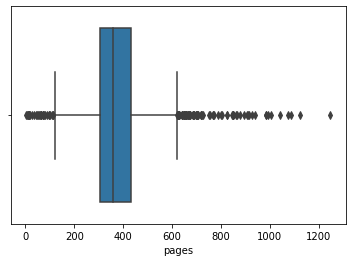

In [77]:
sns.boxplot(df_genres.pages);

In [102]:
df_genres.num_ratings.describe()

count      1990.000
mean      85340.892
std      160750.248
min         293.000
25%       29074.250
50%       47486.000
75%       83685.750
max     3140387.000
Name: num_ratings, dtype: float64

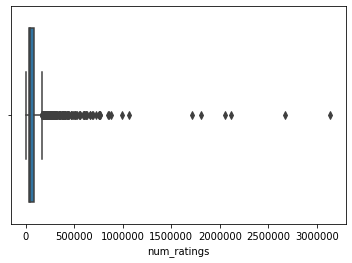

In [98]:
sns.boxplot(df_genres.num_ratings);

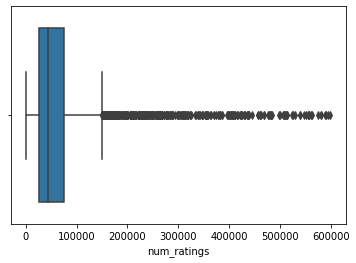

In [175]:
sns.boxplot(less.num_ratings)

In [166]:
len(df)/3

1394.3333333333333

In [168]:
len(df[(df.num_ratings > 80000)]) #& (df.num_ratings > 27000)])

1055

In [150]:
df.num_ratings.describe()

count      4183.000
mean      92458.276
std      222317.413
min         293.000
25%       27043.500
50%       44106.000
75%       80462.000
max     5851687.000
Name: num_ratings, dtype: float64

In [511]:
df = pd.read_csv('keywords.csv')